# Load and check data

In [1]:
import re
import string
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

from imageio import imread
from wordcloud import WordCloud, STOPWORDS

from afinn import Afinn

import gensim
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics, model_selection
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.pipeline import make_pipeline
from sklearn.base import ClassifierMixin
from sklearn.calibration import CalibratedClassifierCV

from keras.models import Sequential, model_from_json, load_model
from keras.layers import SpatialDropout1D, Bidirectional, GlobalAveragePooling1D, Conv1D, MaxPooling1D, Flatten
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils

import xgboost as xgb

/home/zgd/anaconda3/envs/dl/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
Using TensorFlow backend.
/home/zgd/anaconda3/envs/dl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/zgd/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


| entity | semantic |
|-|-|
| `data_` | dataframes containing both raw data and targets |
| `i_` | indices in `data_` objects |
| `y_` | targets |
| `f_` | features |
| `p_` | predictions of models (incl. cross-validated) |
| `q_` | quality metrics (log loss) |
| `t_` | transformers |

In [2]:
# Load in the train and test datasets
data_train = pd.read_csv('../input/train.csv')
data_test = pd.read_csv('../input/test.csv')

data_full = pd.concat([data_train, data_test], ignore_index=True)

print(data_train.shape, data_test.shape, data_full.shape)

data_full.head()

(19579, 3) (8392, 2) (27971, 3)


,author,id,text
0,EAP,id26305,"This process, however, afforded me no means of..."
1,HPL,id17569,It never once occurred to me that the fumbling...
2,EAP,id11008,"In his left hand was a gold snuff box, from wh..."
3,MWS,id27763,How lovely is spring As we looked from Windsor...
4,HPL,id12958,"Finding nothing else, not even gold, the Super..."


In [3]:
# Prepare the id and label for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}

y_full = data_full.author.map(author_mapping_dict)

i_train = ~y_full.isnull()
i_test = y_full.isnull()

y_train = data_train.author.map(author_mapping_dict)

In [4]:
# Explore the dataset 
print("Number of rows in train dataset {}".format(data_train.shape[0]))
print("Number of rows in test dataset {}".format(data_test.shape[0]))
print("No duplicates in train data") if data_train.shape[0] == data_train.text.unique().__len__() else print("Oops")
print("No duplicates in test data") if data_test.shape[0] == data_test.text.unique().__len__() else print("Oops")
print("Unique author is data {}".format(data_train.author.unique()))
print("Number of nulls in the train is {} and text is {}".format(data_train.isnull().sum().sum(), data_test.isnull().sum().sum()))

Number of rows in train dataset 19579
Number of rows in test dataset 8392
No duplicates in train data
No duplicates in test data
Unique author is data ['EAP' 'HPL' 'MWS']
Number of nulls in the train is 0 and text is 0


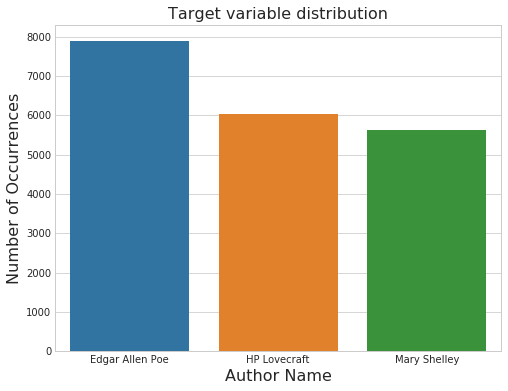

In [5]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
plt.figure(figsize=(8, 6))
plt.title('Target variable distribution', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Author Name', fontsize=16)
sns.barplot(x=data_train.author.map(z).unique(), y=data_train.author.value_counts().values)

# Wordclouds

## Visualise each author's work

(-0.5, 399.5, 199.5, -0.5)

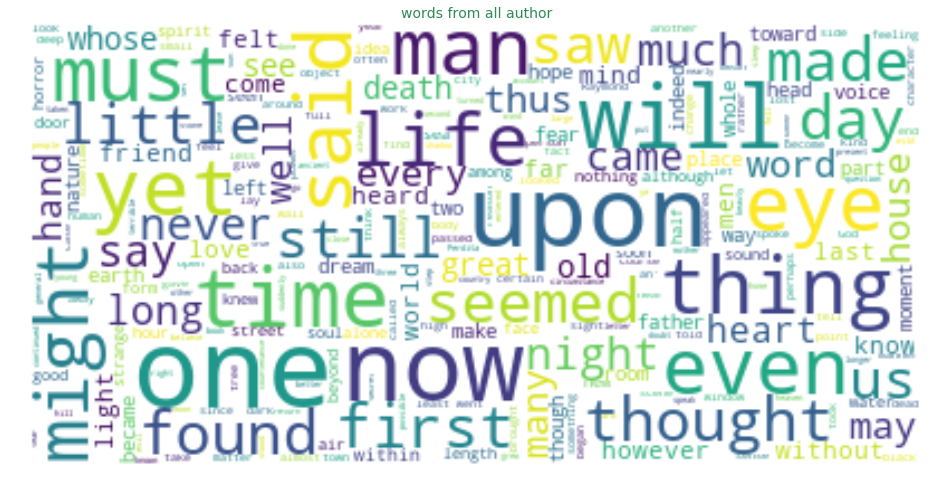

In [6]:
wc = WordCloud(
    background_color="white",
    max_words=5000,
    stopwords=STOPWORDS,
    max_font_size=50)
# generate word cloud
wc.generate(" ".join(data_train.text.values))

# show
plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from all author", fontsize=14, color='seagreen')
plt.axis("off")

In [7]:
img1 = imread("../images/eap.png")
img2 = imread("../images/mws.png")
img3 = imread("../images/hpl.png")

In [8]:
eap = data_train[data_train.author == "EAP"]["text"].values
mws = data_train[data_train.author == "MWS"]["text"].values
hpl = data_train[data_train.author == "HPL"]["text"].values

(-0.5, 639.5, 390.5, -0.5)

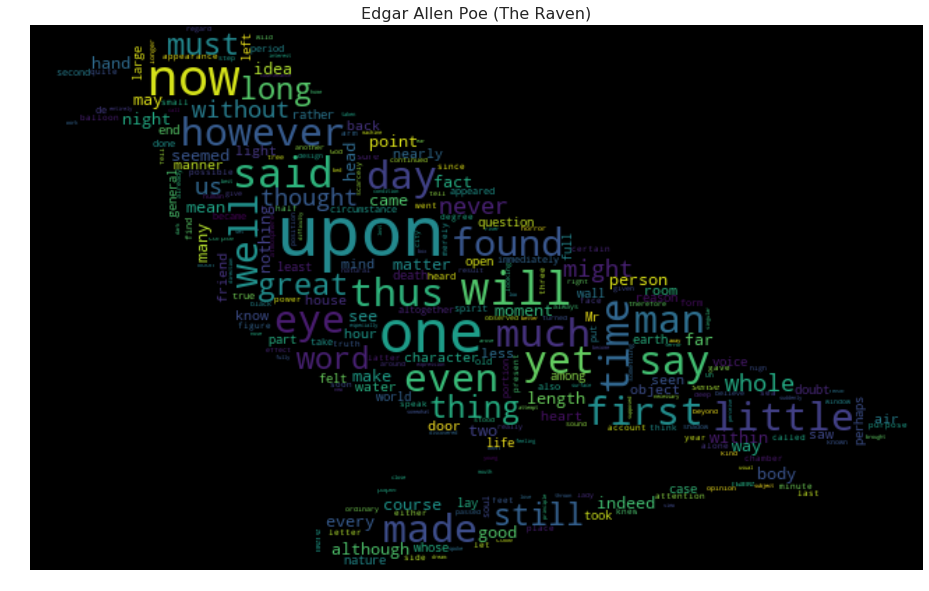

In [9]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img1,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(eap))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Edgar Allen Poe (The Raven)", fontsize=16)
plt.axis("off")

(-0.5, 639.5, 589.5, -0.5)

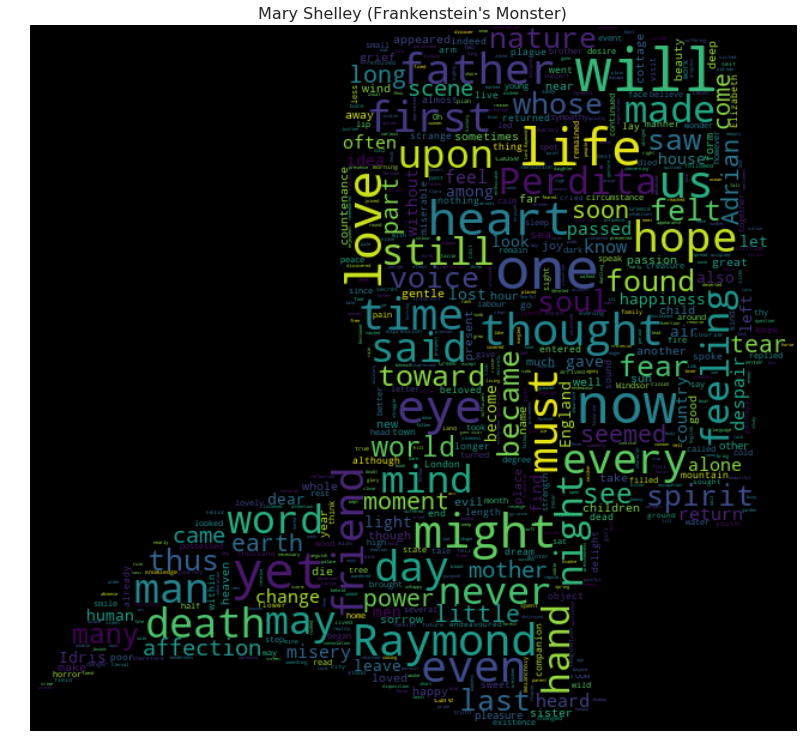

In [10]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img2,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(mws))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize=16)
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

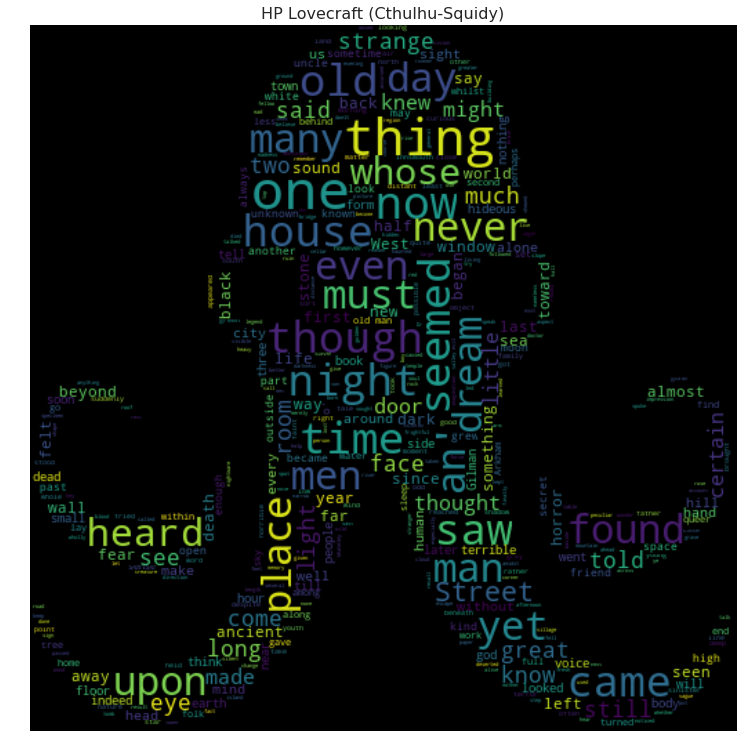

In [11]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img3,
    stopwords=STOPWORDS,
    max_font_size=40)
wc.generate(" ".join(hpl))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=16)
plt.axis('off')

# Natural Language Processing

## Tokenization

In [12]:
# Storing the first text element as a string
first_text = data_train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [13]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal

In [14]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [15]:
first_text_list_cleaned = [
    word for word in first_text_list if word.lower() not in stopwords
]
print(first_text_list_cleaned)
print("=" * 90)
print("Length of original list: {} words\n"
      "Length of list after stopwords removal: {} words".format(
          len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming and Lemmatization

In [16]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
The stemmed form of leaves is: leav


In [17]:
lemm =  nltk.stem.WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("ascertaining")))

The lemmatized form of leaves is: leaf
The lemmatized form of leaves is: ascertaining


## Vectorizing Raw Text

In [18]:
# Defining our sentence
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try CountVectorizer
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [19]:
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try  TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[ 0.63009934  0.44832087  0.          0.44832087  0.44832087]
 [ 0.          0.44832087  0.63009934  0.44832087  0.44832087]]


# Feature Engineering

## 2 Basic features

In [20]:
stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    word_list = tokenizer.tokenize(text.lower())
    return " ".join(word_list)

def diff_comb(df):
    new_df = df.copy()
    new_df['text_cleaned'] = new_df['text'].apply(lambda x: clean_text(x))
    
    tokens = ['.', '..', '...', ',', ':', ';', '-', '*', '\'', '"', '!', '?'] + stopwords
    for token in tokens:
        new_df["n_" + token] = new_df["text"].apply(lambda x: str(x).count(token))
    
    # Find numbers of different combinations
    for c in tqdm(string.ascii_uppercase):
        new_df['n_' + c] = new_df['text'].str.count(c)
        new_df['n_' + c + '.'] = new_df['text'].str.count(c + '\.')
        new_df['n_' + c + ','] = new_df['text'].str.count(c + '\,')

        for c2 in string.ascii_lowercase:
            new_df['n_' + c + c2] = new_df['text'].str.count(c + c2)
            new_df['n_' + c + c2 + '.'] = new_df['text'].str.count(c + c2 + '\.')
            new_df['n_' + c + c2 + ','] = new_df['text'].str.count(c + c2 + '\,')

    for c in tqdm(string.ascii_lowercase):
        new_df['n_' + c + '.'] = new_df['text'].str.count(c + '\.')
        new_df['n_' + c + ','] = new_df['text'].str.count(c + '\,')
        new_df['n_' + c + '?'] = new_df['text'].str.count(c + '\?')
        new_df['n_' + c + ';'] = new_df['text'].str.count(c + '\;')
        new_df['n_' + c + ':'] = new_df['text'].str.count(c + '\:')

        for c2 in string.ascii_lowercase:
            new_df['n_' + c + c2 + '.'] = new_df['text'].str.count(c + c2 + '\.')
            new_df['n_' + c + c2 + ','] = new_df['text'].str.count(c + c2 + '\,')
            new_df['n_' + c + c2 + '?'] = new_df['text'].str.count(c + c2 + '\?')
            new_df['n_' + c + c2 + ';'] = new_df['text'].str.count(c + c2 + '\;')
            new_df['n_' + c + c2 + ':'] = new_df['text'].str.count(c + c2 + '\:')
            new_df['n_' + c + ', ' + c2] = new_df['text'].str.count(c + '\, ' + c2)

    # And now starting processing of cleaned text
    for c in tqdm(string.ascii_lowercase):
        new_df['n_' + c] = new_df['text_cleaned'].str.count(c)
        new_df['n_' + c + ' '] = new_df['text_cleaned'].str.count(c + ' ')
        new_df['n_' + ' ' + c] = new_df['text_cleaned'].str.count(' ' + c)

        for c2 in string.ascii_lowercase:
            new_df['n_' + c + c2] = new_df['text_cleaned'].str.count(c + c2)
            new_df['n_' + c + c2 + ' '] = new_df['text_cleaned'].str.count(c + c2 + ' ')
            new_df['n_' + ' ' + c + c2] = new_df['text_cleaned'].str.count(' ' + c + c2)
            new_df['n_' + c + ' ' + c2] = new_df['text_cleaned'].str.count(c + ' ' + c2)

            for c3 in string.ascii_lowercase:
                new_df['n_' + c + c2 + c3] = new_df['text_cleaned'].str.count(c + c2 + c3)
    
    try:
        new_df.drop(['text_cleaned', 'text', 'author', 'id'], axis=1, inplace=True)
    except:
        new_df.drop(['text_cleaned', 'text', 'id'], axis=1, inplace=True)

    return new_df.values

In [21]:
f_hand = diff_comb(data_full)

100%|██████████| 26/26 [11:35<00:00, 26.75s/it]


In [22]:
stopwords = nltk.corpus.stopwords.words('english')
symbols_known = string.ascii_letters + string.digits + string.punctuation + ' '

data_full["num_words"]        = data_full["text"].apply(lambda x: len(str(x).split()))
data_full["num_chars"]        = data_full["text"].apply(lambda x: len(str(x)))
data_full["mean_word_len"]    = data_full["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

data_full["num_unique_words"] = data_full["text"].apply(lambda x: len(set(str(x).split())))
data_full["num_stopwords"]    = data_full["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
data_full["num_punctuations"] = data_full['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
data_full["num_words_upper"]  = data_full["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
data_full["num_words_title"]  = data_full["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
data_full["len_first_word"]   = data_full["text"].apply(lambda x: len(str(x).split()[0]))
data_full["len_last_word"]    = data_full["text"].apply(lambda x: len(str(x).split()[-1]))
data_full["num_unknown_symbols"] = data_full["text"].apply(lambda x: len([c for c in str(x) if c not in symbols_known]))

data_full["fra_unique_words"] = data_full["num_unique_words"] / data_full["num_words"]
data_full["fra_stopwords"]    = data_full["num_stopwords"] / data_full["num_words"]
data_full["fra_punctuations"] = data_full["num_punctuations"] / data_full["num_words"]
data_full["fra_words_upper"]  = data_full["num_words_upper"] / data_full["num_words"]
data_full["fra_words_title"]  = data_full["num_words_title"] / data_full["num_words"]

data_full["num_no_stopwords"] = data_full["num_words"] - data_full["num_stopwords"]
data_full["fra_no_stopwords"] = data_full["num_no_stopwords"] / data_full["num_words"]
data_full["num_no_punctuations"] = data_full["num_words"] - data_full["num_punctuations"]
data_full["fra_no_punctuations"] = data_full["num_no_punctuations"] / data_full["num_words"]

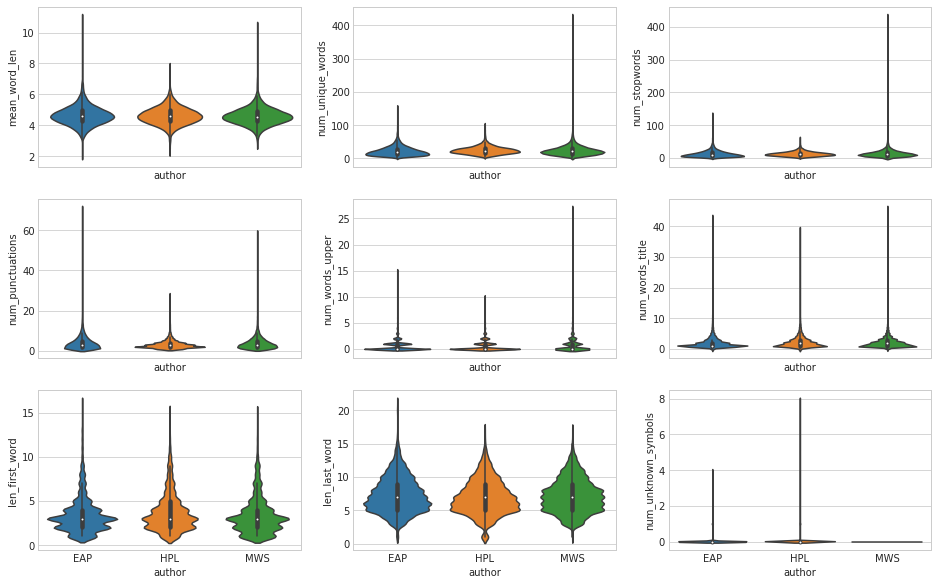

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=(16, 10))
sns.violinplot(x='author', y='mean_word_len', data=data_full, ax=ax[0, 0])
sns.violinplot(x='author', y='num_unique_words', data=data_full, ax=ax[0, 1])
sns.violinplot(x='author', y='num_stopwords', data=data_full, ax=ax[0, 2])

sns.violinplot(x='author', y='num_punctuations', data=data_full, ax=ax[1, 0])
sns.violinplot(x='author', y='num_words_upper', data=data_full, ax=ax[1, 1])
sns.violinplot(x='author', y='num_words_title', data=data_full, ax=ax[1, 2])

sns.violinplot(x='author', y='len_first_word', data=data_full, ax=ax[2, 0])
sns.violinplot(x='author', y='len_last_word', data=data_full, ax=ax[2, 1])
sns.violinplot(x='author', y='num_unknown_symbols', data=data_full, ax=ax[2, 2])

## Spacy NLP features

In [24]:
# https://spacy.io/usage/models#usage-import
# https://spacy.io/usage/models
import en_core_web_md
spacy_nlp = en_core_web_md.load()


# change ne to tag
def get_spacy_text(s):
    pos, tag, dep = '', '', ''
    for token in spacy_nlp(s):
        pos = pos + ' ' + token.pos_
        tag = tag + ' ' + token.tag_
        dep = dep + ' ' + token.dep_

    return pos, tag, dep


poss, tags, deps = [], [], []
for s in tqdm(data_full["text"].values):
    pos, tag, dep = get_spacy_text(s)
    poss.append(pos)
    tags.append(tag)
    deps.append(dep)
data_full['pos_txt'], data_full['tag_txt'], data_full['dep_txt'] = poss, tags, deps

100%|██████████| 27971/27971 [06:33<00:00, 71.17it/s]


In [25]:
## cnt on tag
t_nlp_count = CountVectorizer(ngram_range=(1, 1), lowercase=False)
f_nlp_count = t_nlp_count.fit_transform(data_full['tag_txt'])
print(f_nlp_count.shape)

# cnt on ne
t_nlp_count2 = CountVectorizer(ngram_range=(1, 2), lowercase=False)
f_nlp_count2 = t_nlp_count2.fit_transform(data_full['pos_txt'])
print(f_nlp_count2.shape)

# cnt on dep
t_nlp_count3 = CountVectorizer(ngram_range=(1, 1), lowercase=False)
f_nlp_count3 = t_nlp_count3.fit_transform(data_full['dep_txt'])
print(f_nlp_count3.shape)

# tfidf on tag
t_nlp_tfidf = TfidfVectorizer(ngram_range=(1, 1), lowercase=False)
f_nlp_tfidf = t_nlp_tfidf.fit_transform(data_full['tag_txt'])
print(f_nlp_tfidf.shape)

# tfidf on ne
t_nlp_tfidf2 = TfidfVectorizer(ngram_range=(1, 2), lowercase=False)
f_nlp_tfidf2 = t_nlp_tfidf2.fit_transform(data_full['pos_txt'])
print(f_nlp_tfidf2.shape)

# tfidf on dep
t_nlp_tfidf3 = TfidfVectorizer(ngram_range=(1, 1), lowercase=False)
f_nlp_tfidf3 = t_nlp_tfidf3.fit_transform(data_full['dep_txt'])
print(f_nlp_tfidf3.shape)

(27971, 38)
(27971, 189)
(27971, 45)
(27971, 38)
(27971, 189)
(27971, 45)


In [26]:
f_all_nlp = np.hstack([
    f_nlp_count.toarray(), f_nlp_count2.toarray(), f_nlp_count3.toarray(),
    f_nlp_tfidf.toarray(), f_nlp_tfidf2.toarray(), f_nlp_tfidf3.toarray()
])
np.save('../model/f_all_nlp', f_all_nlp)

#f_all_nlp = np.load('../model/f_all_nlp.npy')

## N-gram Clouds

In [27]:
class WordCloudIntersection():
    def __init__(self,
                 stopwords=list(),
                 punctuation=list(),
                 stemmer=None,
                 ngram=1):
        self.stopwords = stopwords
        self.punctuation = punctuation
        self.remove = self.stopwords + self.punctuation
        self.clouds = dict()
        self.texts = dict()
        self.stemmer = stemmer
        self.ngram = ngram

    def find_ngrams(self, input_list, n):
        return [
            " ".join(list(i))
            for i in zip(* [input_list[i:] for i in range(n)])
        ]

    # It would be much  more correct to call this function 'get_tokens'
    # it extracts not only words, but n-grams as well
    def get_words(self, text):
        words = nltk.tokenize.word_tokenize(text)
        words = [w for w in words if not w in self.remove]
        if not self.stemmer is None:
            words = [self.stemmer.stem(w) for w in words]

        if self.ngram > 1:
            words = self.find_ngrams(words, self.ngram)
        return words

    # Jaccard distance again
    def relative_intersection(self, x, y):
        try:
            return len(x & y) / len(x | y)
        except:
            return 0.0

    def fit(self, x, categories, data_train, data_test=None):
        cat_names = np.unique(data_train[categories])

        text_train = " ".join(list(data_train[x]))
        text_test = ""
        if not data_test is None:
            text_test = " ".join(list(data_test[x]))

        # Tokens presenting in both train and test data
        words_unique = self.get_words((text_train + text_test).lower())

        for cat in cat_names:
            self.texts[cat] = (
                " ".join(list(data_train[x][data_train[categories] == cat]))
            ).lower()
            words = self.get_words(self.texts[cat])
            self.clouds[cat] = pd.value_counts(words)

        # use only tokens presented in both train and test data, 
        # feature will force your model to overfit to the train data otherwise    
        for cat in cat_names:
            self.clouds[cat] = self.clouds[cat][list(
                set(self.clouds[cat].index) & set(words_unique))]

        # Keep only author-specific tokens
        for cat in cat_names:
            key_leftover = list(set(cat_names) - set([cat]))
            bigrams_other = set(self.clouds[key_leftover[0]].index) | set(
                self.clouds[key_leftover[1]].index)
            self.clouds[cat] = self.clouds[cat][list(
                set(self.clouds[cat].index) - bigrams_other)]

    def transform(self, x, data):
        intersection = dict()
        prefix = '_intersect_'
        if self.ngram > 1:
            prefix = '%s-gram%s' % (self.ngram, prefix)
        else:
            prefix = 'word' + prefix
        for key in self.clouds.keys():
            category_words_set = set(self.clouds[key].index)
            intersection[prefix + key] = list()
            for text in data[x]:
                unique_words = set(self.get_words(text.lower()))
                fraction = self.relative_intersection(unique_words,
                                                      category_words_set)
                intersection[prefix + key].append(fraction)
        return pd.DataFrame(intersection)

In [28]:
#stopwords = nltk.corpus.stopwords.words('english')
#t_bigci = WordCloudIntersection(
#    stopwords=stopwords,
#    punctuation=list(string.punctuation),
#    stemmer=nltk.stem.SnowballStemmer('english'),
#    ngram=2)
#t_bigci.fit(x='text', categories='author', data_train=data_train, data_test=data_test)
#
#f_train_big_intersections = t_bigci.transform(x='text', data=data_train)
#f_test_big_intersections = t_bigci.transform(x='text', data=data_test)
#f_big_intersections = pd.DataFrame(np.concatenate((f_train_big_intersections, f_test_big_intersections), axis=0))
#print(f_big_intersections.head())
#
#t_trigci = WordCloudIntersection(
#    stopwords=stopwords,
#    punctuation=list(string.punctuation),
#    stemmer=nltk.stem.SnowballStemmer('english'),
#    ngram=3)
#t_trigci.fit(x='text', categories='author', data_train=data_train, data_test=data_test)
#
#f_train_trig_intersections = t_trigci.transform(x='text', data=data_train)
#f_test_trig_intersections = t_trigci.transform(x='text', data=data_test)
#f_trig_intersections = pd.DataFrame(np.concatenate((f_train_trig_intersections, f_test_trig_intersections), axis=0))
#print(f_trig_intersections.head())

In [29]:
#fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=False, figsize=(16, 10))
#sns.violinplot(x=y_train, y=f_big_intersections[0][i_train], ax=ax[0, 0])
#sns.violinplot(x=y_train, y=f_big_intersections[1][i_train], ax=ax[0, 1])
#sns.violinplot(x=y_train, y=f_big_intersections[2][i_train], ax=ax[0, 2])
#
#sns.violinplot(x=y_train, y=f_trig_intersections[0][i_train], ax=ax[1, 0])
#sns.violinplot(x=y_train, y=f_trig_intersections[1][i_train], ax=ax[1, 1])
#sns.violinplot(x=y_train, y=f_trig_intersections[2][i_train], ax=ax[1, 2])

In [30]:
#f_big_intersections = pd.read_pickle('../model/f_big_intersections.pkl')
#f_trig_intersections = pd.read_pickle('../model/f_trig_intersections.pkl')

In [31]:
#from sklearn.preprocessing import normalize
#
#f_nor_big_intersections = normalize(f_big_intersections)
##f_1000_big_intersections = f_big_intersections * 1000
##f_10000_big_intersections = f_big_intersections * 10000
#
#f_nor_trig_intersections = normalize(f_trig_intersections)
##f_1000_trig_intersections = f_trig_intersections * 1000
##f_10000_trig_intersections = f_trig_intersections * 10000

## Named Entity Recognition

In [32]:
def get_persons(text):
    # Some names have family and given names, but both belong to the same person
    # Bind them!
    def bind_names(tagged_words):
        names = list()
        name = list()
        # Bind several consequtive words with 'PERSON' tag
        for i, w in enumerate(tagged_words):
            if i == 0:
                continue
            if "PERSON" in w[2]:
                name.append(w[0])
            else:
                if len(name) != 0:
                    names.append(" ".join(name))
                name = list()
        return names

    res_ne_tree = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text)))
    res_ne = nltk.tree2conlltags(res_ne_tree)
    res_ne_list = [list(x) for x in res_ne]
    return bind_names(res_ne_list)

In [33]:
#text_EAP = " ".join(list(data_train['text'][data_train['author'] == "EAP"]))
#text_HPL = " ".join(list(data_train['text'][data_train['author'] == "HPL"]))
#text_MWS = " ".join(list(data_train['text'][data_train['author'] == "MWS"]))
#persons_EAP = set(get_persons(text_EAP))
#persons_HPL = set(get_persons(text_HPL))
#persons_MWS = set(get_persons(text_MWS))
### Keep only names related to the authors without any intersections with others
#persons_EAP = persons_EAP - persons_HPL - persons_MWS
#persons_HPL = persons_HPL - persons_EAP - persons_MWS
#persons_MWS = persons_MWS - persons_EAP - persons_HPL
#
#print(raw_eap[:10])
#print(text_EAP[:10])

In [34]:
## It is not a feature! It is just Jaccard distance
#def relative_len(set_x, set_y):
#    return len(set_x & set_y) / len(set_x | set_y)

In [35]:
#for df, name in zip([data_train, data_test], ["train", "test"]):
#    df['persons_EAP_frac'] = df['text'].apply(lambda x: relative_len(persons_EAP, set(get_persons(x))))
#    df['persons_HPL_frac'] = df['text'].apply(lambda x: relative_len(persons_HPL, set(get_persons(x))))
#    df['persons_MWS_frac'] = df['text'].apply(lambda x: relative_len(persons_MWS, set(get_persons(x))))

## Word features

### Word based 6 features

In [36]:
n_components = 40

# TFIDF features
t_tfidf = TfidfVectorizer(ngram_range=(1, 3), stop_words="english", max_df=0.8, min_df=2)
f_tfidf = t_tfidf.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf = TruncatedSVD(n_components=n_components)
f_svd_tfidf = t_svd_tfidf.fit_transform(f_tfidf)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf = StandardScaler()
f_scl_svd_tfidf = t_scl_svd_tfidf.fit_transform(f_svd_tfidf)

# Counters features
t_count = CountVectorizer(ngram_range=(1, 3), stop_words="english", max_df=0.8, min_df=2)
f_count = t_count.fit_transform(data_full.text)

# Counters with SVD features
t_svd_count = TruncatedSVD(n_components=n_components)
#f_svd_count = t_svd_count.fit_transform(f_count.astype(float))  # svd algorithm="arpack", float
f_svd_count = t_svd_count.fit_transform(f_count)

# Counter with SVD and Scale features
t_scl_svd_count = StandardScaler()
f_scl_svd_count = t_scl_svd_count.fit_transform(f_svd_count)

### Stems based 6 features

In [37]:
stemmer = nltk.stem.PorterStemmer()


def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def tokenize_s(text):
    tokens = nltk.word_tokenize(text.lower())
    stems = stem_tokens(tokens, stemmer)
    return stems

In [38]:
# TFIDF features
t_tfidf_s = TfidfVectorizer(tokenizer=tokenize_s, ngram_range=(1, 3), stop_words="english", max_df=0.8, min_df=2)
f_tfidf_s = t_tfidf_s.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf_s = TruncatedSVD(n_components=n_components)
f_svd_tfidf_s = t_svd_tfidf_s.fit_transform(f_tfidf_s)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf_s = StandardScaler()
f_scl_svd_tfidf_s = t_scl_svd_tfidf_s.fit_transform(f_svd_tfidf_s)

# Counters features
t_count_s = CountVectorizer(tokenizer=tokenize_s, ngram_range=(1, 3), stop_words="english", max_df=0.8, min_df=2)
f_count_s = t_count_s.fit_transform(data_full.text)

# Counters with SVD features
t_svd_count_s = TruncatedSVD(n_components=n_components)
f_svd_count_s = t_svd_count_s.fit_transform(f_count_s)

# Counters with SVD and Scale features
t_scl_svd_count_s = StandardScaler()
f_scl_svd_count_s = t_scl_svd_count_s.fit_transform(f_svd_count_s)

### Lemmas based 6 features

In [39]:
lemmatizer = nltk.stem.WordNetLemmatizer()


def tokenize_l(text):
    lemms = []
    for i, j in nltk.pos_tag(nltk.word_tokenize(text.lower())):
        if j[0].lower() in ['a', 'n', 'v']:
            lemms.append(lemmatizer.lemmatize(i, j[0].lower()))
        else:
            lemms.append(lemmatizer.lemmatize(i))
    return lemms

In [40]:
# TFIDF features
t_tfidf_l = TfidfVectorizer(tokenizer=tokenize_l, ngram_range=(1, 3), stop_words="english", max_df=0.8, min_df=2)
f_tfidf_l = t_tfidf_l.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf_l = TruncatedSVD(n_components=n_components)
f_svd_tfidf_l = t_svd_tfidf_l.fit_transform(f_tfidf_l)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf_l = StandardScaler()
f_scl_svd_tfidf_l = t_scl_svd_tfidf_l.fit_transform(f_svd_tfidf_l)

# Counters features
t_count_l = CountVectorizer(tokenizer=tokenize_l, ngram_range=(1, 3), stop_words="english", max_df=0.8, min_df=2)
f_count_l = t_count_l.fit_transform(data_full.text)

# Counters with SVD features
t_svd_count_l = TruncatedSVD(n_components=n_components)
f_svd_count_l = t_svd_count_l.fit_transform(f_count_l)

# Counter with SVD and Scale features
t_scl_svd_count_l = StandardScaler()
f_scl_svd_count_l = t_scl_svd_count_l.fit_transform(f_svd_count_l)

## Char 6 + 2 featurs

In [44]:
# TFIDF features
t_tfidf_c = TfidfVectorizer(analyzer="char", ngram_range=(3, 7), stop_words="english", max_df=0.8, min_df=2)
f_tfidf_c = t_tfidf_c.fit_transform(data_full.text)

t_tfidf_c2 = TfidfVectorizer(analyzer="char", ngram_range=(1, 2), stop_words="english", max_df=0.8, min_df=2)
f_tfidf_c2 = t_tfidf_c2.fit_transform(data_full.text)

# TFIDF with SVD features
t_svd_tfidf_c = TruncatedSVD(n_components=n_components)
f_svd_tfidf_c = t_svd_tfidf_c.fit_transform(f_tfidf_c)

# TFIDF with SVD and Scale features
t_scl_svd_tfidf_c = StandardScaler()
f_scl_svd_tfidf_c = t_scl_svd_tfidf_c.fit_transform(f_svd_tfidf_c)

# Counter features
t_count_c = CountVectorizer(analyzer="char", ngram_range=(3, 7), stop_words="english", max_df=0.8, min_df=2)
f_count_c = t_count_c.fit_transform(data_full.text)

t_count_c2 = CountVectorizer(analyzer="char", ngram_range=(1, 2), stop_words="english", max_df=0.8, min_df=2)
f_count_c2 = t_count_c2.fit_transform(data_full.text)

# Counter with SVD features
t_svd_count_c = TruncatedSVD(n_components=n_components)
f_svd_count_c = t_svd_count_c.fit_transform(f_count_c)

# Counter with SVD and Scale features
t_scl_svd_count_c = StandardScaler()
f_scl_svd_count_c = t_scl_svd_count_c.fit_transform(f_svd_count_c)

In [45]:
print(f_tfidf_c.shape, f_tfidf_c2.shape, f_count_c.shape, f_count_c2.shape)

(27971, 731694) (27971, 937) (27971, 731694) (27971, 937)


In [46]:
f_all_scl_svd = np.hstack([
    f_svd_tfidf, f_scl_svd_tfidf, f_svd_count, f_scl_svd_count,
    f_svd_tfidf_s, f_scl_svd_tfidf_s, f_svd_count_s, f_scl_svd_count_s,
    f_svd_tfidf_l, f_scl_svd_tfidf_l, f_svd_count_l, f_scl_svd_count_l,
    f_svd_tfidf_c, f_scl_svd_tfidf_c, f_svd_count_c, f_scl_svd_count_c,
    f_tfidf_c2.toarray(), f_count_c2.toarray()
])

## Markov event based features

In [47]:
class Dictogram(dict):
    def __init__(self, iterable=None):
        """Initialize this histogram as a new dict; update with given items"""
        super(Dictogram, self).__init__()
        self.types = 0  # the number of distinct item types in this histogram
        self.tokens = 0  # the total count of all item tokens in this histogram
        if iterable:
            self.update(iterable)

    def update(self, iterable):
        """Update this histogram with the items in the given iterable"""
        for item in iterable:
            if item in self:
                self[item] += 1
                self.tokens += 1
            else:
                self[item] = 1
                self.types += 1
                self.tokens += 1

In [48]:
# markov chain based features, order words memory
def make_higher_order_markov_model(data, order):
    markov_model = dict()

    for char_list in data:
        for i in range(len(char_list) - order):
            # Create the window
            window = tuple(char_list[i:i + order])
            # Add to the dictionary
            if window in markov_model:
                # We have to just append to the existing Dictogram
                markov_model[window].update([char_list[i + order]])
            else:
                markov_model[window] = Dictogram([char_list[i + order]])
    return markov_model


def make_tuples(char_list, order):
    """function to make tuples of order size given a char_list and order"""
    list_of_tuple = []
    chars = []
    for i in range(len(char_list) - order):
        window = tuple(char_list[i:i + order])
        list_of_tuple.append(window)
        chars.append(char_list[i + order])
    return (list_of_tuple, chars)


def sent_to_prob(raw, order, MM):
    """function to get the markov model to give prob of a author given a char_list """
    char_list = raw['splited_char_list']
    list_of_tuples, chars = make_tuples(char_list, order)

    p = 0

    # convert to log so we can sum probabilities instead of multiply
    for i in range(len(chars)):
        try:
            p_char = MM[list_of_tuples[i]][chars[i]]
            p_chars = sum([x for x in MM[list_of_tuples[i]].values()])
        except:
            p_char = 1
            p_chars = 1
        p += np.log(p_char / p_chars)
    return p


def text_to_char_list(raw):
    text = raw['text'].lower()
    char_list = [c for c in text]

    return char_list

In [49]:
start_order, end_order = 2, 5 # [start_order, end_order)

data_full['splited_char_list'] = data_full.apply(lambda raw: text_to_char_list(raw), axis=1)

raw_eap = data_full[data_full.author == 'EAP']['splited_char_list'].values
raw_hpl = data_full[data_full.author == 'HPL']['splited_char_list'].values
raw_mws = data_full[data_full.author == 'MWS']['splited_char_list'].values

for order in range(start_order, end_order):
    # build markov model
    eap_MM = make_higher_order_markov_model(raw_eap, order)
    hpl_MM = make_higher_order_markov_model(raw_hpl, order)
    mws_MM = make_higher_order_markov_model(raw_mws, order)

    # create markov features
    data_full['EAP_markov_' + str(order)] = data_full.apply(lambda raw: sent_to_prob(raw, order, eap_MM), axis=1)
    data_full['HPL_markov_' + str(order)] = data_full.apply(lambda raw: sent_to_prob(raw, order, hpl_MM), axis=1)
    data_full['MWS_markov_' + str(order)] = data_full.apply(lambda raw: sent_to_prob(raw, order, mws_MM), axis=1)

del data_full['splited_char_list']

In [50]:
for order in range(start_order, end_order):
    select_elements = ['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]
    tmp_data_full = data_full[select_elements]

    data_full = data_full.drop(select_elements, axis=1)

    # Min-max normalization (row)
    tmp_data_full = tmp_data_full.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

    data_full = pd.concat([data_full, tmp_data_full], axis=1)

In [51]:
markov_orders = pd.DataFrame()
for order in range(start_order, end_order):
    markov_orders = pd.concat(
        [
            markov_orders, data_full[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
        ],
        axis=1)
markov_orders.head()

,EAP_markov_2,HPL_markov_2,MWS_markov_2,EAP_markov_3,HPL_markov_3,MWS_markov_3,EAP_markov_4,HPL_markov_4,MWS_markov_4
0,1.000000,0.000000,0.167721,1.000000,0.608336,0.000000,1.000000,0.376305,0.000000
1,0.588467,1.000000,0.000000,0.000000,1.000000,0.284183,0.075062,0.000000,1.000000
2,0.662029,1.000000,0.000000,0.923098,1.000000,0.000000,0.000000,1.000000,0.962391
3,0.000000,0.432570,1.000000,0.000000,0.296056,1.000000,0.000000,0.519331,1.000000
4,1.000000,0.106623,0.000000,1.000000,0.227594,0.000000,0.986159,0.000000,1.000000


In [ ]:
#print(eap_MM[('n', 'o', 'm', 'e')])
#print(sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))
#print(eap_MM[('n', 'o', 'm', 'e')]['r'])
#print(eap_MM[('n', 'o', 'm', 'e')]['r'] / sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))

## Sentence vector features

### word2vec method

In [52]:
# Load Google's pre-trained Word2Vec model.
word2vec = gensim.models.KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin', binary=True)

### glove method

In [53]:
glove_file = '../model/glove.840B.300d.txt'


# load the GloVe vectors in a dictionary:
def loadGloveEmbeddings(glove_file):
    embeddings_index = {}
    with open(glove_file) as f:
        for line in tqdm(f):
            values = line.split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index


glove2vec = loadGloveEmbeddings(glove_file)

2196017it [03:03, 11935.44it/s]

Found 2196016 word vectors.


In [54]:
def sent2vec(sentence, word2vec):
    #stopwords = nltk.corpus.stopwords.words('english')
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    text_list = tokenizer.tokenize(sentence.lower())
    #text_list = [w for w in text_list if w not in stopwords]
    text_list = [w for w in text_list if w.isalpha()]

    M = []
    for w in text_list:
        try:
            M.append(word2vec[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v**2).sum())

In [55]:
#w2v_sent2v = [sent2vec(x, word2vec) for x in data_full.text]
#f_w2v_sent2v = np.array(w2v_sent2v)
#glv_sent2v = [sent2vec(x, glove2vec) for x in data_full.text]
#f_glv_sent2v = np.array(glv_sent2v)

In [56]:
#np.save('../model/f_w2v_sent2v_2', f_w2v_sent2v)
#np.save('../model/f_glv_sent2v_2', f_glv_sent2v)

f_w2v_sent2v = np.load('../model/f_w2v_sent2v.npy')
f_glv_sent2v = np.load('../model/f_glv_sent2v.npy')

In [57]:
t_scl_w2v_sent2v = StandardScaler()
f_scl_w2v_sent2v = t_scl_w2v_sent2v.fit_transform(f_w2v_sent2v)
t_scl_glv_sent2v = StandardScaler()
f_scl_glv_sent2v = t_scl_glv_sent2v.fit_transform(f_glv_sent2v)

## Sentiment Analysis based features

In [58]:
afinn = Afinn()
sia = SentimentIntensityAnalyzer()


def get_senti_score(text):
    return afinn.score(text)


def sentiment_nltk(text):
    res = sia.polarity_scores(text)
    res_senti = []
    for i in res:
        res_senti.append(res[i])
    return res_senti

In [59]:
#f_senti  = np.array([get_senti_score(text) for text in data_full.text]).reshape(data_full.shape[0], -1)
#
#f_nltk_senti = np.array([sentiment_nltk(text) for text in data_full.text]).reshape(data_full.shape[0], -1)

# Neural Networks and Facebook's FastText

## Helper functions

In [60]:
def apply_nn_model(features,
                   model_func,
                   input_dim=None,
                   embedding_dims=None,
                   max_len=None,
                   embedding_matrix=None):

    n_splits = 5
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)

    epochs=100
    model_path = '/tmp/nn_model.h5'
    earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    model_chk = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1)

    x_train = features[np.nonzero(i_train)]
    x_test = features[np.nonzero(i_test)]
    y_train_enc = np_utils.to_categorical(y_train)

    cv_scores = []
    pred_full_test = np.zeros([x_test.shape[0], 3])
    pred_train = np.zeros([x_train.shape[0], 3])
    
    pred_best_full_test = np.zeros([x_test.shape[0], 3])
    pred_best_train = np.zeros([x_train.shape[0], 3])
    

    for idx_dev, idx_val in kf.split(x_train):
        x_dev, x_val = x_train[idx_dev], x_train[idx_val]
        y_dev, y_val = y_train_enc[idx_dev], y_train_enc[idx_val]

        model = model_func(input_dim, embedding_dims, max_len, embedding_matrix)

        model.fit(
            x_dev,
            y_dev,
            batch_size=512,
            validation_data=(x_val, y_val),
            epochs=epochs,
            callbacks=[earlyStopping, model_chk])
        
        # save feats
        pred_y_val = model.predict(x_val)
        pred_y_test = model.predict(x_test)
        pred_train[idx_val, :] = pred_y_val
        pred_full_test += pred_y_test / float(n_splits)
        
        # best val model
        model = load_model(model_path)
        pred_best_y_val = model.predict(x_val)
        pred_best_y_test = model.predict(x_test)
        pred_best_train[idx_val, :] = pred_best_y_val
        pred_best_full_test += pred_best_y_test / float(n_splits)
        
        cv_scores.append(metrics.log_loss(y_val, pred_best_y_val))
    print("Mean cv score: {}".format(np.mean(cv_scores)))

    p_full = np.concatenate((pred_train, pred_full_test, pred_best_train, pred_best_full_test), axis=0)
    return pd.DataFrame(p_full)

## Input Preprocess

### FastText Input Preprocess

In [61]:
# Separate punctuation from words
# Remove lower frequency words ( <= 2)
# Cut a longer document which contains 256 words
def text_preprocess(text):
    text = text.replace("' ", " ' ")
    signs = set(',.:;"?!')
    prods = set(text) & signs
    if not prods:
        return text

    for sign in prods:
        text = text.replace(sign, ' {} '.format(sign))
    return text


def create_docs(df, n_gram=2):
    def add_ngram(doc, n_gram):
        if n_gram == 1: return doc
        ngrams = []
        #for n in range(2, n_gram_max + 1):
        for w_index in range(len(doc) - n_gram + 1):
            ngrams.append('--'.join(doc[w_index:w_index + n_gram]))
        return ngrams

    docs = []
    for doc in df.text:
        doc = text_preprocess(doc).split()
        docs.append(' '.join(add_ngram(doc, n_gram)))

    return docs

In [62]:
min_count = 2
max_len = 70 # 2-gram mean len: 29.232919809803011

docs = create_docs(data_full, n_gram=1)
tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(docs)

num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])

tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
tokenizer.fit_on_texts(docs)
f_docs_seq = tokenizer.texts_to_sequences(docs)
f_docs_pad = pad_sequences(sequences=f_docs_seq, maxlen=max_len)

word_index = tokenizer.word_index
print(num_words, len(tokenizer.word_index), np.max(f_docs_pad))

19972 29314 19971


In [63]:
docs_2gram = create_docs(data_full, n_gram=2)
tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(docs_2gram)

num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])

tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
tokenizer.fit_on_texts(docs_2gram)
f_docs_2gram_seq = tokenizer.texts_to_sequences(docs_2gram)
f_docs_2gram_pad = pad_sequences(sequences=f_docs_2gram_seq, maxlen=max_len)

word_index_2gram = tokenizer.word_index
print(num_words, len(tokenizer.word_index), np.max(f_docs_2gram_pad))

82055 286605 82054


### Other model Input Preprocess (not include sent2vec)

In [64]:
def text_preprocess(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    word_list = tokenizer.tokenize(text.lower())
    word_list = [w for w in word_list if w.isalpha()]
    ret_text = " ".join([w for w in word_list])

    return ret_text

In [65]:
#min_count = 2
#max_len = 70
#
#pre_text = [text_preprocess(x) for x in data_full.text]
#tokenizer = Tokenizer(lower=False, filters='')
#tokenizer.fit_on_texts(pre_text)
#
#num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])
#
#tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
#tokenizer.fit_on_texts(pre_text)
#f_text_seq = tokenizer.texts_to_sequences(pre_text)
#f_text_pad = pad_sequences(sequences=f_text_seq, maxlen=max_len)
#
#word_index = tokenizer.word_index
#print('Found %s unique tokens.' % len(word_index))
#
#print(num_words, len(word_index), np.max(f_text_pad))

### Word2Vec preprocess

In [66]:
def get_embedding_matrix(word_index, word2vec):
    # create an embedding matrix for the words we have in the dataset
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in tqdm(word_index.items()):
        try:
            embedding_vector = word2vec[word]
        except:
            continue
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [67]:
w2v_embedding_matrix = get_embedding_matrix(word_index, word2vec)
glv_embedding_matrix = get_embedding_matrix(word_index, glove2vec)

100%|██████████| 29314/29314 [00:00<00:00, 373467.43it/s]


In [70]:
print(data_full.text[0])
print(f_docs_pad[0])
print(len(word_index))
print(word_index['process'])
print(word2vec['process'])
print(w2v_embedding_matrix[3341])
print(glove2vec['process'])
print(glv_embedding_matrix[3341])

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0   30 3341    1  146    1 1299   26   41
  290    3 6433    2 2346    3   12 4410   13   20    7   86  194   51 3811
    1    5  309    6    2  268 2212    7  326   80    1  143  134  926    3
    2  312   13   44 1492 4181  105    2  449    4]
29314
3341
[  1.10351562e-01   2.55859375e-01   3.41796875e-02  -2.12402344e-02
  -2.14843750e-01   1.55639648e-03   2.32421875e-01  -7.76367188e-02
  -2.04101562e-01  -6.77490234e-03  -1.58203125e-01  -3.00781250e-01
  -7.99560547e-03  -9.96093750e-02  -2.13867188e-01   1.03515625e-01
   2.06054688e-01  -2.16796875e-01  -1.32812500e-01  -2.13867188e-01
  -2.42919922e-02   1.44531250e-01  -1.24511719e-01   2.

## Neural Networks

In [71]:
def nn_model(input_dim, embedding_dims, max_len, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dims, input_length=max_len))
    model.add(Dropout(0.3))
    model.add(Conv1D(64, 5, padding='valid', activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model

In [72]:
p_nn = apply_nn_model(
    f_docs_pad,
    nn_model,
    input_dim=min(num_words, len(word_index)) + 1,
    embedding_dims=32,
    max_len=max_len)

p_nn_2gram = apply_nn_model(
    f_docs_2gram_pad,
    nn_model,
    input_dim=min(num_words, len(word_index_2gram)) + 1,
    embedding_dims=32,
    max_len=max_len)

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 4s 281us/step - loss: 1.0775 - acc: 0.4078 - val_loss: 1.0639 - val_acc: 0.4571
Epoch 2/100
15663/15663 [==============================] - 0s 19us/step - loss: 0.9998 - acc: 0.5044 - val_loss: 0.9024 - val_acc: 0.5843
Epoch 3/100
15663/15663 [==============================] - 0s 19us/step - loss: 0.7682 - acc: 0.6559 - val_loss: 0.6703 - val_acc: 0.7268
Epoch 4/100
15663/15663 [==============================] - 0s 18us/step - loss: 0.4953 - acc: 0.8103 - val_loss: 0.4939 - val_acc: 0.8179
Epoch 5/100
15663/15663 [==============================] - 0s 19us/step - loss: 0.3147 - acc: 0.8903 - val_loss: 0.4286 - val_acc: 0.8361
Epoch 6/100
15663/15663 [==============================] - 0s 19us/step - loss: 0.2141 - acc: 0.9272 - val_loss: 0.4220 - val_acc: 0.8430
Epoch 7/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.1588 - acc: 0.9490 - val_loss: 0.4304 - 

Epoch 10/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.0719 - acc: 0.9758 - val_loss: 0.5251 - val_acc: 0.8284
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 1s 61us/step - loss: 1.0797 - acc: 0.4096 - val_loss: 1.0584 - val_acc: 0.4469
Epoch 2/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.9990 - acc: 0.5053 - val_loss: 0.8968 - val_acc: 0.5919
Epoch 3/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.7753 - acc: 0.6489 - val_loss: 0.7099 - val_acc: 0.6936
Epoch 4/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.5385 - acc: 0.7868 - val_loss: 0.5290 - val_acc: 0.7901
Epoch 5/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.3499 - acc: 0.8756 - val_loss: 0.4581 - val_acc: 0.8225
Epoch 6/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.2293 - acc: 0.9229 - val_loss: 0.4332 - 

Epoch 9/100
15663/15663 [==============================] - 0s 18us/step - loss: 0.0210 - acc: 0.9953 - val_loss: 0.7675 - val_acc: 0.7845
Epoch 10/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.0147 - acc: 0.9964 - val_loss: 0.7999 - val_acc: 0.7814
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 1s 82us/step - loss: 1.0865 - acc: 0.3984 - val_loss: 1.0799 - val_acc: 0.4091
Epoch 2/100
15663/15663 [==============================] - 0s 18us/step - loss: 1.0577 - acc: 0.4467 - val_loss: 1.0408 - val_acc: 0.5105
Epoch 3/100
15663/15663 [==============================] - 0s 18us/step - loss: 0.8563 - acc: 0.6198 - val_loss: 0.7930 - val_acc: 0.6568
Epoch 4/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.4364 - acc: 0.8366 - val_loss: 0.6171 - val_acc: 0.7444
Epoch 5/100
15663/15663 [==============================] - 0s 18us/step - loss: 0.1667 - acc: 0.9501 - val_loss: 0.6077 - 

15664/15664 [==============================] - 1s 78us/step - loss: 1.0830 - acc: 0.4039 - val_loss: 1.0718 - val_acc: 0.4072
Epoch 2/100
15664/15664 [==============================] - 0s 18us/step - loss: 1.0471 - acc: 0.4571 - val_loss: 1.0297 - val_acc: 0.5208
Epoch 3/100
15664/15664 [==============================] - 0s 19us/step - loss: 0.8108 - acc: 0.6535 - val_loss: 0.7605 - val_acc: 0.6858
Epoch 4/100
15664/15664 [==============================] - 0s 18us/step - loss: 0.3451 - acc: 0.8797 - val_loss: 0.6007 - val_acc: 0.7607
Epoch 5/100
15664/15664 [==============================] - 0s 18us/step - loss: 0.1192 - acc: 0.9644 - val_loss: 0.6230 - val_acc: 0.7724
Epoch 6/100
15664/15664 [==============================] - 0s 18us/step - loss: 0.0529 - acc: 0.9852 - val_loss: 0.6758 - val_acc: 0.7709
Epoch 7/100
15664/15664 [==============================] - 0s 19us/step - loss: 0.0330 - acc: 0.9915 - val_loss: 0.7268 - val_acc: 0.7752
Epoch 8/100
15664/15664 [=====================

In [73]:
#p_nn = pd.read_pickle('../model/p_nn.pkl')

## Sent2vec Neural Network

In [74]:
# no use input_dim, embedding_dims, max_len, embedding_matrix
def sent2vec_model(input_dim, embedding_dims, max_len, embedding_matrix):
    # create a simple 3 layer sequential neural net
    model = Sequential()

    model.add(Dense(128, input_dim=300))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.3))

    model.add(Dense(3))
    model.add(Activation('softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model

In [75]:
p_w2v_sent2v_nn = apply_nn_model(f_scl_w2v_sent2v, sent2vec_model)

p_glv_sent2v_nn = apply_nn_model(f_scl_glv_sent2v, sent2vec_model)

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 2s 146us/step - loss: 1.0971 - acc: 0.4700 - val_loss: 0.8237 - val_acc: 0.6359
Epoch 2/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.8655 - acc: 0.6118 - val_loss: 0.7482 - val_acc: 0.6770
Epoch 3/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.7978 - acc: 0.6500 - val_loss: 0.7096 - val_acc: 0.6961
Epoch 4/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.7592 - acc: 0.6718 - val_loss: 0.6895 - val_acc: 0.7076
Epoch 5/100
15663/15663 [==============================] - 0s 18us/step - loss: 0.7285 - acc: 0.6884 - val_loss: 0.6754 - val_acc: 0.7130
Epoch 6/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.7002 - acc: 0.7045 - val_loss: 0.6659 - val_acc: 0.7150
Epoch 7/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.6886 - acc: 0.7083 - val_loss: 0.6582 - 

15663/15663 [==============================] - 0s 16us/step - loss: 0.4603 - acc: 0.8169 - val_loss: 0.6335 - val_acc: 0.7421
Epoch 29/100
15663/15663 [==============================] - 0s 15us/step - loss: 0.4494 - acc: 0.8164 - val_loss: 0.6352 - val_acc: 0.7413
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 1s 94us/step - loss: 1.1023 - acc: 0.4982 - val_loss: 0.8447 - val_acc: 0.6379
Epoch 2/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.8577 - acc: 0.6176 - val_loss: 0.7651 - val_acc: 0.6757
Epoch 3/100
15663/15663 [==============================] - 0s 15us/step - loss: 0.7940 - acc: 0.6520 - val_loss: 0.7279 - val_acc: 0.6908
Epoch 4/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.7491 - acc: 0.6775 - val_loss: 0.7052 - val_acc: 0.6987
Epoch 5/100
15663/15663 [==============================] - 0s 15us/step - loss: 0.7204 - acc: 0.6909 - val_loss: 0.6921 - val_acc: 0.7

15663/15663 [==============================] - 0s 16us/step - loss: 0.7452 - acc: 0.6810 - val_loss: 0.7168 - val_acc: 0.7017
Epoch 5/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.7144 - acc: 0.6965 - val_loss: 0.6999 - val_acc: 0.7104
Epoch 6/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.6948 - acc: 0.7031 - val_loss: 0.6911 - val_acc: 0.7142
Epoch 7/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.6757 - acc: 0.7165 - val_loss: 0.6844 - val_acc: 0.7117
Epoch 8/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.6629 - acc: 0.7228 - val_loss: 0.6781 - val_acc: 0.7168
Epoch 9/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.6489 - acc: 0.7264 - val_loss: 0.6725 - val_acc: 0.7140
Epoch 10/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.6301 - acc: 0.7364 - val_loss: 0.6723 - val_acc: 0.7142
Epoch 11/100
15663/15663 [===================

Epoch 10/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.6342 - acc: 0.7350 - val_loss: 0.6544 - val_acc: 0.7163
Epoch 11/100
15663/15663 [==============================] - 0s 15us/step - loss: 0.6295 - acc: 0.7384 - val_loss: 0.6500 - val_acc: 0.7214
Epoch 12/100
15663/15663 [==============================] - 0s 15us/step - loss: 0.6145 - acc: 0.7384 - val_loss: 0.6466 - val_acc: 0.7232
Epoch 13/100
15663/15663 [==============================] - 0s 15us/step - loss: 0.6039 - acc: 0.7476 - val_loss: 0.6461 - val_acc: 0.7268
Epoch 14/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.5956 - acc: 0.7537 - val_loss: 0.6432 - val_acc: 0.7247
Epoch 15/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.5880 - acc: 0.7556 - val_loss: 0.6402 - val_acc: 0.7306
Epoch 16/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.5755 - acc: 0.7624 - val_loss: 0.6407 - val_acc: 0.7326
Epoch 17/100
15663/15663 [=

15664/15664 [==============================] - 0s 14us/step - loss: 0.5883 - acc: 0.7569 - val_loss: 0.6513 - val_acc: 0.7257
Epoch 16/100
15664/15664 [==============================] - 0s 14us/step - loss: 0.5778 - acc: 0.7604 - val_loss: 0.6494 - val_acc: 0.7318
Epoch 17/100
15664/15664 [==============================] - 0s 15us/step - loss: 0.5641 - acc: 0.7666 - val_loss: 0.6495 - val_acc: 0.7313
Epoch 18/100
15664/15664 [==============================] - 0s 15us/step - loss: 0.5563 - acc: 0.7734 - val_loss: 0.6447 - val_acc: 0.7310
Epoch 19/100
15664/15664 [==============================] - 0s 14us/step - loss: 0.5433 - acc: 0.7774 - val_loss: 0.6453 - val_acc: 0.7364
Epoch 20/100
15664/15664 [==============================] - 0s 15us/step - loss: 0.5452 - acc: 0.7717 - val_loss: 0.6498 - val_acc: 0.7361
Epoch 21/100
15664/15664 [==============================] - 0s 15us/step - loss: 0.5294 - acc: 0.7806 - val_loss: 0.6462 - val_acc: 0.7364
Epoch 22/100
15664/15664 [==============

Epoch 20/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.5180 - acc: 0.7851 - val_loss: 0.5997 - val_acc: 0.7561
Epoch 21/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.5093 - acc: 0.7914 - val_loss: 0.5973 - val_acc: 0.7623
Epoch 22/100
15663/15663 [==============================] - 0s 17us/step - loss: 0.5026 - acc: 0.7945 - val_loss: 0.5947 - val_acc: 0.7605
Epoch 23/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.4917 - acc: 0.8009 - val_loss: 0.5970 - val_acc: 0.7612
Epoch 24/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.4856 - acc: 0.8047 - val_loss: 0.5978 - val_acc: 0.7584
Epoch 25/100
15663/15663 [==============================] - 0s 15us/step - loss: 0.4762 - acc: 0.8076 - val_loss: 0.5992 - val_acc: 0.7589
Epoch 26/100
15663/15663 [==============================] - 0s 15us/step - loss: 0.4685 - acc: 0.8120 - val_loss: 0.6020 - val_acc: 0.7577
Epoch 27/100
15663/15663 [=

Epoch 24/100
15663/15663 [==============================] - 0s 14us/step - loss: 0.4828 - acc: 0.8041 - val_loss: 0.6161 - val_acc: 0.7526
Epoch 25/100
15663/15663 [==============================] - 0s 14us/step - loss: 0.4722 - acc: 0.8108 - val_loss: 0.6183 - val_acc: 0.7487
Epoch 26/100
15663/15663 [==============================] - 0s 14us/step - loss: 0.4652 - acc: 0.8123 - val_loss: 0.6216 - val_acc: 0.7503
Epoch 27/100
15663/15663 [==============================] - 0s 15us/step - loss: 0.4605 - acc: 0.8151 - val_loss: 0.6181 - val_acc: 0.7510
Epoch 28/100
15663/15663 [==============================] - 0s 15us/step - loss: 0.4555 - acc: 0.8159 - val_loss: 0.6261 - val_acc: 0.7482
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 2s 133us/step - loss: 1.2498 - acc: 0.4566 - val_loss: 0.9436 - val_acc: 0.6147
Epoch 2/100
15663/15663 [==============================] - 0s 14us/step - loss: 0.9146 - acc: 0.6094 - val_loss: 0.79

15663/15663 [==============================] - 2s 144us/step - loss: 1.0745 - acc: 0.4922 - val_loss: 0.8434 - val_acc: 0.6343
Epoch 2/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.8559 - acc: 0.6203 - val_loss: 0.7772 - val_acc: 0.6719
Epoch 3/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.7875 - acc: 0.6614 - val_loss: 0.7300 - val_acc: 0.6915
Epoch 4/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.7363 - acc: 0.6900 - val_loss: 0.6950 - val_acc: 0.7058
Epoch 5/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.7152 - acc: 0.7027 - val_loss: 0.6731 - val_acc: 0.7163
Epoch 6/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.6752 - acc: 0.7160 - val_loss: 0.6595 - val_acc: 0.7211
Epoch 7/100
15663/15663 [==============================] - 0s 16us/step - loss: 0.6665 - acc: 0.7261 - val_loss: 0.6444 - val_acc: 0.7293
Epoch 8/100
15663/15663 [====================

Epoch 3/100
15664/15664 [==============================] - 0s 15us/step - loss: 0.7753 - acc: 0.6701 - val_loss: 0.7336 - val_acc: 0.6963
Epoch 4/100
15664/15664 [==============================] - 0s 16us/step - loss: 0.7420 - acc: 0.6856 - val_loss: 0.7017 - val_acc: 0.7088
Epoch 5/100
15664/15664 [==============================] - 0s 16us/step - loss: 0.7125 - acc: 0.6968 - val_loss: 0.6845 - val_acc: 0.7198
Epoch 6/100
15664/15664 [==============================] - 0s 16us/step - loss: 0.6912 - acc: 0.7145 - val_loss: 0.6693 - val_acc: 0.7239
Epoch 7/100
15664/15664 [==============================] - 0s 16us/step - loss: 0.6659 - acc: 0.7249 - val_loss: 0.6577 - val_acc: 0.7308
Epoch 8/100
15664/15664 [==============================] - 0s 16us/step - loss: 0.6511 - acc: 0.7298 - val_loss: 0.6480 - val_acc: 0.7287
Epoch 9/100
15664/15664 [==============================] - 0s 16us/step - loss: 0.6390 - acc: 0.7371 - val_loss: 0.6430 - val_acc: 0.7328
Epoch 10/100
15664/15664 [========

In [76]:
#p_w2v_sent2v_nn = pd.read_pickle('../model/p_w2v_sent2v_nn.pkl')
#p_glv_sent2v_nn = pd.read_pickle('../model/p_glv_sent2v_nn.pkl')

## FastText

In [77]:
def fasttext_model(input_dim, embedding_dims, max_len, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dims))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [78]:
p_fasttext = apply_nn_model(
    f_docs_pad,
    fasttext_model,
    input_dim=np.max(f_docs_pad) + 1,
    embedding_dims=20,
    max_len=max_len,
    embedding_matrix=None)

p_fasttext_2gram = apply_nn_model(
    f_docs_2gram_pad,
    fasttext_model,
    input_dim=np.max(f_docs_2gram_pad) + 1,
    embedding_dims=20,
    max_len=max_len,
    embedding_matrix=None)

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 3s 222us/step - loss: 1.0893 - acc: 0.4064 - val_loss: 1.0846 - val_acc: 0.3922
Epoch 2/100
15663/15663 [==============================] - 0s 10us/step - loss: 1.0753 - acc: 0.4063 - val_loss: 1.0764 - val_acc: 0.3925
Epoch 3/100
15663/15663 [==============================] - 0s 10us/step - loss: 1.0647 - acc: 0.4084 - val_loss: 1.0672 - val_acc: 0.3961
Epoch 4/100
15663/15663 [==============================] - 0s 10us/step - loss: 1.0523 - acc: 0.4212 - val_loss: 1.0545 - val_acc: 0.4109
Epoch 5/100
15663/15663 [==============================] - 0s 10us/step - loss: 1.0369 - acc: 0.4398 - val_loss: 1.0395 - val_acc: 0.4280
Epoch 6/100
15663/15663 [==============================] - 0s 10us/step - loss: 1.0185 - acc: 0.4644 - val_loss: 1.0213 - val_acc: 0.4607
Epoch 7/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.9971 - acc: 0.5046 - val_loss: 1.0006 - v

15663/15663 [==============================] - 0s 12us/step - loss: 0.5447 - acc: 0.8442 - val_loss: 0.6098 - val_acc: 0.7880
Epoch 28/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.5305 - acc: 0.8524 - val_loss: 0.5992 - val_acc: 0.7896
Epoch 29/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.5172 - acc: 0.8568 - val_loss: 0.5892 - val_acc: 0.7929
Epoch 30/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.5045 - acc: 0.8599 - val_loss: 0.5787 - val_acc: 0.8016
Epoch 31/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.4924 - acc: 0.8615 - val_loss: 0.5700 - val_acc: 0.8011
Epoch 32/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.4807 - acc: 0.8659 - val_loss: 0.5603 - val_acc: 0.8052
Epoch 33/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.4694 - acc: 0.8683 - val_loss: 0.5518 - val_acc: 0.8100
Epoch 34/100
15663/15663 [==============

Epoch 54/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.3060 - acc: 0.9204 - val_loss: 0.4393 - val_acc: 0.8404
Epoch 55/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.3005 - acc: 0.9230 - val_loss: 0.4370 - val_acc: 0.8391
Epoch 56/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2952 - acc: 0.9247 - val_loss: 0.4327 - val_acc: 0.8435
Epoch 57/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2901 - acc: 0.9259 - val_loss: 0.4296 - val_acc: 0.8432
Epoch 58/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.2853 - acc: 0.9277 - val_loss: 0.4271 - val_acc: 0.8437
Epoch 59/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.2802 - acc: 0.9285 - val_loss: 0.4240 - val_acc: 0.8447
Epoch 60/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.2754 - acc: 0.9315 - val_loss: 0.4222 - val_acc: 0.8437
Epoch 61/100
15663/15663 [=

15663/15663 [==============================] - 0s 11us/step - loss: 0.2007 - acc: 0.9517 - val_loss: 0.3856 - val_acc: 0.8516
Epoch 81/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.1978 - acc: 0.9521 - val_loss: 0.3844 - val_acc: 0.8514
Epoch 82/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.1949 - acc: 0.9535 - val_loss: 0.3832 - val_acc: 0.8527
Epoch 83/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.1921 - acc: 0.9544 - val_loss: 0.3815 - val_acc: 0.8542
Epoch 84/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.1893 - acc: 0.9545 - val_loss: 0.3808 - val_acc: 0.8534
Epoch 85/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.1869 - acc: 0.9564 - val_loss: 0.3798 - val_acc: 0.8534
Epoch 86/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.1842 - acc: 0.9563 - val_loss: 0.3786 - val_acc: 0.8529
Epoch 87/100
15663/15663 [==============

15663/15663 [==============================] - 0s 12us/step - loss: 0.9772 - acc: 0.5462 - val_loss: 0.9747 - val_acc: 0.5628
Epoch 9/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.9520 - acc: 0.5879 - val_loss: 0.9517 - val_acc: 0.5873
Epoch 10/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.9256 - acc: 0.6294 - val_loss: 0.9284 - val_acc: 0.6251
Epoch 11/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.8984 - acc: 0.6561 - val_loss: 0.9045 - val_acc: 0.6387
Epoch 12/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.8709 - acc: 0.6843 - val_loss: 0.8813 - val_acc: 0.6805
Epoch 13/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.8439 - acc: 0.7197 - val_loss: 0.8579 - val_acc: 0.6800
Epoch 14/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.8171 - acc: 0.7360 - val_loss: 0.8357 - val_acc: 0.7071
Epoch 15/100
15663/15663 [=====================

Epoch 40/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.4060 - acc: 0.8933 - val_loss: 0.5228 - val_acc: 0.8131
Epoch 41/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.3974 - acc: 0.8961 - val_loss: 0.5172 - val_acc: 0.8202
Epoch 42/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.3891 - acc: 0.8984 - val_loss: 0.5114 - val_acc: 0.8169
Epoch 43/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.3810 - acc: 0.9009 - val_loss: 0.5065 - val_acc: 0.8187
Epoch 44/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.3732 - acc: 0.9038 - val_loss: 0.5012 - val_acc: 0.8200
Epoch 45/100
15663/15663 [==============================] - 0s 8us/step - loss: 0.3657 - acc: 0.9042 - val_loss: 0.4965 - val_acc: 0.8202
Epoch 46/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.3584 - acc: 0.9077 - val_loss: 0.4917 - val_acc: 0.8207
Epoch 47/100
15663/15663 [=======

Epoch 72/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2260 - acc: 0.9467 - val_loss: 0.4178 - val_acc: 0.8427
Epoch 73/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.2224 - acc: 0.9477 - val_loss: 0.4165 - val_acc: 0.8409
Epoch 74/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2189 - acc: 0.9485 - val_loss: 0.4149 - val_acc: 0.8409
Epoch 75/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2157 - acc: 0.9498 - val_loss: 0.4134 - val_acc: 0.8412
Epoch 76/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.2124 - acc: 0.9498 - val_loss: 0.4122 - val_acc: 0.8422
Epoch 77/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.2089 - acc: 0.9514 - val_loss: 0.4107 - val_acc: 0.8414
Epoch 78/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.2058 - acc: 0.9528 - val_loss: 0.4099 - val_acc: 0.8412
Epoch 79/100
15663/15663 [====

Epoch 4/100
15663/15663 [==============================] - 0s 9us/step - loss: 1.0525 - acc: 0.4154 - val_loss: 1.0494 - val_acc: 0.4201
Epoch 5/100
15663/15663 [==============================] - 0s 9us/step - loss: 1.0366 - acc: 0.4344 - val_loss: 1.0342 - val_acc: 0.4377
Epoch 6/100
15663/15663 [==============================] - 0s 9us/step - loss: 1.0175 - acc: 0.4679 - val_loss: 1.0164 - val_acc: 0.4801
Epoch 7/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.9955 - acc: 0.5067 - val_loss: 0.9965 - val_acc: 0.5189
Epoch 8/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.9710 - acc: 0.5558 - val_loss: 0.9746 - val_acc: 0.5559
Epoch 9/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.9446 - acc: 0.6005 - val_loss: 0.9515 - val_acc: 0.5932
Epoch 10/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.9171 - acc: 0.6402 - val_loss: 0.9276 - val_acc: 0.6295
Epoch 11/100
15663/15663 [==========

Epoch 36/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.4348 - acc: 0.8850 - val_loss: 0.5480 - val_acc: 0.8136
Epoch 37/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.4250 - acc: 0.8872 - val_loss: 0.5414 - val_acc: 0.8141
Epoch 38/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.4158 - acc: 0.8901 - val_loss: 0.5347 - val_acc: 0.8169
Epoch 39/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.4067 - acc: 0.8926 - val_loss: 0.5285 - val_acc: 0.8192
Epoch 40/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.3978 - acc: 0.8940 - val_loss: 0.5224 - val_acc: 0.8200
Epoch 41/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.3895 - acc: 0.8989 - val_loss: 0.5168 - val_acc: 0.8220
Epoch 42/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.3814 - acc: 0.8994 - val_loss: 0.5113 - val_acc: 0.8225
Epoch 43/100
15663/15663 [===

Epoch 68/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.2368 - acc: 0.9432 - val_loss: 0.4244 - val_acc: 0.8455
Epoch 69/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2331 - acc: 0.9441 - val_loss: 0.4229 - val_acc: 0.8458
Epoch 70/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.2294 - acc: 0.9458 - val_loss: 0.4208 - val_acc: 0.8478
Epoch 71/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.2258 - acc: 0.9464 - val_loss: 0.4195 - val_acc: 0.8453
Epoch 72/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2221 - acc: 0.9473 - val_loss: 0.4177 - val_acc: 0.8463
Epoch 73/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.2186 - acc: 0.9488 - val_loss: 0.4162 - val_acc: 0.8460
Epoch 74/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2152 - acc: 0.9494 - val_loss: 0.4146 - val_acc: 0.8470
Epoch 75/100
15663/15663 [=

Epoch 100/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.1475 - acc: 0.9668 - val_loss: 0.3929 - val_acc: 0.8491
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 2s 157us/step - loss: 1.0900 - acc: 0.4002 - val_loss: 1.0830 - val_acc: 0.4040
Epoch 2/100
15663/15663 [==============================] - 0s 10us/step - loss: 1.0772 - acc: 0.4034 - val_loss: 1.0723 - val_acc: 0.4042
Epoch 3/100
15663/15663 [==============================] - 0s 10us/step - loss: 1.0660 - acc: 0.4050 - val_loss: 1.0615 - val_acc: 0.4086
Epoch 4/100
15663/15663 [==============================] - 0s 10us/step - loss: 1.0531 - acc: 0.4167 - val_loss: 1.0485 - val_acc: 0.4244
Epoch 5/100
15663/15663 [==============================] - 0s 10us/step - loss: 1.0374 - acc: 0.4376 - val_loss: 1.0327 - val_acc: 0.4474
Epoch 6/100
15663/15663 [==============================] - 0s 10us/step - loss: 1.0187 - acc: 0.4633 - val_loss: 1.0143 -

15663/15663 [==============================] - 0s 9us/step - loss: 0.4906 - acc: 0.8653 - val_loss: 0.5618 - val_acc: 0.8113
Epoch 32/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.4791 - acc: 0.8707 - val_loss: 0.5528 - val_acc: 0.8090
Epoch 33/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.4678 - acc: 0.8738 - val_loss: 0.5445 - val_acc: 0.8146
Epoch 34/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.4570 - acc: 0.8767 - val_loss: 0.5366 - val_acc: 0.8159
Epoch 35/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.4469 - acc: 0.8799 - val_loss: 0.5293 - val_acc: 0.8166
Epoch 36/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.4370 - acc: 0.8828 - val_loss: 0.5229 - val_acc: 0.8169
Epoch 37/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.4274 - acc: 0.8855 - val_loss: 0.5155 - val_acc: 0.8166
Epoch 38/100
15663/15663 [===================

Epoch 63/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2629 - acc: 0.9330 - val_loss: 0.4132 - val_acc: 0.8440
Epoch 64/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2586 - acc: 0.9344 - val_loss: 0.4108 - val_acc: 0.8440
Epoch 65/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2545 - acc: 0.9353 - val_loss: 0.4085 - val_acc: 0.8447
Epoch 66/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2503 - acc: 0.9372 - val_loss: 0.4066 - val_acc: 0.8453
Epoch 67/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2464 - acc: 0.9386 - val_loss: 0.4045 - val_acc: 0.8460
Epoch 68/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.2427 - acc: 0.9396 - val_loss: 0.4024 - val_acc: 0.8463
Epoch 69/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.2389 - acc: 0.9406 - val_loss: 0.4014 - val_acc: 0.8468
Epoch 70/100
15663/15663 [=

Epoch 95/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.1635 - acc: 0.9616 - val_loss: 0.3736 - val_acc: 0.8481
Epoch 96/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.1613 - acc: 0.9616 - val_loss: 0.3731 - val_acc: 0.8498
Epoch 97/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.1592 - acc: 0.9622 - val_loss: 0.3729 - val_acc: 0.8481
Epoch 98/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.1569 - acc: 0.9631 - val_loss: 0.3721 - val_acc: 0.8488
Epoch 99/100
15663/15663 [==============================] - 0s 9us/step - loss: 0.1550 - acc: 0.9641 - val_loss: 0.3719 - val_acc: 0.8498
Epoch 100/100
15663/15663 [==============================] - 2s 101us/step - loss: 0.1529 - acc: 0.9651 - val_loss: 0.3714 - val_acc: 0.8493
Train on 15664 samples, validate on 3915 samples
Epoch 1/100
15664/15664 [==============================] - 2s 151us/step - loss: 1.0900 - acc: 0.3972 - val_loss: 1.08

15664/15664 [==============================] - 0s 10us/step - loss: 0.5559 - acc: 0.8414 - val_loss: 0.6287 - val_acc: 0.7829
Epoch 27/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.5414 - acc: 0.8470 - val_loss: 0.6177 - val_acc: 0.7847
Epoch 28/100
15664/15664 [==============================] - 0s 9us/step - loss: 0.5275 - acc: 0.8507 - val_loss: 0.6070 - val_acc: 0.7870
Epoch 29/100
15664/15664 [==============================] - 0s 10us/step - loss: 0.5143 - acc: 0.8544 - val_loss: 0.5971 - val_acc: 0.7893
Epoch 30/100
15664/15664 [==============================] - 0s 9us/step - loss: 0.5017 - acc: 0.8588 - val_loss: 0.5877 - val_acc: 0.7928
Epoch 31/100
15664/15664 [==============================] - 0s 9us/step - loss: 0.4895 - acc: 0.8614 - val_loss: 0.5782 - val_acc: 0.8005
Epoch 32/100
15664/15664 [==============================] - 0s 9us/step - loss: 0.4778 - acc: 0.8678 - val_loss: 0.5698 - val_acc: 0.7974
Epoch 33/100
15664/15664 [==================

Epoch 58/100
15664/15664 [==============================] - 0s 9us/step - loss: 0.2848 - acc: 0.9275 - val_loss: 0.4359 - val_acc: 0.8381
Epoch 59/100
15664/15664 [==============================] - 0s 9us/step - loss: 0.2797 - acc: 0.9305 - val_loss: 0.4324 - val_acc: 0.8414
Epoch 60/100
15664/15664 [==============================] - 0s 9us/step - loss: 0.2751 - acc: 0.9315 - val_loss: 0.4296 - val_acc: 0.8416
Epoch 61/100
15664/15664 [==============================] - 0s 10us/step - loss: 0.2704 - acc: 0.9325 - val_loss: 0.4275 - val_acc: 0.8419
Epoch 62/100
15664/15664 [==============================] - 0s 10us/step - loss: 0.2660 - acc: 0.9342 - val_loss: 0.4241 - val_acc: 0.8444
Epoch 63/100
15664/15664 [==============================] - 0s 10us/step - loss: 0.2616 - acc: 0.9356 - val_loss: 0.4219 - val_acc: 0.8447
Epoch 64/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.2573 - acc: 0.9365 - val_loss: 0.4208 - val_acc: 0.8432
Epoch 65/100
15664/15664 [====

Epoch 90/100
15664/15664 [==============================] - 0s 10us/step - loss: 0.1743 - acc: 0.9593 - val_loss: 0.3789 - val_acc: 0.8572
Epoch 91/100
15664/15664 [==============================] - 0s 10us/step - loss: 0.1718 - acc: 0.9600 - val_loss: 0.3783 - val_acc: 0.8564
Epoch 92/100
15664/15664 [==============================] - 0s 10us/step - loss: 0.1695 - acc: 0.9608 - val_loss: 0.3783 - val_acc: 0.8572
Epoch 93/100
15664/15664 [==============================] - 0s 10us/step - loss: 0.1674 - acc: 0.9605 - val_loss: 0.3766 - val_acc: 0.8570
Epoch 94/100
15664/15664 [==============================] - 0s 10us/step - loss: 0.1650 - acc: 0.9620 - val_loss: 0.3766 - val_acc: 0.8575
Epoch 95/100
15664/15664 [==============================] - 0s 10us/step - loss: 0.1627 - acc: 0.9623 - val_loss: 0.3753 - val_acc: 0.8562
Epoch 96/100
15664/15664 [==============================] - 0s 10us/step - loss: 0.1604 - acc: 0.9628 - val_loss: 0.3748 - val_acc: 0.8567
Epoch 97/100
15664/15664 [=

Epoch 18/100
15663/15663 [==============================] - 0s 13us/step - loss: 0.6800 - acc: 0.8814 - val_loss: 0.8111 - val_acc: 0.7354
Epoch 19/100
15663/15663 [==============================] - 0s 13us/step - loss: 0.6518 - acc: 0.8941 - val_loss: 0.7921 - val_acc: 0.7566
Epoch 20/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.6246 - acc: 0.9092 - val_loss: 0.7755 - val_acc: 0.7426
Epoch 21/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.5988 - acc: 0.9072 - val_loss: 0.7575 - val_acc: 0.7730
Epoch 22/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.5744 - acc: 0.9172 - val_loss: 0.7415 - val_acc: 0.7766
Epoch 23/100
15663/15663 [==============================] - 0s 14us/step - loss: 0.5510 - acc: 0.9218 - val_loss: 0.7272 - val_acc: 0.7755
Epoch 24/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.5287 - acc: 0.9240 - val_loss: 0.7120 - val_acc: 0.7829
Epoch 25/100
15663/15663 [=

15663/15663 [==============================] - 0s 12us/step - loss: 0.2532 - acc: 0.9744 - val_loss: 0.5416 - val_acc: 0.8115
Epoch 45/100
15663/15663 [==============================] - 0s 13us/step - loss: 0.2449 - acc: 0.9748 - val_loss: 0.5364 - val_acc: 0.8138
Epoch 46/100
15663/15663 [==============================] - 0s 13us/step - loss: 0.2372 - acc: 0.9759 - val_loss: 0.5331 - val_acc: 0.8105
Epoch 47/100
15663/15663 [==============================] - 0s 13us/step - loss: 0.2297 - acc: 0.9771 - val_loss: 0.5294 - val_acc: 0.8100
Epoch 48/100
15663/15663 [==============================] - 0s 13us/step - loss: 0.2226 - acc: 0.9770 - val_loss: 0.5243 - val_acc: 0.8133
Epoch 49/100
15663/15663 [==============================] - 0s 13us/step - loss: 0.2156 - acc: 0.9781 - val_loss: 0.5200 - val_acc: 0.8161
Epoch 50/100
15663/15663 [==============================] - 0s 13us/step - loss: 0.2089 - acc: 0.9800 - val_loss: 0.5174 - val_acc: 0.8108
Epoch 51/100
15663/15663 [==============

15663/15663 [==============================] - 0s 12us/step - loss: 0.1146 - acc: 0.9915 - val_loss: 0.4684 - val_acc: 0.8210
Epoch 72/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.1116 - acc: 0.9916 - val_loss: 0.4680 - val_acc: 0.8195
Epoch 73/100
15663/15663 [==============================] - 0s 13us/step - loss: 0.1088 - acc: 0.9921 - val_loss: 0.4671 - val_acc: 0.8172
Epoch 74/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.1060 - acc: 0.9925 - val_loss: 0.4657 - val_acc: 0.8182
Epoch 75/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.1032 - acc: 0.9926 - val_loss: 0.4635 - val_acc: 0.8205
Epoch 76/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.1007 - acc: 0.9932 - val_loss: 0.4633 - val_acc: 0.8207
Epoch 77/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.0981 - acc: 0.9935 - val_loss: 0.4624 - val_acc: 0.8200
Epoch 78/100
15663/15663 [==============

Epoch 99/100
15663/15663 [==============================] - 0s 13us/step - loss: 0.0581 - acc: 0.9966 - val_loss: 0.4504 - val_acc: 0.8220
Epoch 100/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0569 - acc: 0.9967 - val_loss: 0.4525 - val_acc: 0.8197
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 2s 159us/step - loss: 1.0922 - acc: 0.3935 - val_loss: 1.0849 - val_acc: 0.4091
Epoch 2/100
15663/15663 [==============================] - 0s 11us/step - loss: 1.0802 - acc: 0.4030 - val_loss: 1.0768 - val_acc: 0.4093
Epoch 3/100
15663/15663 [==============================] - 0s 11us/step - loss: 1.0702 - acc: 0.4064 - val_loss: 1.0697 - val_acc: 0.4122
Epoch 4/100
15663/15663 [==============================] - 0s 11us/step - loss: 1.0586 - acc: 0.4135 - val_loss: 1.0611 - val_acc: 0.4155
Epoch 5/100
15663/15663 [==============================] - 0s 11us/step - loss: 1.0440 - acc: 0.4257 - val_loss: 1.0503

15663/15663 [==============================] - 0s 12us/step - loss: 0.4220 - acc: 0.9496 - val_loss: 0.6475 - val_acc: 0.7988
Epoch 31/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.4063 - acc: 0.9508 - val_loss: 0.6380 - val_acc: 0.8052
Epoch 32/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.3915 - acc: 0.9535 - val_loss: 0.6288 - val_acc: 0.8069
Epoch 33/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.3773 - acc: 0.9565 - val_loss: 0.6201 - val_acc: 0.8077
Epoch 34/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.3638 - acc: 0.9588 - val_loss: 0.6123 - val_acc: 0.8080
Epoch 35/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.3511 - acc: 0.9619 - val_loss: 0.6044 - val_acc: 0.8031
Epoch 36/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.3388 - acc: 0.9619 - val_loss: 0.5967 - val_acc: 0.8108
Epoch 37/100
15663/15663 [==============

Epoch 62/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.1510 - acc: 0.9876 - val_loss: 0.4916 - val_acc: 0.8159
Epoch 63/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.1470 - acc: 0.9880 - val_loss: 0.4878 - val_acc: 0.8210
Epoch 64/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.1429 - acc: 0.9883 - val_loss: 0.4854 - val_acc: 0.8210
Epoch 65/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.1391 - acc: 0.9891 - val_loss: 0.4846 - val_acc: 0.8179
Epoch 66/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.1354 - acc: 0.9899 - val_loss: 0.4823 - val_acc: 0.8207
Epoch 67/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.1318 - acc: 0.9894 - val_loss: 0.4806 - val_acc: 0.8200
Epoch 68/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.1283 - acc: 0.9902 - val_loss: 0.4792 - val_acc: 0.8195
Epoch 69/100
15663/15663 [=

Epoch 94/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.0681 - acc: 0.9953 - val_loss: 0.4550 - val_acc: 0.8215
Epoch 95/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.0666 - acc: 0.9953 - val_loss: 0.4540 - val_acc: 0.8223
Epoch 96/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0651 - acc: 0.9957 - val_loss: 0.4536 - val_acc: 0.8233
Epoch 97/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.0637 - acc: 0.9957 - val_loss: 0.4539 - val_acc: 0.8218
Epoch 98/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.0623 - acc: 0.9959 - val_loss: 0.4546 - val_acc: 0.8212
Epoch 99/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0609 - acc: 0.9957 - val_loss: 0.4537 - val_acc: 0.8223
Epoch 100/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.0595 - acc: 0.9959 - val_loss: 0.4524 - val_acc: 0.8218
Train on 15663 samples, va

15663/15663 [==============================] - 0s 12us/step - loss: 0.5055 - acc: 0.9354 - val_loss: 0.7085 - val_acc: 0.7804
Epoch 26/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.4856 - acc: 0.9384 - val_loss: 0.6962 - val_acc: 0.7832
Epoch 27/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.4665 - acc: 0.9447 - val_loss: 0.6849 - val_acc: 0.7781
Epoch 28/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.4487 - acc: 0.9461 - val_loss: 0.6735 - val_acc: 0.7850
Epoch 29/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.4314 - acc: 0.9493 - val_loss: 0.6632 - val_acc: 0.7845
Epoch 30/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.4151 - acc: 0.9513 - val_loss: 0.6533 - val_acc: 0.7919
Epoch 31/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.3996 - acc: 0.9542 - val_loss: 0.6440 - val_acc: 0.7949
Epoch 32/100
15663/15663 [==============

Epoch 57/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.1687 - acc: 0.9855 - val_loss: 0.5125 - val_acc: 0.8054
Epoch 58/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.1638 - acc: 0.9863 - val_loss: 0.5104 - val_acc: 0.8031
Epoch 59/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.1591 - acc: 0.9871 - val_loss: 0.5081 - val_acc: 0.8041
Epoch 60/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.1546 - acc: 0.9876 - val_loss: 0.5062 - val_acc: 0.8013
Epoch 61/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.1503 - acc: 0.9876 - val_loss: 0.5033 - val_acc: 0.8110
Epoch 62/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.1463 - acc: 0.9882 - val_loss: 0.5015 - val_acc: 0.8087
Epoch 63/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.1421 - acc: 0.9883 - val_loss: 0.4997 - val_acc: 0.8052
Epoch 64/100
15663/15663 [=

Epoch 89/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0732 - acc: 0.9951 - val_loss: 0.4729 - val_acc: 0.8115
Epoch 90/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0714 - acc: 0.9949 - val_loss: 0.4718 - val_acc: 0.8126
Epoch 91/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0699 - acc: 0.9955 - val_loss: 0.4718 - val_acc: 0.8105
Epoch 92/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0683 - acc: 0.9956 - val_loss: 0.4720 - val_acc: 0.8095
Epoch 93/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0667 - acc: 0.9957 - val_loss: 0.4721 - val_acc: 0.8095
Epoch 94/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0652 - acc: 0.9957 - val_loss: 0.4715 - val_acc: 0.8113
Epoch 95/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0637 - acc: 0.9956 - val_loss: 0.4710 - val_acc: 0.8105
Epoch 96/100
15663/15663 [=

15663/15663 [==============================] - 0s 11us/step - loss: 0.6355 - acc: 0.8995 - val_loss: 0.7778 - val_acc: 0.7612
Epoch 21/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.6095 - acc: 0.9058 - val_loss: 0.7607 - val_acc: 0.7656
Epoch 22/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.5847 - acc: 0.9153 - val_loss: 0.7453 - val_acc: 0.7814
Epoch 23/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.5612 - acc: 0.9212 - val_loss: 0.7296 - val_acc: 0.7921
Epoch 24/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.5385 - acc: 0.9276 - val_loss: 0.7150 - val_acc: 0.7837
Epoch 25/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.5172 - acc: 0.9319 - val_loss: 0.7010 - val_acc: 0.7937
Epoch 26/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.4966 - acc: 0.9396 - val_loss: 0.6881 - val_acc: 0.7914
Epoch 27/100
15663/15663 [==============

Epoch 52/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.2016 - acc: 0.9803 - val_loss: 0.5082 - val_acc: 0.8202
Epoch 53/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.1956 - acc: 0.9813 - val_loss: 0.5051 - val_acc: 0.8187
Epoch 54/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.1898 - acc: 0.9828 - val_loss: 0.5016 - val_acc: 0.8210
Epoch 55/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.1843 - acc: 0.9836 - val_loss: 0.4995 - val_acc: 0.8200
Epoch 56/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.1789 - acc: 0.9840 - val_loss: 0.4965 - val_acc: 0.8192
Epoch 57/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.1739 - acc: 0.9847 - val_loss: 0.4933 - val_acc: 0.8200
Epoch 58/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.1689 - acc: 0.9842 - val_loss: 0.4903 - val_acc: 0.8212
Epoch 59/100
15663/15663 [=

Epoch 84/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.0856 - acc: 0.9937 - val_loss: 0.4535 - val_acc: 0.8210
Epoch 85/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0835 - acc: 0.9938 - val_loss: 0.4526 - val_acc: 0.8225
Epoch 86/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.0816 - acc: 0.9940 - val_loss: 0.4520 - val_acc: 0.8228
Epoch 87/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.0797 - acc: 0.9943 - val_loss: 0.4513 - val_acc: 0.8235
Epoch 88/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.0778 - acc: 0.9947 - val_loss: 0.4512 - val_acc: 0.8220
Epoch 89/100
15663/15663 [==============================] - 2s 110us/step - loss: 0.0760 - acc: 0.9947 - val_loss: 0.4504 - val_acc: 0.8233
Epoch 90/100
15663/15663 [==============================] - 0s 12us/step - loss: 0.0742 - acc: 0.9950 - val_loss: 0.4507 - val_acc: 0.8207
Epoch 91/100
15663/15663 [

Epoch 14/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.8110 - acc: 0.8016 - val_loss: 0.8920 - val_acc: 0.6792
Epoch 15/100
15664/15664 [==============================] - 0s 12us/step - loss: 0.7802 - acc: 0.8300 - val_loss: 0.8721 - val_acc: 0.7134
Epoch 16/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.7499 - acc: 0.8562 - val_loss: 0.8526 - val_acc: 0.7006
Epoch 17/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.7204 - acc: 0.8608 - val_loss: 0.8336 - val_acc: 0.7443
Epoch 18/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.6916 - acc: 0.8805 - val_loss: 0.8151 - val_acc: 0.7374
Epoch 19/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.6637 - acc: 0.8897 - val_loss: 0.7974 - val_acc: 0.7441
Epoch 20/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.6371 - acc: 0.8997 - val_loss: 0.7808 - val_acc: 0.7430
Epoch 21/100
15664/15664 [=

Epoch 46/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.2453 - acc: 0.9752 - val_loss: 0.5443 - val_acc: 0.8146
Epoch 47/100
15664/15664 [==============================] - 0s 12us/step - loss: 0.2375 - acc: 0.9755 - val_loss: 0.5396 - val_acc: 0.8238
Epoch 48/100
15664/15664 [==============================] - 0s 12us/step - loss: 0.2303 - acc: 0.9764 - val_loss: 0.5353 - val_acc: 0.8199
Epoch 49/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.2231 - acc: 0.9780 - val_loss: 0.5319 - val_acc: 0.8171
Epoch 50/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.2163 - acc: 0.9791 - val_loss: 0.5286 - val_acc: 0.8163
Epoch 51/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.2098 - acc: 0.9798 - val_loss: 0.5248 - val_acc: 0.8192
Epoch 52/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.2035 - acc: 0.9808 - val_loss: 0.5212 - val_acc: 0.8217
Epoch 53/100
15664/15664 [=

Epoch 78/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.0997 - acc: 0.9931 - val_loss: 0.4733 - val_acc: 0.8240
Epoch 79/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.0972 - acc: 0.9930 - val_loss: 0.4720 - val_acc: 0.8222
Epoch 80/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.0949 - acc: 0.9938 - val_loss: 0.4713 - val_acc: 0.8230
Epoch 81/100
15664/15664 [==============================] - 0s 11us/step - loss: 0.0926 - acc: 0.9933 - val_loss: 0.4704 - val_acc: 0.8215
Epoch 82/100
15664/15664 [==============================] - 0s 12us/step - loss: 0.0904 - acc: 0.9936 - val_loss: 0.4689 - val_acc: 0.8240
Epoch 83/100
15664/15664 [==============================] - 0s 12us/step - loss: 0.0881 - acc: 0.9941 - val_loss: 0.4692 - val_acc: 0.8235
Epoch 84/100
15664/15664 [==============================] - 0s 13us/step - loss: 0.0860 - acc: 0.9943 - val_loss: 0.4691 - val_acc: 0.8220
Epoch 85/100
15664/15664 [=

In [79]:
#p_fasttext = pd.read_pickle('../model/p_fasttext.pkl')

## Word2vec Neural Network

### LSTM layers based model

In [80]:
def lstm_model(input_dim, embedding_dims, max_len, embedding_matrix):
    model = Sequential()
    model.add(
        Embedding(
            input_dim=input_dim,
            output_dim=embedding_dims,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.8))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.8))

    model.add(Dense(3))
    model.add(Activation('softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model

In [81]:
p_w2v_lstm = apply_nn_model(
    f_docs_pad,
    lstm_model,
    input_dim=len(word_index) + 1,
    embedding_dims=300,
    max_len=max_len,
    embedding_matrix=w2v_embedding_matrix)

p_glv_lstm = apply_nn_model(
    f_docs_pad,
    lstm_model,
    input_dim=len(word_index) + 1,
    embedding_dims=300,
    max_len=max_len,
    embedding_matrix=glv_embedding_matrix)

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 8s 530us/step - loss: 1.0854 - acc: 0.3965 - val_loss: 0.9869 - val_acc: 0.5161
Epoch 2/100
15663/15663 [==============================] - 4s 227us/step - loss: 1.0157 - acc: 0.4922 - val_loss: 0.8944 - val_acc: 0.6443
Epoch 3/100
15663/15663 [==============================] - 4s 229us/step - loss: 0.9733 - acc: 0.5432 - val_loss: 0.8694 - val_acc: 0.6507
Epoch 4/100
15663/15663 [==============================] - 3s 222us/step - loss: 0.9646 - acc: 0.5514 - val_loss: 0.8813 - val_acc: 0.6187
Epoch 5/100
15663/15663 [==============================] - 4s 224us/step - loss: 0.9603 - acc: 0.5572 - val_loss: 0.8751 - val_acc: 0.6343
Epoch 6/100
15663/15663 [==============================] - 4s 225us/step - loss: 0.9511 - acc: 0.5609 - val_loss: 0.8555 - val_acc: 0.6660
Epoch 7/100
15663/15663 [==============================] - 4s 226us/step - loss: 0.9449 - acc: 0.5558 - val_loss: 0.8

Epoch 30/100
15663/15663 [==============================] - 3s 223us/step - loss: 0.7929 - acc: 0.6545 - val_loss: 0.6649 - val_acc: 0.7372
Epoch 31/100
15663/15663 [==============================] - 3s 216us/step - loss: 0.7748 - acc: 0.6669 - val_loss: 0.6651 - val_acc: 0.7395
Epoch 32/100
15663/15663 [==============================] - 3s 222us/step - loss: 0.7802 - acc: 0.6657 - val_loss: 0.6646 - val_acc: 0.7406
Epoch 33/100
15663/15663 [==============================] - 3s 214us/step - loss: 0.7596 - acc: 0.6715 - val_loss: 0.6343 - val_acc: 0.7505
Epoch 34/100
15663/15663 [==============================] - 3s 215us/step - loss: 0.7574 - acc: 0.6810 - val_loss: 0.6462 - val_acc: 0.7482
Epoch 35/100
15663/15663 [==============================] - 4s 227us/step - loss: 0.7542 - acc: 0.6759 - val_loss: 0.6322 - val_acc: 0.7574
Epoch 36/100
15663/15663 [==============================] - 3s 218us/step - loss: 0.7389 - acc: 0.6855 - val_loss: 0.6356 - val_acc: 0.7546
Epoch 37/100
15663/1

Epoch 59/100
15663/15663 [==============================] - 3s 210us/step - loss: 0.5948 - acc: 0.7562 - val_loss: 0.6036 - val_acc: 0.7594
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 6s 403us/step - loss: 1.0873 - acc: 0.3974 - val_loss: 1.0185 - val_acc: 0.5146
Epoch 2/100
15663/15663 [==============================] - 3s 219us/step - loss: 1.0196 - acc: 0.4920 - val_loss: 0.9128 - val_acc: 0.6216
Epoch 3/100
15663/15663 [==============================] - 3s 220us/step - loss: 0.9765 - acc: 0.5380 - val_loss: 0.8853 - val_acc: 0.6438
Epoch 4/100
15663/15663 [==============================] - 3s 221us/step - loss: 0.9637 - acc: 0.5454 - val_loss: 0.8092 - val_acc: 0.6629
Epoch 5/100
15663/15663 [==============================] - 3s 214us/step - loss: 0.9498 - acc: 0.5642 - val_loss: 0.8313 - val_acc: 0.6619
Epoch 6/100
15663/15663 [==============================] - 3s 222us/step - loss: 0.9476 - acc: 0.5607 - val_loss: 0.

15663/15663 [==============================] - 3s 218us/step - loss: 0.7876 - acc: 0.6596 - val_loss: 0.6487 - val_acc: 0.7344
Epoch 32/100
15663/15663 [==============================] - 3s 213us/step - loss: 0.7822 - acc: 0.6642 - val_loss: 0.6697 - val_acc: 0.7367
Epoch 33/100
15663/15663 [==============================] - 3s 218us/step - loss: 0.7795 - acc: 0.6667 - val_loss: 0.6387 - val_acc: 0.7434
Epoch 34/100
15663/15663 [==============================] - 3s 212us/step - loss: 0.7701 - acc: 0.6683 - val_loss: 0.6692 - val_acc: 0.7377
Epoch 35/100
15663/15663 [==============================] - 3s 208us/step - loss: 0.7711 - acc: 0.6711 - val_loss: 0.6582 - val_acc: 0.7413
Epoch 36/100
15663/15663 [==============================] - 3s 212us/step - loss: 0.7479 - acc: 0.6787 - val_loss: 0.6474 - val_acc: 0.7367
Epoch 37/100
15663/15663 [==============================] - 3s 214us/step - loss: 0.7567 - acc: 0.6763 - val_loss: 0.6267 - val_acc: 0.7505
Epoch 38/100
15663/15663 [=======

15663/15663 [==============================] - 3s 220us/step - loss: 0.9467 - acc: 0.5671 - val_loss: 0.8785 - val_acc: 0.6415
Epoch 8/100
15663/15663 [==============================] - 3s 215us/step - loss: 0.9335 - acc: 0.5761 - val_loss: 0.8447 - val_acc: 0.6320
Epoch 9/100
15663/15663 [==============================] - 3s 220us/step - loss: 0.9328 - acc: 0.5758 - val_loss: 0.8223 - val_acc: 0.6448
Epoch 10/100
15663/15663 [==============================] - 3s 222us/step - loss: 0.9225 - acc: 0.5797 - val_loss: 0.8253 - val_acc: 0.6634
Epoch 11/100
15663/15663 [==============================] - 3s 222us/step - loss: 0.9158 - acc: 0.5834 - val_loss: 0.8146 - val_acc: 0.6632
Epoch 12/100
15663/15663 [==============================] - 3s 218us/step - loss: 0.9106 - acc: 0.5879 - val_loss: 0.8270 - val_acc: 0.6450
Epoch 13/100
15663/15663 [==============================] - 4s 225us/step - loss: 0.9174 - acc: 0.5889 - val_loss: 0.8114 - val_acc: 0.6655
Epoch 14/100
15663/15663 [=========

Epoch 39/100
15663/15663 [==============================] - 3s 219us/step - loss: 0.7186 - acc: 0.6968 - val_loss: 0.6085 - val_acc: 0.7503
Epoch 40/100
15663/15663 [==============================] - 3s 223us/step - loss: 0.7192 - acc: 0.6987 - val_loss: 0.6151 - val_acc: 0.7520
Epoch 41/100
15663/15663 [==============================] - 3s 222us/step - loss: 0.7140 - acc: 0.7000 - val_loss: 0.6021 - val_acc: 0.7594
Epoch 42/100
15663/15663 [==============================] - 3s 216us/step - loss: 0.7001 - acc: 0.7114 - val_loss: 0.6006 - val_acc: 0.7564
Epoch 43/100
15663/15663 [==============================] - 3s 221us/step - loss: 0.6987 - acc: 0.7112 - val_loss: 0.5899 - val_acc: 0.7612
Epoch 44/100
15663/15663 [==============================] - 3s 217us/step - loss: 0.6857 - acc: 0.7133 - val_loss: 0.6089 - val_acc: 0.7457
Epoch 45/100
15663/15663 [==============================] - 3s 217us/step - loss: 0.6935 - acc: 0.7085 - val_loss: 0.5937 - val_acc: 0.7605
Epoch 46/100
15663/1

Epoch 2/100
15663/15663 [==============================] - 3s 210us/step - loss: 1.0151 - acc: 0.4855 - val_loss: 0.9260 - val_acc: 0.6284
Epoch 3/100
15663/15663 [==============================] - 3s 216us/step - loss: 0.9813 - acc: 0.5327 - val_loss: 0.8702 - val_acc: 0.6417
Epoch 4/100
15663/15663 [==============================] - 3s 215us/step - loss: 0.9566 - acc: 0.5532 - val_loss: 0.8600 - val_acc: 0.6422
Epoch 5/100
15663/15663 [==============================] - 3s 213us/step - loss: 0.9561 - acc: 0.5508 - val_loss: 0.8104 - val_acc: 0.6619
Epoch 6/100
15663/15663 [==============================] - 3s 209us/step - loss: 0.9452 - acc: 0.5619 - val_loss: 0.8240 - val_acc: 0.6601
Epoch 7/100
15663/15663 [==============================] - 3s 220us/step - loss: 0.9474 - acc: 0.5576 - val_loss: 0.8477 - val_acc: 0.6525
Epoch 8/100
15663/15663 [==============================] - 3s 215us/step - loss: 0.9360 - acc: 0.5648 - val_loss: 0.7936 - val_acc: 0.6701
Epoch 9/100
15663/15663 [==

Epoch 34/100
15663/15663 [==============================] - 3s 223us/step - loss: 0.7692 - acc: 0.6624 - val_loss: 0.6365 - val_acc: 0.7385
Epoch 35/100
15663/15663 [==============================] - 3s 220us/step - loss: 0.7525 - acc: 0.6796 - val_loss: 0.6278 - val_acc: 0.7462
Epoch 36/100
15663/15663 [==============================] - 3s 222us/step - loss: 0.7582 - acc: 0.6746 - val_loss: 0.6402 - val_acc: 0.7321
Epoch 37/100
15663/15663 [==============================] - 4s 224us/step - loss: 0.7562 - acc: 0.6755 - val_loss: 0.6207 - val_acc: 0.7421
Epoch 38/100
15663/15663 [==============================] - 3s 220us/step - loss: 0.7401 - acc: 0.6825 - val_loss: 0.6115 - val_acc: 0.7482
Epoch 39/100
15663/15663 [==============================] - 3s 221us/step - loss: 0.7411 - acc: 0.6837 - val_loss: 0.6305 - val_acc: 0.7352
Epoch 40/100
15663/15663 [==============================] - 3s 218us/step - loss: 0.7227 - acc: 0.6968 - val_loss: 0.6145 - val_acc: 0.7510
Epoch 41/100
15663/1

15663/15663 [==============================] - 3s 214us/step - loss: 0.5680 - acc: 0.7684 - val_loss: 0.5414 - val_acc: 0.7822
Epoch 66/100
15663/15663 [==============================] - 3s 217us/step - loss: 0.5592 - acc: 0.7754 - val_loss: 0.5384 - val_acc: 0.7766
Epoch 67/100
15663/15663 [==============================] - 3s 212us/step - loss: 0.5451 - acc: 0.7829 - val_loss: 0.5463 - val_acc: 0.7791
Epoch 68/100
15663/15663 [==============================] - 3s 209us/step - loss: 0.5508 - acc: 0.7815 - val_loss: 0.5377 - val_acc: 0.7789
Epoch 69/100
15663/15663 [==============================] - 3s 216us/step - loss: 0.5347 - acc: 0.7902 - val_loss: 0.5353 - val_acc: 0.7786
Train on 15664 samples, validate on 3915 samples
Epoch 1/100
15664/15664 [==============================] - 7s 473us/step - loss: 1.0815 - acc: 0.4052 - val_loss: 1.0329 - val_acc: 0.5351
Epoch 2/100
15664/15664 [==============================] - 3s 209us/step - loss: 1.0205 - acc: 0.4739 - val_loss: 0.9474 - va

15664/15664 [==============================] - 3s 208us/step - loss: 0.8272 - acc: 0.6485 - val_loss: 0.7071 - val_acc: 0.7152
Epoch 28/100
15664/15664 [==============================] - 3s 212us/step - loss: 0.8149 - acc: 0.6533 - val_loss: 0.7146 - val_acc: 0.7160
Epoch 29/100
15664/15664 [==============================] - 3s 208us/step - loss: 0.8026 - acc: 0.6573 - val_loss: 0.6932 - val_acc: 0.7152
Epoch 30/100
15664/15664 [==============================] - 3s 210us/step - loss: 0.8039 - acc: 0.6604 - val_loss: 0.6881 - val_acc: 0.7183
Epoch 31/100
15664/15664 [==============================] - 3s 212us/step - loss: 0.7890 - acc: 0.6743 - val_loss: 0.6953 - val_acc: 0.7300
Epoch 32/100
15664/15664 [==============================] - 3s 209us/step - loss: 0.7863 - acc: 0.6710 - val_loss: 0.6851 - val_acc: 0.7183
Epoch 33/100
15664/15664 [==============================] - 3s 213us/step - loss: 0.7728 - acc: 0.6762 - val_loss: 0.6724 - val_acc: 0.7280
Epoch 34/100
15664/15664 [=======

Epoch 59/100
15664/15664 [==============================] - 3s 209us/step - loss: 0.5945 - acc: 0.7668 - val_loss: 0.5669 - val_acc: 0.7791
Epoch 60/100
15664/15664 [==============================] - 3s 209us/step - loss: 0.5850 - acc: 0.7686 - val_loss: 0.5665 - val_acc: 0.7755
Epoch 61/100
15664/15664 [==============================] - 3s 214us/step - loss: 0.6009 - acc: 0.7658 - val_loss: 0.5669 - val_acc: 0.7798
Epoch 62/100
15664/15664 [==============================] - 3s 216us/step - loss: 0.5861 - acc: 0.7704 - val_loss: 0.5677 - val_acc: 0.7676
Mean cv score: 0.5073797480872908
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 10s 640us/step - loss: 1.1006 - acc: 0.3789 - val_loss: 1.0917 - val_acc: 0.3922
Epoch 2/100
15663/15663 [==============================] - 3s 223us/step - loss: 1.0785 - acc: 0.4118 - val_loss: 1.0241 - val_acc: 0.5069
Epoch 3/100
15663/15663 [==============================] - 3s 222us/step - los

Epoch 25/100
15663/15663 [==============================] - 3s 223us/step - loss: 0.6483 - acc: 0.7232 - val_loss: 0.5258 - val_acc: 0.7985
Epoch 26/100
15663/15663 [==============================] - 3s 223us/step - loss: 0.6452 - acc: 0.7266 - val_loss: 0.5102 - val_acc: 0.7960
Epoch 27/100
15663/15663 [==============================] - 3s 219us/step - loss: 0.6340 - acc: 0.7286 - val_loss: 0.5204 - val_acc: 0.7985
Epoch 28/100
15663/15663 [==============================] - 3s 223us/step - loss: 0.6228 - acc: 0.7359 - val_loss: 0.4998 - val_acc: 0.8021
Epoch 29/100
15663/15663 [==============================] - 3s 218us/step - loss: 0.6181 - acc: 0.7425 - val_loss: 0.5044 - val_acc: 0.8026
Epoch 30/100
15663/15663 [==============================] - 3s 221us/step - loss: 0.6034 - acc: 0.7416 - val_loss: 0.5199 - val_acc: 0.8049
Epoch 31/100
15663/15663 [==============================] - 3s 221us/step - loss: 0.5909 - acc: 0.7482 - val_loss: 0.5100 - val_acc: 0.7988
Epoch 32/100
15663/1

15663/15663 [==============================] - 3s 218us/step - loss: 0.7702 - acc: 0.6697 - val_loss: 0.6109 - val_acc: 0.7477
Epoch 15/100
15663/15663 [==============================] - 3s 221us/step - loss: 0.7665 - acc: 0.6734 - val_loss: 0.6194 - val_acc: 0.7454
Epoch 16/100
15663/15663 [==============================] - 3s 218us/step - loss: 0.7429 - acc: 0.6840 - val_loss: 0.5935 - val_acc: 0.7536
Epoch 17/100
15663/15663 [==============================] - 3s 219us/step - loss: 0.7443 - acc: 0.6817 - val_loss: 0.5889 - val_acc: 0.7607
Epoch 18/100
15663/15663 [==============================] - 4s 225us/step - loss: 0.7220 - acc: 0.6934 - val_loss: 0.5789 - val_acc: 0.7661
Epoch 19/100
15663/15663 [==============================] - 3s 216us/step - loss: 0.7119 - acc: 0.6980 - val_loss: 0.5650 - val_acc: 0.7681
Epoch 20/100
15663/15663 [==============================] - 3s 222us/step - loss: 0.6989 - acc: 0.7078 - val_loss: 0.5568 - val_acc: 0.7763
Epoch 21/100
15663/15663 [=======

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 10s 614us/step - loss: 1.1063 - acc: 0.3725 - val_loss: 1.0913 - val_acc: 0.4050
Epoch 2/100
15663/15663 [==============================] - 3s 213us/step - loss: 1.0828 - acc: 0.4080 - val_loss: 0.9835 - val_acc: 0.5186
Epoch 3/100
15663/15663 [==============================] - 3s 219us/step - loss: 1.0287 - acc: 0.4785 - val_loss: 0.9082 - val_acc: 0.5963
Epoch 4/100
15663/15663 [==============================] - 3s 221us/step - loss: 0.9944 - acc: 0.5200 - val_loss: 0.8372 - val_acc: 0.6481
Epoch 5/100
15663/15663 [==============================] - 3s 216us/step - loss: 0.9534 - acc: 0.5651 - val_loss: 0.8663 - val_acc: 0.6458
Epoch 6/100
15663/15663 [==============================] - 3s 213us/step - loss: 0.9309 - acc: 0.5843 - val_loss: 0.7810 - val_acc: 0.6742
Epoch 7/100
15663/15663 [==============================] - 3s 216us/step - loss: 0.9041 - acc: 0.6026 - val_loss: 0.

15663/15663 [==============================] - 4s 225us/step - loss: 0.5756 - acc: 0.7615 - val_loss: 0.4979 - val_acc: 0.8018
Epoch 33/100
15663/15663 [==============================] - 3s 220us/step - loss: 0.5662 - acc: 0.7656 - val_loss: 0.4979 - val_acc: 0.8018
Epoch 34/100
15663/15663 [==============================] - 4s 224us/step - loss: 0.5580 - acc: 0.7711 - val_loss: 0.5041 - val_acc: 0.7990
Epoch 35/100
15663/15663 [==============================] - 3s 214us/step - loss: 0.5547 - acc: 0.7742 - val_loss: 0.4930 - val_acc: 0.8082
Epoch 36/100
15663/15663 [==============================] - 3s 220us/step - loss: 0.5435 - acc: 0.7730 - val_loss: 0.5047 - val_acc: 0.8029
Epoch 37/100
15663/15663 [==============================] - 3s 218us/step - loss: 0.5481 - acc: 0.7749 - val_loss: 0.4904 - val_acc: 0.8100
Epoch 38/100
15663/15663 [==============================] - 3s 218us/step - loss: 0.5244 - acc: 0.7804 - val_loss: 0.4932 - val_acc: 0.8118
Epoch 39/100
15663/15663 [=======

15663/15663 [==============================] - 3s 214us/step - loss: 0.7549 - acc: 0.6766 - val_loss: 0.5661 - val_acc: 0.7600
Epoch 18/100
15663/15663 [==============================] - 3s 211us/step - loss: 0.7250 - acc: 0.6923 - val_loss: 0.5486 - val_acc: 0.7656
Epoch 19/100
15663/15663 [==============================] - 3s 208us/step - loss: 0.7185 - acc: 0.6988 - val_loss: 0.5482 - val_acc: 0.7732
Epoch 20/100
15663/15663 [==============================] - 3s 213us/step - loss: 0.7039 - acc: 0.7045 - val_loss: 0.5381 - val_acc: 0.7768
Epoch 21/100
15663/15663 [==============================] - 3s 217us/step - loss: 0.6940 - acc: 0.7040 - val_loss: 0.5440 - val_acc: 0.7847
Epoch 22/100
15663/15663 [==============================] - 3s 213us/step - loss: 0.6834 - acc: 0.7118 - val_loss: 0.5328 - val_acc: 0.7778
Epoch 23/100
15663/15663 [==============================] - 3s 217us/step - loss: 0.6808 - acc: 0.7167 - val_loss: 0.5219 - val_acc: 0.7781
Epoch 24/100
15663/15663 [=======

15664/15664 [==============================] - 3s 219us/step - loss: 1.0087 - acc: 0.4920 - val_loss: 0.9013 - val_acc: 0.6189
Epoch 4/100
15664/15664 [==============================] - 3s 217us/step - loss: 0.9568 - acc: 0.5510 - val_loss: 0.8041 - val_acc: 0.6708
Epoch 5/100
15664/15664 [==============================] - 3s 212us/step - loss: 0.9277 - acc: 0.5757 - val_loss: 0.7717 - val_acc: 0.6894
Epoch 6/100
15664/15664 [==============================] - 3s 209us/step - loss: 0.9071 - acc: 0.5924 - val_loss: 0.7513 - val_acc: 0.6940
Epoch 7/100
15664/15664 [==============================] - 3s 213us/step - loss: 0.8844 - acc: 0.6058 - val_loss: 0.7420 - val_acc: 0.7027
Epoch 8/100
15664/15664 [==============================] - 3s 214us/step - loss: 0.8631 - acc: 0.6219 - val_loss: 0.7189 - val_acc: 0.7119
Epoch 9/100
15664/15664 [==============================] - 3s 217us/step - loss: 0.8555 - acc: 0.6239 - val_loss: 0.6992 - val_acc: 0.7175
Epoch 10/100
15664/15664 [=============

Epoch 35/100
15664/15664 [==============================] - 3s 218us/step - loss: 0.5558 - acc: 0.7695 - val_loss: 0.4937 - val_acc: 0.8107
Epoch 36/100
15664/15664 [==============================] - 3s 213us/step - loss: 0.5463 - acc: 0.7722 - val_loss: 0.5028 - val_acc: 0.8046
Epoch 37/100
15664/15664 [==============================] - 3s 216us/step - loss: 0.5565 - acc: 0.7703 - val_loss: 0.5030 - val_acc: 0.8074
Epoch 38/100
15664/15664 [==============================] - 3s 218us/step - loss: 0.5316 - acc: 0.7782 - val_loss: 0.5029 - val_acc: 0.8133
Epoch 39/100
15664/15664 [==============================] - 3s 215us/step - loss: 0.5240 - acc: 0.7819 - val_loss: 0.4804 - val_acc: 0.8117
Epoch 40/100
15664/15664 [==============================] - 3s 210us/step - loss: 0.5080 - acc: 0.7838 - val_loss: 0.4940 - val_acc: 0.8112
Epoch 41/100
15664/15664 [==============================] - 3s 211us/step - loss: 0.5092 - acc: 0.7891 - val_loss: 0.4956 - val_acc: 0.8156
Epoch 42/100
15664/1

In [82]:
#p_w2v_lstm.to_pickle('../model/p_w2v_lstm.pkl')
#p_w2v_lstm = pd.read_pickle('../model/p_w2v_lstm.pkl')

#p_glv_lstm.to_pickle('../model/p_glv_lstm.pkl')
#p_glv_lstm = pd.read_pickle('../model/p_glv_lstm.pkl')

### Bidirectional LSTM layers based model

In [83]:
def bi_lstm_model(input_dim, embedding_dims, max_len, embedding_matrix):
    model = Sequential()
    model.add(
        Embedding(
            input_dim=input_dim,
            output_dim=embedding_dims,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.8))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.8))

    model.add(Dense(3))
    model.add(Activation('softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model

In [84]:
p_w2v_bi_lstm = apply_nn_model(
    f_docs_pad,
    bi_lstm_model,
    input_dim=len(word_index) + 1,
    embedding_dims=300,
    max_len=max_len,
    embedding_matrix=w2v_embedding_matrix)

p_glv_bi_lstm = apply_nn_model(
    f_docs_pad,
    bi_lstm_model,
    input_dim=len(word_index) + 1,
    embedding_dims=300,
    max_len=max_len,
    embedding_matrix=glv_embedding_matrix)

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 37s 2ms/step - loss: 1.0871 - acc: 0.3961 - val_loss: 1.0399 - val_acc: 0.4535
Epoch 2/100
15663/15663 [==============================] - 6s 410us/step - loss: 1.0167 - acc: 0.4924 - val_loss: 0.8859 - val_acc: 0.6456
Epoch 3/100
15663/15663 [==============================] - 6s 413us/step - loss: 0.9780 - acc: 0.5353 - val_loss: 0.8568 - val_acc: 0.6678
Epoch 4/100
15663/15663 [==============================] - 7s 419us/step - loss: 0.9653 - acc: 0.5447 - val_loss: 0.8736 - val_acc: 0.6392
Epoch 5/100
15663/15663 [==============================] - 7s 419us/step - loss: 0.9551 - acc: 0.5529 - val_loss: 0.8836 - val_acc: 0.6433
Epoch 6/100
15663/15663 [==============================] - 7s 431us/step - loss: 0.9388 - acc: 0.5694 - val_loss: 0.8395 - val_acc: 0.6627
Epoch 7/100
15663/15663 [==============================] - 7s 432us/step - loss: 0.9372 - acc: 0.5684 - val_loss: 0.79

Epoch 19/100
15663/15663 [==============================] - 7s 430us/step - loss: 0.8736 - acc: 0.6042 - val_loss: 0.7483 - val_acc: 0.6987
Epoch 20/100
15663/15663 [==============================] - 6s 411us/step - loss: 0.8603 - acc: 0.6194 - val_loss: 0.7602 - val_acc: 0.6961
Epoch 21/100
15663/15663 [==============================] - 6s 411us/step - loss: 0.8511 - acc: 0.6222 - val_loss: 0.7170 - val_acc: 0.6984
Epoch 22/100
15663/15663 [==============================] - 6s 409us/step - loss: 0.8465 - acc: 0.6240 - val_loss: 0.7336 - val_acc: 0.6910
Epoch 23/100
15663/15663 [==============================] - 6s 404us/step - loss: 0.8456 - acc: 0.6273 - val_loss: 0.7236 - val_acc: 0.7081
Epoch 24/100
15663/15663 [==============================] - 7s 434us/step - loss: 0.8328 - acc: 0.6337 - val_loss: 0.7086 - val_acc: 0.7063
Epoch 25/100
15663/15663 [==============================] - 7s 434us/step - loss: 0.8291 - acc: 0.6439 - val_loss: 0.7024 - val_acc: 0.7176
Epoch 26/100
15663/1

Epoch 48/100
15663/15663 [==============================] - 6s 401us/step - loss: 0.6486 - acc: 0.7269 - val_loss: 0.5689 - val_acc: 0.7699
Epoch 49/100
15663/15663 [==============================] - 6s 403us/step - loss: 0.6405 - acc: 0.7324 - val_loss: 0.5897 - val_acc: 0.7536
Epoch 50/100
15663/15663 [==============================] - 6s 404us/step - loss: 0.6378 - acc: 0.7301 - val_loss: 0.5714 - val_acc: 0.7669
Epoch 51/100
15663/15663 [==============================] - 6s 407us/step - loss: 0.6371 - acc: 0.7310 - val_loss: 0.5658 - val_acc: 0.7681
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 13s 811us/step - loss: 1.0873 - acc: 0.3924 - val_loss: 1.0297 - val_acc: 0.5117
Epoch 2/100
15663/15663 [==============================] - 7s 425us/step - loss: 1.0118 - acc: 0.5046 - val_loss: 0.8954 - val_acc: 0.6154
Epoch 3/100
15663/15663 [==============================] - 7s 425us/step - loss: 0.9690 - acc: 0.5416 - val_loss

15663/15663 [==============================] - 7s 419us/step - loss: 0.7991 - acc: 0.6547 - val_loss: 0.7020 - val_acc: 0.7158
Epoch 29/100
15663/15663 [==============================] - 7s 427us/step - loss: 0.7959 - acc: 0.6539 - val_loss: 0.7021 - val_acc: 0.7140
Epoch 30/100
15663/15663 [==============================] - 7s 426us/step - loss: 0.7840 - acc: 0.6594 - val_loss: 0.6964 - val_acc: 0.7155
Epoch 31/100
15663/15663 [==============================] - 7s 417us/step - loss: 0.7829 - acc: 0.6646 - val_loss: 0.6903 - val_acc: 0.7181
Epoch 32/100
15663/15663 [==============================] - 6s 411us/step - loss: 0.7681 - acc: 0.6709 - val_loss: 0.6779 - val_acc: 0.7257
Epoch 33/100
15663/15663 [==============================] - 7s 418us/step - loss: 0.7549 - acc: 0.6736 - val_loss: 0.6696 - val_acc: 0.7293
Epoch 34/100
15663/15663 [==============================] - 7s 420us/step - loss: 0.7569 - acc: 0.6752 - val_loss: 0.6572 - val_acc: 0.7263
Epoch 35/100
15663/15663 [=======

15663/15663 [==============================] - 7s 426us/step - loss: 0.5736 - acc: 0.7615 - val_loss: 0.5692 - val_acc: 0.7781
Epoch 60/100
15663/15663 [==============================] - 7s 429us/step - loss: 0.5785 - acc: 0.7585 - val_loss: 0.5649 - val_acc: 0.7715
Epoch 61/100
15663/15663 [==============================] - 7s 430us/step - loss: 0.5666 - acc: 0.7619 - val_loss: 0.5718 - val_acc: 0.7827
Epoch 62/100
15663/15663 [==============================] - 7s 436us/step - loss: 0.5568 - acc: 0.7718 - val_loss: 0.5555 - val_acc: 0.7776
Epoch 63/100
15663/15663 [==============================] - 7s 424us/step - loss: 0.5517 - acc: 0.7717 - val_loss: 0.5703 - val_acc: 0.7796
Epoch 64/100
15663/15663 [==============================] - 7s 424us/step - loss: 0.5547 - acc: 0.7741 - val_loss: 0.5585 - val_acc: 0.7842
Epoch 65/100
15663/15663 [==============================] - 7s 422us/step - loss: 0.5463 - acc: 0.7712 - val_loss: 0.5678 - val_acc: 0.7814
Epoch 66/100
15663/15663 [=======

15663/15663 [==============================] - 7s 421us/step - loss: 0.8480 - acc: 0.6308 - val_loss: 0.7080 - val_acc: 0.7030
Epoch 24/100
15663/15663 [==============================] - 7s 433us/step - loss: 0.8353 - acc: 0.6386 - val_loss: 0.7340 - val_acc: 0.6999
Epoch 25/100
15663/15663 [==============================] - 7s 431us/step - loss: 0.8265 - acc: 0.6429 - val_loss: 0.7167 - val_acc: 0.7071
Epoch 26/100
15663/15663 [==============================] - 6s 414us/step - loss: 0.8237 - acc: 0.6416 - val_loss: 0.7013 - val_acc: 0.7063
Epoch 27/100
15663/15663 [==============================] - 6s 407us/step - loss: 0.8202 - acc: 0.6499 - val_loss: 0.6806 - val_acc: 0.7206
Epoch 28/100
15663/15663 [==============================] - 6s 408us/step - loss: 0.8027 - acc: 0.6589 - val_loss: 0.6767 - val_acc: 0.7160
Epoch 29/100
15663/15663 [==============================] - 6s 413us/step - loss: 0.7929 - acc: 0.6606 - val_loss: 0.6884 - val_acc: 0.7176
Epoch 30/100
15663/15663 [=======

Epoch 55/100
15663/15663 [==============================] - 6s 412us/step - loss: 0.6173 - acc: 0.7454 - val_loss: 0.5611 - val_acc: 0.7630
Epoch 56/100
15663/15663 [==============================] - 11s 693us/step - loss: 0.5998 - acc: 0.7541 - val_loss: 0.5549 - val_acc: 0.7697
Epoch 57/100
15663/15663 [==============================] - 7s 424us/step - loss: 0.5930 - acc: 0.7579 - val_loss: 0.5537 - val_acc: 0.7709
Epoch 58/100
15663/15663 [==============================] - 7s 441us/step - loss: 0.5898 - acc: 0.7578 - val_loss: 0.5498 - val_acc: 0.7748
Epoch 59/100
15663/15663 [==============================] - 7s 432us/step - loss: 0.5949 - acc: 0.7624 - val_loss: 0.5599 - val_acc: 0.7760
Epoch 60/100
15663/15663 [==============================] - 7s 435us/step - loss: 0.5790 - acc: 0.7632 - val_loss: 0.5493 - val_acc: 0.7781
Epoch 61/100
15663/15663 [==============================] - 7s 426us/step - loss: 0.5696 - acc: 0.7658 - val_loss: 0.5538 - val_acc: 0.7732
Epoch 62/100
15663/

15664/15664 [==============================] - 7s 436us/step - loss: 0.9074 - acc: 0.5903 - val_loss: 0.7977 - val_acc: 0.6733
Epoch 14/100
15664/15664 [==============================] - 7s 432us/step - loss: 0.9008 - acc: 0.5949 - val_loss: 0.7999 - val_acc: 0.6728
Epoch 15/100
15664/15664 [==============================] - 7s 432us/step - loss: 0.8934 - acc: 0.5961 - val_loss: 0.7811 - val_acc: 0.6835
Epoch 16/100
15664/15664 [==============================] - 7s 440us/step - loss: 0.8829 - acc: 0.6025 - val_loss: 0.7796 - val_acc: 0.6822
Epoch 17/100
15664/15664 [==============================] - 7s 426us/step - loss: 0.8752 - acc: 0.6103 - val_loss: 0.7818 - val_acc: 0.6886
Epoch 18/100
15664/15664 [==============================] - 7s 430us/step - loss: 0.8787 - acc: 0.6058 - val_loss: 0.7694 - val_acc: 0.6817
Epoch 19/100
15664/15664 [==============================] - 7s 429us/step - loss: 0.8700 - acc: 0.6116 - val_loss: 0.7602 - val_acc: 0.6940
Epoch 20/100
15664/15664 [=======

Epoch 45/100
15664/15664 [==============================] - 6s 411us/step - loss: 0.6622 - acc: 0.7210 - val_loss: 0.5918 - val_acc: 0.7589
Epoch 46/100
15664/15664 [==============================] - 7s 426us/step - loss: 0.6477 - acc: 0.7236 - val_loss: 0.5883 - val_acc: 0.7591
Epoch 47/100
15664/15664 [==============================] - 7s 425us/step - loss: 0.6478 - acc: 0.7279 - val_loss: 0.5887 - val_acc: 0.7535
Epoch 48/100
15664/15664 [==============================] - 7s 434us/step - loss: 0.6490 - acc: 0.7273 - val_loss: 0.5858 - val_acc: 0.7627
Epoch 49/100
15664/15664 [==============================] - 7s 428us/step - loss: 0.6315 - acc: 0.7345 - val_loss: 0.5819 - val_acc: 0.7625
Epoch 50/100
15664/15664 [==============================] - 7s 427us/step - loss: 0.6358 - acc: 0.7297 - val_loss: 0.5750 - val_acc: 0.7660
Epoch 51/100
15664/15664 [==============================] - 7s 423us/step - loss: 0.6222 - acc: 0.7387 - val_loss: 0.5787 - val_acc: 0.7658
Epoch 52/100
15664/1

15663/15663 [==============================] - 7s 438us/step - loss: 0.7987 - acc: 0.6533 - val_loss: 0.6367 - val_acc: 0.7365
Epoch 12/100
15663/15663 [==============================] - 7s 422us/step - loss: 0.7909 - acc: 0.6587 - val_loss: 0.6402 - val_acc: 0.7492
Epoch 13/100
15663/15663 [==============================] - 7s 436us/step - loss: 0.7793 - acc: 0.6659 - val_loss: 0.6121 - val_acc: 0.7462
Epoch 14/100
15663/15663 [==============================] - 7s 432us/step - loss: 0.7595 - acc: 0.6762 - val_loss: 0.5920 - val_acc: 0.7587
Epoch 15/100
15663/15663 [==============================] - 7s 421us/step - loss: 0.7527 - acc: 0.6771 - val_loss: 0.5971 - val_acc: 0.7554
Epoch 16/100
15663/15663 [==============================] - 7s 435us/step - loss: 0.7479 - acc: 0.6803 - val_loss: 0.5872 - val_acc: 0.7633
Epoch 17/100
15663/15663 [==============================] - 7s 426us/step - loss: 0.7244 - acc: 0.6950 - val_loss: 0.5768 - val_acc: 0.7697
Epoch 18/100
15663/15663 [=======

15663/15663 [==============================] - 7s 430us/step - loss: 0.9453 - acc: 0.5620 - val_loss: 0.7817 - val_acc: 0.6915
Epoch 6/100
15663/15663 [==============================] - 7s 434us/step - loss: 0.9090 - acc: 0.5996 - val_loss: 0.7510 - val_acc: 0.6954
Epoch 7/100
15663/15663 [==============================] - 7s 431us/step - loss: 0.8968 - acc: 0.6116 - val_loss: 0.7389 - val_acc: 0.6977
Epoch 8/100
15663/15663 [==============================] - 7s 429us/step - loss: 0.8640 - acc: 0.6301 - val_loss: 0.7137 - val_acc: 0.7109
Epoch 9/100
15663/15663 [==============================] - 7s 436us/step - loss: 0.8468 - acc: 0.6418 - val_loss: 0.6855 - val_acc: 0.7183
Epoch 10/100
15663/15663 [==============================] - 7s 421us/step - loss: 0.8427 - acc: 0.6447 - val_loss: 0.6837 - val_acc: 0.7252
Epoch 11/100
15663/15663 [==============================] - 7s 422us/step - loss: 0.8239 - acc: 0.6490 - val_loss: 0.6673 - val_acc: 0.7296
Epoch 12/100
15663/15663 [===========

Epoch 37/100
15663/15663 [==============================] - 7s 424us/step - loss: 0.5379 - acc: 0.7978 - val_loss: 0.4980 - val_acc: 0.8126
Epoch 38/100
15663/15663 [==============================] - 7s 430us/step - loss: 0.5242 - acc: 0.7983 - val_loss: 0.5044 - val_acc: 0.8023
Epoch 39/100
15663/15663 [==============================] - 7s 421us/step - loss: 0.5179 - acc: 0.8045 - val_loss: 0.4946 - val_acc: 0.8128
Epoch 40/100
15663/15663 [==============================] - 7s 423us/step - loss: 0.5026 - acc: 0.8087 - val_loss: 0.4980 - val_acc: 0.8082
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 18s 1ms/step - loss: 1.1040 - acc: 0.3725 - val_loss: 1.0932 - val_acc: 0.4050
Epoch 2/100
15663/15663 [==============================] - 7s 423us/step - loss: 1.0796 - acc: 0.4063 - val_loss: 1.0091 - val_acc: 0.4985
Epoch 3/100
15663/15663 [==============================] - 7s 427us/step - loss: 1.0064 - acc: 0.5087 - val_loss: 

15663/15663 [==============================] - 6s 410us/step - loss: 0.6164 - acc: 0.7482 - val_loss: 0.5160 - val_acc: 0.7967
Epoch 29/100
15663/15663 [==============================] - 7s 429us/step - loss: 0.6028 - acc: 0.7451 - val_loss: 0.5146 - val_acc: 0.7975
Epoch 30/100
15663/15663 [==============================] - 7s 421us/step - loss: 0.5853 - acc: 0.7578 - val_loss: 0.5215 - val_acc: 0.7952
Epoch 31/100
15663/15663 [==============================] - 7s 430us/step - loss: 0.5754 - acc: 0.7591 - val_loss: 0.5058 - val_acc: 0.8036
Epoch 32/100
15663/15663 [==============================] - 7s 423us/step - loss: 0.5752 - acc: 0.7661 - val_loss: 0.5112 - val_acc: 0.7962
Epoch 33/100
15663/15663 [==============================] - 6s 414us/step - loss: 0.5734 - acc: 0.7654 - val_loss: 0.5408 - val_acc: 0.7847
Epoch 34/100
15663/15663 [==============================] - 6s 415us/step - loss: 0.5653 - acc: 0.7714 - val_loss: 0.5060 - val_acc: 0.8029
Epoch 35/100
15663/15663 [=======

15663/15663 [==============================] - 7s 426us/step - loss: 0.6709 - acc: 0.7229 - val_loss: 0.5318 - val_acc: 0.7791
Epoch 24/100
15663/15663 [==============================] - 7s 419us/step - loss: 0.6520 - acc: 0.7342 - val_loss: 0.5182 - val_acc: 0.7934
Epoch 25/100
15663/15663 [==============================] - 6s 413us/step - loss: 0.6409 - acc: 0.7383 - val_loss: 0.5138 - val_acc: 0.7965
Epoch 26/100
15663/15663 [==============================] - 7s 421us/step - loss: 0.6364 - acc: 0.7333 - val_loss: 0.4993 - val_acc: 0.7921
Epoch 27/100
15663/15663 [==============================] - 7s 420us/step - loss: 0.6271 - acc: 0.7441 - val_loss: 0.5013 - val_acc: 0.8036
Epoch 28/100
15663/15663 [==============================] - 6s 412us/step - loss: 0.6107 - acc: 0.7518 - val_loss: 0.5090 - val_acc: 0.7949
Epoch 29/100
15663/15663 [==============================] - 7s 422us/step - loss: 0.5981 - acc: 0.7520 - val_loss: 0.4844 - val_acc: 0.8059
Epoch 30/100
15663/15663 [=======

Epoch 7/100
15664/15664 [==============================] - 7s 419us/step - loss: 0.8821 - acc: 0.6086 - val_loss: 0.7322 - val_acc: 0.7106
Epoch 8/100
15664/15664 [==============================] - 6s 414us/step - loss: 0.8603 - acc: 0.6242 - val_loss: 0.6894 - val_acc: 0.7193
Epoch 9/100
15664/15664 [==============================] - 7s 415us/step - loss: 0.8486 - acc: 0.6359 - val_loss: 0.6980 - val_acc: 0.7175
Epoch 10/100
15664/15664 [==============================] - 6s 411us/step - loss: 0.8373 - acc: 0.6464 - val_loss: 0.6643 - val_acc: 0.7369
Epoch 11/100
15664/15664 [==============================] - 7s 416us/step - loss: 0.8098 - acc: 0.6493 - val_loss: 0.6544 - val_acc: 0.7354
Epoch 12/100
15664/15664 [==============================] - 7s 422us/step - loss: 0.8036 - acc: 0.6599 - val_loss: 0.6439 - val_acc: 0.7420
Epoch 13/100
15664/15664 [==============================] - 7s 427us/step - loss: 0.7857 - acc: 0.6649 - val_loss: 0.6360 - val_acc: 0.7481
Epoch 14/100
15664/1566

In [85]:
#p_w2v_bi_lstm.to_pickle('../model/p_w2v_bi_lstm.pkl')
#p_w2v_bi_lstm = pd.read_pickle('../model/p_w2v_bi_lstm.pkl')

#p_glv_bi_lstm.to_pickle('../model/p_glv_bi_lstm.pkl')
#p_glv_bi_lstm = pd.read_pickle('../model/p_glv_bi_lstm.pkl')

### GRU layers based model

In [86]:
def gru_model(input_dim, embedding_dims, max_len, embedding_matrix):
    model = Sequential()
    model.add(
        Embedding(
            input_dim=input_dim,
            output_dim=embedding_dims,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
    model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.8))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.8))

    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model

In [87]:
p_w2v_gru = apply_nn_model(
    f_docs_pad,
    gru_model,
    input_dim=len(word_index) + 1,
    embedding_dims=300,
    max_len=max_len,
    embedding_matrix=w2v_embedding_matrix)

p_glv_gru = apply_nn_model(
    f_docs_pad,
    gru_model,
    input_dim=len(word_index) + 1,
    embedding_dims=300,
    max_len=max_len,
    embedding_matrix=glv_embedding_matrix)

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 44s 3ms/step - loss: 1.0926 - acc: 0.3897 - val_loss: 1.0640 - val_acc: 0.4379
Epoch 2/100
15663/15663 [==============================] - 6s 363us/step - loss: 1.0450 - acc: 0.4622 - val_loss: 0.9381 - val_acc: 0.6167
Epoch 3/100
15663/15663 [==============================] - 6s 357us/step - loss: 0.9961 - acc: 0.5155 - val_loss: 0.8636 - val_acc: 0.6555
Epoch 4/100
15663/15663 [==============================] - 6s 353us/step - loss: 0.9864 - acc: 0.5275 - val_loss: 0.8645 - val_acc: 0.6494
Epoch 5/100
15663/15663 [==============================] - 5s 343us/step - loss: 0.9677 - acc: 0.5414 - val_loss: 0.8690 - val_acc: 0.6542
Epoch 6/100
15663/15663 [==============================] - 5s 350us/step - loss: 0.9778 - acc: 0.5385 - val_loss: 0.9205 - val_acc: 0.6239
Epoch 7/100
15663/15663 [==============================] - 6s 358us/step - loss: 0.9662 - acc: 0.5422 - val_loss: 0.83

Epoch 29/100
15663/15663 [==============================] - 6s 356us/step - loss: 0.7316 - acc: 0.6828 - val_loss: 0.6171 - val_acc: 0.7549
Epoch 30/100
15663/15663 [==============================] - 5s 351us/step - loss: 0.7378 - acc: 0.6890 - val_loss: 0.6238 - val_acc: 0.7531
Epoch 31/100
15663/15663 [==============================] - 5s 339us/step - loss: 0.7283 - acc: 0.6954 - val_loss: 0.6181 - val_acc: 0.7531
Epoch 32/100
15663/15663 [==============================] - 5s 348us/step - loss: 0.7091 - acc: 0.6978 - val_loss: 0.6242 - val_acc: 0.7436
Epoch 33/100
15663/15663 [==============================] - 6s 365us/step - loss: 0.7083 - acc: 0.7006 - val_loss: 0.6005 - val_acc: 0.7592
Epoch 34/100
15663/15663 [==============================] - 6s 357us/step - loss: 0.6938 - acc: 0.7087 - val_loss: 0.6134 - val_acc: 0.7579
Epoch 35/100
15663/15663 [==============================] - 6s 363us/step - loss: 0.6921 - acc: 0.7144 - val_loss: 0.5965 - val_acc: 0.7564
Epoch 36/100
15663/1

Epoch 8/100
15663/15663 [==============================] - 5s 331us/step - loss: 0.9581 - acc: 0.5562 - val_loss: 0.8348 - val_acc: 0.6675
Epoch 9/100
15663/15663 [==============================] - 5s 328us/step - loss: 0.9625 - acc: 0.5460 - val_loss: 0.8385 - val_acc: 0.6665
Epoch 10/100
15663/15663 [==============================] - 5s 344us/step - loss: 0.9415 - acc: 0.5623 - val_loss: 0.8236 - val_acc: 0.6772
Epoch 11/100
15663/15663 [==============================] - 5s 350us/step - loss: 0.9311 - acc: 0.5697 - val_loss: 0.8037 - val_acc: 0.6811
Epoch 12/100
15663/15663 [==============================] - 5s 341us/step - loss: 0.9308 - acc: 0.5724 - val_loss: 0.8206 - val_acc: 0.6762
Epoch 13/100
15663/15663 [==============================] - 5s 336us/step - loss: 0.9226 - acc: 0.5771 - val_loss: 0.8331 - val_acc: 0.6897
Epoch 14/100
15663/15663 [==============================] - 5s 331us/step - loss: 0.9137 - acc: 0.5745 - val_loss: 0.7668 - val_acc: 0.6928
Epoch 15/100
15663/156

Epoch 40/100
15663/15663 [==============================] - 5s 345us/step - loss: 0.6617 - acc: 0.7227 - val_loss: 0.5760 - val_acc: 0.7727
Epoch 41/100
15663/15663 [==============================] - 13s 849us/step - loss: 0.6491 - acc: 0.7266 - val_loss: 0.5497 - val_acc: 0.7914
Epoch 42/100
15663/15663 [==============================] - 5s 333us/step - loss: 0.6519 - acc: 0.7299 - val_loss: 0.5692 - val_acc: 0.7863
Epoch 43/100
15663/15663 [==============================] - 5s 330us/step - loss: 0.6334 - acc: 0.7336 - val_loss: 0.5604 - val_acc: 0.7789
Epoch 44/100
15663/15663 [==============================] - 5s 329us/step - loss: 0.6371 - acc: 0.7311 - val_loss: 0.5594 - val_acc: 0.7891
Epoch 45/100
15663/15663 [==============================] - 5s 334us/step - loss: 0.6311 - acc: 0.7366 - val_loss: 0.5605 - val_acc: 0.7880
Epoch 46/100
15663/15663 [==============================] - 5s 348us/step - loss: 0.6258 - acc: 0.7367 - val_loss: 0.5486 - val_acc: 0.7916
Epoch 47/100
15663/

15663/15663 [==============================] - 5s 343us/step - loss: 0.9269 - acc: 0.5811 - val_loss: 0.8268 - val_acc: 0.6570
Epoch 13/100
15663/15663 [==============================] - 5s 349us/step - loss: 0.9093 - acc: 0.5895 - val_loss: 0.8132 - val_acc: 0.6453
Epoch 14/100
15663/15663 [==============================] - 5s 344us/step - loss: 0.9067 - acc: 0.5923 - val_loss: 0.7687 - val_acc: 0.6752
Epoch 15/100
15663/15663 [==============================] - 5s 346us/step - loss: 0.8934 - acc: 0.6057 - val_loss: 0.7707 - val_acc: 0.6795
Epoch 16/100
15663/15663 [==============================] - 5s 338us/step - loss: 0.8820 - acc: 0.6087 - val_loss: 0.7265 - val_acc: 0.6864
Epoch 17/100
15663/15663 [==============================] - 5s 329us/step - loss: 0.8650 - acc: 0.6182 - val_loss: 0.7350 - val_acc: 0.7030
Epoch 18/100
15663/15663 [==============================] - 5s 330us/step - loss: 0.8557 - acc: 0.6270 - val_loss: 0.7204 - val_acc: 0.6971
Epoch 19/100
15663/15663 [=======

Epoch 44/100
15663/15663 [==============================] - 5s 347us/step - loss: 0.6209 - acc: 0.7428 - val_loss: 0.5693 - val_acc: 0.7623
Epoch 45/100
15663/15663 [==============================] - 5s 347us/step - loss: 0.6205 - acc: 0.7453 - val_loss: 0.5425 - val_acc: 0.7812
Epoch 46/100
15663/15663 [==============================] - 5s 347us/step - loss: 0.6121 - acc: 0.7462 - val_loss: 0.5497 - val_acc: 0.7753
Epoch 47/100
15663/15663 [==============================] - 5s 342us/step - loss: 0.6113 - acc: 0.7483 - val_loss: 0.5424 - val_acc: 0.7809
Epoch 48/100
15663/15663 [==============================] - 5s 346us/step - loss: 0.5983 - acc: 0.7537 - val_loss: 0.5616 - val_acc: 0.7720
Epoch 49/100
15663/15663 [==============================] - 5s 342us/step - loss: 0.6018 - acc: 0.7532 - val_loss: 0.5453 - val_acc: 0.7814
Epoch 50/100
15663/15663 [==============================] - 5s 337us/step - loss: 0.5954 - acc: 0.7529 - val_loss: 0.5391 - val_acc: 0.7822
Epoch 51/100
15663/1

15663/15663 [==============================] - 5s 348us/step - loss: 0.8627 - acc: 0.6128 - val_loss: 0.7231 - val_acc: 0.6943
Epoch 20/100
15663/15663 [==============================] - 5s 348us/step - loss: 0.8454 - acc: 0.6232 - val_loss: 0.7047 - val_acc: 0.7084
Epoch 21/100
15663/15663 [==============================] - 5s 347us/step - loss: 0.8341 - acc: 0.6402 - val_loss: 0.7199 - val_acc: 0.7183
Epoch 22/100
15663/15663 [==============================] - 5s 349us/step - loss: 0.8215 - acc: 0.6447 - val_loss: 0.7119 - val_acc: 0.7114
Epoch 23/100
15663/15663 [==============================] - 5s 345us/step - loss: 0.8063 - acc: 0.6533 - val_loss: 0.6565 - val_acc: 0.7367
Epoch 24/100
15663/15663 [==============================] - 5s 344us/step - loss: 0.7972 - acc: 0.6556 - val_loss: 0.6688 - val_acc: 0.7349
Epoch 25/100
15663/15663 [==============================] - 6s 355us/step - loss: 0.7833 - acc: 0.6675 - val_loss: 0.6475 - val_acc: 0.7377
Epoch 26/100
15663/15663 [=======

Epoch 51/100
15663/15663 [==============================] - 5s 334us/step - loss: 0.5881 - acc: 0.7710 - val_loss: 0.5390 - val_acc: 0.7863
Epoch 52/100
15663/15663 [==============================] - 5s 330us/step - loss: 0.5781 - acc: 0.7712 - val_loss: 0.5567 - val_acc: 0.7735
Epoch 53/100
15663/15663 [==============================] - 5s 331us/step - loss: 0.5758 - acc: 0.7772 - val_loss: 0.5434 - val_acc: 0.7929
Epoch 54/100
15663/15663 [==============================] - 5s 349us/step - loss: 0.5621 - acc: 0.7762 - val_loss: 0.5357 - val_acc: 0.7937
Epoch 55/100
15663/15663 [==============================] - 5s 349us/step - loss: 0.5702 - acc: 0.7739 - val_loss: 0.5391 - val_acc: 0.7883
Epoch 56/100
15663/15663 [==============================] - 5s 344us/step - loss: 0.5701 - acc: 0.7774 - val_loss: 0.5412 - val_acc: 0.7883
Epoch 57/100
15663/15663 [==============================] - 5s 348us/step - loss: 0.5589 - acc: 0.7793 - val_loss: 0.5529 - val_acc: 0.7880
Epoch 58/100
15663/1

15664/15664 [==============================] - 5s 345us/step - loss: 0.8053 - acc: 0.6569 - val_loss: 0.6598 - val_acc: 0.7323
Epoch 24/100
15664/15664 [==============================] - 5s 332us/step - loss: 0.7805 - acc: 0.6682 - val_loss: 0.6744 - val_acc: 0.7170
Epoch 25/100
15664/15664 [==============================] - 5s 329us/step - loss: 0.7753 - acc: 0.6659 - val_loss: 0.6568 - val_acc: 0.7308
Epoch 26/100
15664/15664 [==============================] - 5s 345us/step - loss: 0.7748 - acc: 0.6689 - val_loss: 0.6630 - val_acc: 0.7277
Epoch 27/100
15664/15664 [==============================] - 5s 330us/step - loss: 0.7643 - acc: 0.6767 - val_loss: 0.6480 - val_acc: 0.7303
Epoch 28/100
15664/15664 [==============================] - 5s 335us/step - loss: 0.7465 - acc: 0.6872 - val_loss: 0.6411 - val_acc: 0.7356
Epoch 29/100
15664/15664 [==============================] - 6s 355us/step - loss: 0.7392 - acc: 0.6837 - val_loss: 0.6287 - val_acc: 0.7418
Epoch 30/100
15664/15664 [=======

Epoch 55/100
15664/15664 [==============================] - 6s 352us/step - loss: 0.5554 - acc: 0.7713 - val_loss: 0.5460 - val_acc: 0.7842
Epoch 56/100
15664/15664 [==============================] - 5s 349us/step - loss: 0.5622 - acc: 0.7690 - val_loss: 0.5661 - val_acc: 0.7842
Epoch 57/100
15664/15664 [==============================] - 6s 352us/step - loss: 0.5542 - acc: 0.7681 - val_loss: 0.5542 - val_acc: 0.7862
Epoch 58/100
15664/15664 [==============================] - 6s 353us/step - loss: 0.5484 - acc: 0.7713 - val_loss: 0.5532 - val_acc: 0.7870
Mean cv score: 0.45352658884346175
Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 25s 2ms/step - loss: 1.1136 - acc: 0.3723 - val_loss: 1.0955 - val_acc: 0.3922
Epoch 2/100
15663/15663 [==============================] - 5s 347us/step - loss: 1.0942 - acc: 0.4025 - val_loss: 1.0897 - val_acc: 0.3922
Epoch 3/100
15663/15663 [==============================] - 5s 346us/step - loss

15663/15663 [==============================] - 6s 359us/step - loss: 0.6560 - acc: 0.7305 - val_loss: 0.5155 - val_acc: 0.7957
Epoch 25/100
15663/15663 [==============================] - 5s 348us/step - loss: 0.6388 - acc: 0.7326 - val_loss: 0.5008 - val_acc: 0.8059
Epoch 26/100
15663/15663 [==============================] - 5s 348us/step - loss: 0.6378 - acc: 0.7368 - val_loss: 0.5221 - val_acc: 0.8095
Epoch 27/100
15663/15663 [==============================] - 5s 350us/step - loss: 0.6340 - acc: 0.7375 - val_loss: 0.5150 - val_acc: 0.7837
Epoch 28/100
15663/15663 [==============================] - 5s 349us/step - loss: 0.6023 - acc: 0.7513 - val_loss: 0.5144 - val_acc: 0.8087
Epoch 29/100
15663/15663 [==============================] - 5s 346us/step - loss: 0.6081 - acc: 0.7463 - val_loss: 0.5246 - val_acc: 0.8001
Epoch 30/100
15663/15663 [==============================] - 6s 360us/step - loss: 0.5906 - acc: 0.7525 - val_loss: 0.4785 - val_acc: 0.8095
Epoch 31/100
15663/15663 [=======

Epoch 20/100
15663/15663 [==============================] - 5s 337us/step - loss: 0.6880 - acc: 0.7097 - val_loss: 0.5350 - val_acc: 0.7865
Epoch 21/100
15663/15663 [==============================] - 5s 333us/step - loss: 0.6855 - acc: 0.7170 - val_loss: 0.5267 - val_acc: 0.7822
Epoch 22/100
15663/15663 [==============================] - 5s 336us/step - loss: 0.6691 - acc: 0.7236 - val_loss: 0.5245 - val_acc: 0.7875
Epoch 23/100
15663/15663 [==============================] - 5s 347us/step - loss: 0.6585 - acc: 0.7257 - val_loss: 0.5302 - val_acc: 0.7860
Epoch 24/100
15663/15663 [==============================] - 5s 348us/step - loss: 0.6381 - acc: 0.7370 - val_loss: 0.5122 - val_acc: 0.7947
Epoch 25/100
15663/15663 [==============================] - 6s 355us/step - loss: 0.6228 - acc: 0.7440 - val_loss: 0.5091 - val_acc: 0.7960
Epoch 26/100
15663/15663 [==============================] - 6s 355us/step - loss: 0.6214 - acc: 0.7467 - val_loss: 0.4964 - val_acc: 0.8085
Epoch 27/100
15663/1

15663/15663 [==============================] - 5s 346us/step - loss: 0.7608 - acc: 0.6764 - val_loss: 0.6054 - val_acc: 0.7528
Epoch 17/100
15663/15663 [==============================] - 5s 348us/step - loss: 0.7347 - acc: 0.6896 - val_loss: 0.5756 - val_acc: 0.7633
Epoch 18/100
15663/15663 [==============================] - 5s 340us/step - loss: 0.7165 - acc: 0.6976 - val_loss: 0.5591 - val_acc: 0.7699
Epoch 19/100
15663/15663 [==============================] - 5s 332us/step - loss: 0.7100 - acc: 0.7049 - val_loss: 0.5537 - val_acc: 0.7776
Epoch 20/100
15663/15663 [==============================] - 5s 334us/step - loss: 0.6860 - acc: 0.7142 - val_loss: 0.5691 - val_acc: 0.7697
Epoch 21/100
15663/15663 [==============================] - 5s 346us/step - loss: 0.6807 - acc: 0.7134 - val_loss: 0.5576 - val_acc: 0.7755
Epoch 22/100
15663/15663 [==============================] - 5s 346us/step - loss: 0.6581 - acc: 0.7253 - val_loss: 0.5300 - val_acc: 0.7888
Epoch 23/100
15663/15663 [=======

15663/15663 [==============================] - 5s 343us/step - loss: 1.0194 - acc: 0.4853 - val_loss: 0.8556 - val_acc: 0.6374
Epoch 6/100
15663/15663 [==============================] - 5s 333us/step - loss: 0.9977 - acc: 0.5142 - val_loss: 0.8379 - val_acc: 0.6864
Epoch 7/100
15663/15663 [==============================] - 5s 343us/step - loss: 0.9367 - acc: 0.5659 - val_loss: 0.7568 - val_acc: 0.6908
Epoch 8/100
15663/15663 [==============================] - 5s 346us/step - loss: 0.9175 - acc: 0.5837 - val_loss: 0.7526 - val_acc: 0.7140
Epoch 9/100
15663/15663 [==============================] - 5s 330us/step - loss: 0.8986 - acc: 0.5955 - val_loss: 0.6960 - val_acc: 0.7293
Epoch 10/100
15663/15663 [==============================] - 5s 329us/step - loss: 0.8855 - acc: 0.6031 - val_loss: 0.6967 - val_acc: 0.7186
Epoch 11/100
15663/15663 [==============================] - 5s 331us/step - loss: 0.8579 - acc: 0.6192 - val_loss: 0.6593 - val_acc: 0.7229
Epoch 12/100
15663/15663 [===========

Epoch 36/100
15663/15663 [==============================] - 5s 331us/step - loss: 0.5398 - acc: 0.7825 - val_loss: 0.4630 - val_acc: 0.8225
Epoch 37/100
15663/15663 [==============================] - 5s 339us/step - loss: 0.5397 - acc: 0.7778 - val_loss: 0.4594 - val_acc: 0.8253
Epoch 38/100
15663/15663 [==============================] - 5s 344us/step - loss: 0.5362 - acc: 0.7803 - val_loss: 0.4538 - val_acc: 0.8284
Epoch 39/100
15663/15663 [==============================] - 6s 360us/step - loss: 0.5219 - acc: 0.7851 - val_loss: 0.4483 - val_acc: 0.8235
Epoch 40/100
15663/15663 [==============================] - 5s 351us/step - loss: 0.5237 - acc: 0.7829 - val_loss: 0.4565 - val_acc: 0.8256
Epoch 41/100
15663/15663 [==============================] - 5s 347us/step - loss: 0.5114 - acc: 0.7924 - val_loss: 0.4542 - val_acc: 0.8274
Epoch 42/100
15663/15663 [==============================] - 5s 351us/step - loss: 0.4988 - acc: 0.7997 - val_loss: 0.4675 - val_acc: 0.8264
Epoch 43/100
15663/1

Epoch 19/100
15664/15664 [==============================] - 5s 342us/step - loss: 0.6969 - acc: 0.7162 - val_loss: 0.5496 - val_acc: 0.7711
Epoch 20/100
15664/15664 [==============================] - 6s 352us/step - loss: 0.6914 - acc: 0.7100 - val_loss: 0.5558 - val_acc: 0.7691
Epoch 21/100
15664/15664 [==============================] - 5s 346us/step - loss: 0.6784 - acc: 0.7185 - val_loss: 0.5417 - val_acc: 0.7826
Epoch 22/100
15664/15664 [==============================] - 5s 343us/step - loss: 0.6811 - acc: 0.7175 - val_loss: 0.5299 - val_acc: 0.7793
Epoch 23/100
15664/15664 [==============================] - 5s 339us/step - loss: 0.6617 - acc: 0.7203 - val_loss: 0.5248 - val_acc: 0.7819
Epoch 24/100
15664/15664 [==============================] - 5s 347us/step - loss: 0.6479 - acc: 0.7306 - val_loss: 0.5169 - val_acc: 0.7814
Epoch 25/100
15664/15664 [==============================] - 5s 347us/step - loss: 0.6294 - acc: 0.7454 - val_loss: 0.5207 - val_acc: 0.7944
Epoch 26/100
15664/1

In [88]:
#p_w2v_gru.to_pickle('../model/p_w2v_gru.pkl')
#p_w2v_gru = pd.read_pickle('../model/p_w2v_gru.pkl')

#p_glv_gru.to_pickle('../model/p_glv_gru.pkl')
#p_glv_gru = pd.read_pickle('../model/p_glv_gru.pkl')

## Ex-FastText

In [89]:
# no use max_len
def ex_fasttext_model(input_dim, embedding_dims, max_len, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dims, weights=[embedding_matrix]))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [90]:
p_w2v_ex_fasttext = apply_nn_model(
    f_docs_pad,
    ex_fasttext_model,
    input_dim=len(word_index) + 1,
    embedding_dims=300,
    embedding_matrix=w2v_embedding_matrix)

p_glv_ex_fasttext = apply_nn_model(
    f_docs_pad,
    ex_fasttext_model,
    input_dim=len(word_index) + 1,
    embedding_dims=300,
    embedding_matrix=glv_embedding_matrix)

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 42s 3ms/step - loss: 1.0725 - acc: 0.4142 - val_loss: 1.0575 - val_acc: 0.4047
Epoch 2/100
15663/15663 [==============================] - 1s 33us/step - loss: 1.0244 - acc: 0.4682 - val_loss: 1.0038 - val_acc: 0.5161
Epoch 3/100
15663/15663 [==============================] - 1s 34us/step - loss: 0.9545 - acc: 0.5830 - val_loss: 0.9284 - val_acc: 0.5886
Epoch 4/100
15663/15663 [==============================] - 1s 33us/step - loss: 0.8634 - acc: 0.6858 - val_loss: 0.8402 - val_acc: 0.7040
Epoch 5/100
15663/15663 [==============================] - 1s 32us/step - loss: 0.7682 - acc: 0.7447 - val_loss: 0.7605 - val_acc: 0.7352
Epoch 6/100
15663/15663 [==============================] - 0s 31us/step - loss: 0.6828 - acc: 0.7900 - val_loss: 0.6914 - val_acc: 0.7633
Epoch 7/100
15663/15663 [==============================] - 0s 30us/step - loss: 0.6114 - acc: 0.8122 - val_loss: 0.6367 - v

15663/15663 [==============================] - 0s 31us/step - loss: 0.1606 - acc: 0.9627 - val_loss: 0.3737 - val_acc: 0.8542
Epoch 28/100
15663/15663 [==============================] - 1s 33us/step - loss: 0.1538 - acc: 0.9637 - val_loss: 0.3714 - val_acc: 0.8516
Epoch 29/100
15663/15663 [==============================] - 0s 25us/step - loss: 0.1464 - acc: 0.9662 - val_loss: 0.3725 - val_acc: 0.8501
Epoch 30/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.1401 - acc: 0.9673 - val_loss: 0.3723 - val_acc: 0.8509
Epoch 31/100
15663/15663 [==============================] - 1s 34us/step - loss: 0.1344 - acc: 0.9696 - val_loss: 0.3703 - val_acc: 0.8519
Epoch 32/100
15663/15663 [==============================] - 0s 32us/step - loss: 0.1287 - acc: 0.9711 - val_loss: 0.3702 - val_acc: 0.8506
Epoch 33/100
15663/15663 [==============================] - 0s 25us/step - loss: 0.1236 - acc: 0.9731 - val_loss: 0.3718 - val_acc: 0.8511
Epoch 34/100
15663/15663 [==============

Epoch 21/100
15663/15663 [==============================] - 0s 25us/step - loss: 0.2149 - acc: 0.9487 - val_loss: 0.4091 - val_acc: 0.8378
Epoch 22/100
15663/15663 [==============================] - 0s 25us/step - loss: 0.2031 - acc: 0.9517 - val_loss: 0.4053 - val_acc: 0.8389
Epoch 23/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.1928 - acc: 0.9542 - val_loss: 0.4005 - val_acc: 0.8437
Epoch 24/100
15663/15663 [==============================] - 0s 27us/step - loss: 0.1836 - acc: 0.9559 - val_loss: 0.3980 - val_acc: 0.8419
Epoch 25/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.1740 - acc: 0.9593 - val_loss: 0.3957 - val_acc: 0.8389
Epoch 26/100
15663/15663 [==============================] - 0s 22us/step - loss: 0.1659 - acc: 0.9614 - val_loss: 0.3949 - val_acc: 0.8414
Epoch 27/100
15663/15663 [==============================] - 0s 23us/step - loss: 0.1581 - acc: 0.9638 - val_loss: 0.3923 - val_acc: 0.8422
Epoch 28/100
15663/15663 [=

15663/15663 [==============================] - 0s 26us/step - loss: 0.2717 - acc: 0.9309 - val_loss: 0.4380 - val_acc: 0.8399
Epoch 18/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.2556 - acc: 0.9346 - val_loss: 0.4306 - val_acc: 0.8407
Epoch 19/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.2408 - acc: 0.9404 - val_loss: 0.4232 - val_acc: 0.8430
Epoch 20/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.2272 - acc: 0.9445 - val_loss: 0.4177 - val_acc: 0.8453
Epoch 21/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.2147 - acc: 0.9482 - val_loss: 0.4120 - val_acc: 0.8442
Epoch 22/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.2034 - acc: 0.9512 - val_loss: 0.4088 - val_acc: 0.8440
Epoch 23/100
15663/15663 [==============================] - 0s 25us/step - loss: 0.1933 - acc: 0.9536 - val_loss: 0.4044 - val_acc: 0.8450
Epoch 24/100
15663/15663 [==============

Epoch 12/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.3899 - acc: 0.8937 - val_loss: 0.4800 - val_acc: 0.8258
Epoch 13/100
15663/15663 [==============================] - 0s 22us/step - loss: 0.3612 - acc: 0.9008 - val_loss: 0.4627 - val_acc: 0.8309
Epoch 14/100
15663/15663 [==============================] - 0s 23us/step - loss: 0.3358 - acc: 0.9086 - val_loss: 0.4486 - val_acc: 0.8327
Epoch 15/100
15663/15663 [==============================] - 0s 23us/step - loss: 0.3135 - acc: 0.9157 - val_loss: 0.4345 - val_acc: 0.8366
Epoch 16/100
15663/15663 [==============================] - 0s 23us/step - loss: 0.2929 - acc: 0.9229 - val_loss: 0.4244 - val_acc: 0.8353
Epoch 17/100
15663/15663 [==============================] - 0s 23us/step - loss: 0.2753 - acc: 0.9280 - val_loss: 0.4160 - val_acc: 0.8442
Epoch 18/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.2586 - acc: 0.9344 - val_loss: 0.4077 - val_acc: 0.8465
Epoch 19/100
15663/15663 [=

15664/15664 [==============================] - 0s 25us/step - loss: 0.5040 - acc: 0.8530 - val_loss: 0.5720 - val_acc: 0.7985
Epoch 10/100
15664/15664 [==============================] - 0s 23us/step - loss: 0.4613 - acc: 0.8650 - val_loss: 0.5423 - val_acc: 0.8087
Epoch 11/100
15664/15664 [==============================] - 0s 23us/step - loss: 0.4239 - acc: 0.8779 - val_loss: 0.5177 - val_acc: 0.8156
Epoch 12/100
15664/15664 [==============================] - 0s 24us/step - loss: 0.3925 - acc: 0.8887 - val_loss: 0.4966 - val_acc: 0.8227
Epoch 13/100
15664/15664 [==============================] - 0s 23us/step - loss: 0.3635 - acc: 0.8987 - val_loss: 0.4781 - val_acc: 0.8232
Epoch 14/100
15664/15664 [==============================] - 0s 23us/step - loss: 0.3384 - acc: 0.9079 - val_loss: 0.4624 - val_acc: 0.8301
Epoch 15/100
15664/15664 [==============================] - 0s 23us/step - loss: 0.3158 - acc: 0.9150 - val_loss: 0.4494 - val_acc: 0.8304
Epoch 16/100
15664/15664 [==============

15663/15663 [==============================] - 20s 1ms/step - loss: 1.0669 - acc: 0.4171 - val_loss: 1.0463 - val_acc: 0.4211
Epoch 2/100
15663/15663 [==============================] - 1s 33us/step - loss: 1.0112 - acc: 0.4940 - val_loss: 0.9904 - val_acc: 0.5222
Epoch 3/100
15663/15663 [==============================] - 1s 33us/step - loss: 0.9469 - acc: 0.5824 - val_loss: 0.9245 - val_acc: 0.6221
Epoch 4/100
15663/15663 [==============================] - 0s 31us/step - loss: 0.8713 - acc: 0.6723 - val_loss: 0.8519 - val_acc: 0.6831
Epoch 5/100
15663/15663 [==============================] - 0s 30us/step - loss: 0.7913 - acc: 0.7241 - val_loss: 0.7819 - val_acc: 0.7150
Epoch 6/100
15663/15663 [==============================] - 0s 31us/step - loss: 0.7156 - acc: 0.7636 - val_loss: 0.7200 - val_acc: 0.7362
Epoch 7/100
15663/15663 [==============================] - 0s 30us/step - loss: 0.6479 - acc: 0.7922 - val_loss: 0.6657 - val_acc: 0.7730
Epoch 8/100
15663/15663 [=====================

15663/15663 [==============================] - 0s 30us/step - loss: 0.1774 - acc: 0.9584 - val_loss: 0.3797 - val_acc: 0.8506
Epoch 28/100
15663/15663 [==============================] - 0s 30us/step - loss: 0.1699 - acc: 0.9601 - val_loss: 0.3759 - val_acc: 0.8509
Epoch 29/100
15663/15663 [==============================] - 0s 30us/step - loss: 0.1623 - acc: 0.9625 - val_loss: 0.3740 - val_acc: 0.8527
Epoch 30/100
15663/15663 [==============================] - 0s 31us/step - loss: 0.1553 - acc: 0.9646 - val_loss: 0.3731 - val_acc: 0.8527
Epoch 31/100
15663/15663 [==============================] - 0s 30us/step - loss: 0.1489 - acc: 0.9664 - val_loss: 0.3718 - val_acc: 0.8521
Epoch 32/100
15663/15663 [==============================] - 0s 23us/step - loss: 0.1429 - acc: 0.9676 - val_loss: 0.3726 - val_acc: 0.8527
Epoch 33/100
15663/15663 [==============================] - 1s 33us/step - loss: 0.1369 - acc: 0.9690 - val_loss: 0.3707 - val_acc: 0.8534
Epoch 34/100
15663/15663 [==============

Epoch 20/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.2500 - acc: 0.9353 - val_loss: 0.4208 - val_acc: 0.8386
Epoch 21/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.2367 - acc: 0.9396 - val_loss: 0.4147 - val_acc: 0.8419
Epoch 22/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.2243 - acc: 0.9441 - val_loss: 0.4103 - val_acc: 0.8401
Epoch 23/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.2128 - acc: 0.9474 - val_loss: 0.4059 - val_acc: 0.8409
Epoch 24/100
15663/15663 [==============================] - 0s 26us/step - loss: 0.2026 - acc: 0.9499 - val_loss: 0.4024 - val_acc: 0.8430
Epoch 25/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.1932 - acc: 0.9530 - val_loss: 0.4025 - val_acc: 0.8353
Epoch 26/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.1838 - acc: 0.9556 - val_loss: 0.3972 - val_acc: 0.8407
Epoch 27/100
15663/15663 [=

15663/15663 [==============================] - 0s 24us/step - loss: 0.4223 - acc: 0.8800 - val_loss: 0.5252 - val_acc: 0.8113
Epoch 13/100
15663/15663 [==============================] - 0s 23us/step - loss: 0.3919 - acc: 0.8903 - val_loss: 0.5061 - val_acc: 0.8182
Epoch 14/100
15663/15663 [==============================] - 0s 25us/step - loss: 0.3652 - acc: 0.8990 - val_loss: 0.4920 - val_acc: 0.8218
Epoch 15/100
15663/15663 [==============================] - 0s 23us/step - loss: 0.3421 - acc: 0.9048 - val_loss: 0.4759 - val_acc: 0.8243
Epoch 16/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.3200 - acc: 0.9127 - val_loss: 0.4631 - val_acc: 0.8274
Epoch 17/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.3004 - acc: 0.9193 - val_loss: 0.4529 - val_acc: 0.8355
Epoch 18/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.2823 - acc: 0.9261 - val_loss: 0.4428 - val_acc: 0.8345
Epoch 19/100
15663/15663 [==============

Epoch 6/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.7152 - acc: 0.7704 - val_loss: 0.7115 - val_acc: 0.7543
Epoch 7/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.6474 - acc: 0.7974 - val_loss: 0.6585 - val_acc: 0.7758
Epoch 8/100
15663/15663 [==============================] - 0s 23us/step - loss: 0.5884 - acc: 0.8213 - val_loss: 0.6132 - val_acc: 0.7865
Epoch 9/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.5377 - acc: 0.8386 - val_loss: 0.5767 - val_acc: 0.7967
Epoch 10/100
15663/15663 [==============================] - 0s 25us/step - loss: 0.4940 - acc: 0.8541 - val_loss: 0.5467 - val_acc: 0.8059
Epoch 11/100
15663/15663 [==============================] - 0s 25us/step - loss: 0.4555 - acc: 0.8669 - val_loss: 0.5213 - val_acc: 0.8146
Epoch 12/100
15663/15663 [==============================] - 0s 25us/step - loss: 0.4219 - acc: 0.8802 - val_loss: 0.4990 - val_acc: 0.8182
Epoch 13/100
15663/15663 [=====

Epoch 38/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.1135 - acc: 0.9754 - val_loss: 0.3745 - val_acc: 0.8516
Epoch 39/100
15663/15663 [==============================] - 0s 23us/step - loss: 0.1092 - acc: 0.9775 - val_loss: 0.3756 - val_acc: 0.8501
Epoch 40/100
15663/15663 [==============================] - 0s 23us/step - loss: 0.1052 - acc: 0.9778 - val_loss: 0.3757 - val_acc: 0.8514
Train on 15664 samples, validate on 3915 samples
Epoch 1/100
15664/15664 [==============================] - 14s 866us/step - loss: 1.0774 - acc: 0.4036 - val_loss: 1.0466 - val_acc: 0.4215
Epoch 2/100
15664/15664 [==============================] - 0s 24us/step - loss: 1.0210 - acc: 0.4709 - val_loss: 0.9946 - val_acc: 0.5341
Epoch 3/100
15664/15664 [==============================] - 0s 24us/step - loss: 0.9576 - acc: 0.5821 - val_loss: 0.9309 - val_acc: 0.6166
Epoch 4/100
15664/15664 [==============================] - 0s 23us/step - loss: 0.8809 - acc: 0.6755 - val_loss: 0.859

15664/15664 [==============================] - 0s 25us/step - loss: 0.1639 - acc: 0.9620 - val_loss: 0.3759 - val_acc: 0.8564
Epoch 30/100
15664/15664 [==============================] - 0s 24us/step - loss: 0.1570 - acc: 0.9644 - val_loss: 0.3783 - val_acc: 0.8488
Epoch 31/100
15664/15664 [==============================] - 0s 24us/step - loss: 0.1505 - acc: 0.9653 - val_loss: 0.3728 - val_acc: 0.8549
Epoch 32/100
15664/15664 [==============================] - 0s 25us/step - loss: 0.1446 - acc: 0.9671 - val_loss: 0.3730 - val_acc: 0.8501
Epoch 33/100
15664/15664 [==============================] - 0s 25us/step - loss: 0.1388 - acc: 0.9690 - val_loss: 0.3720 - val_acc: 0.8547
Epoch 34/100
15664/15664 [==============================] - 0s 25us/step - loss: 0.1333 - acc: 0.9697 - val_loss: 0.3719 - val_acc: 0.8552
Epoch 35/100
15664/15664 [==============================] - 0s 23us/step - loss: 0.1281 - acc: 0.9725 - val_loss: 0.3711 - val_acc: 0.8524
Epoch 36/100
15664/15664 [==============

In [45]:
#p_w2v_ex_fasttext = pd.read_pickle('../model/p_w2v_ex_fasttext.pkl')
#p_glv_ex_fasttext = pd.read_pickle('../model/p_glv_ex_fasttext.pkl')

In [106]:
p_nn.shape

(55942, 3)

In [91]:
p_all_nn = np.hstack([
    p_nn, p_nn_2gram, p_w2v_sent2v_nn, p_glv_sent2v_nn, p_fasttext,
    p_fasttext_2gram, p_w2v_lstm, p_glv_lstm, p_w2v_bi_lstm, p_glv_bi_lstm,
    p_w2v_gru, p_glv_gru, p_w2v_ex_fasttext, p_glv_ex_fasttext
])
np.save('../model/p_all_nn', p_all_nn)
print(p_all_nn.shape)

(55942, 42)


# Ensembling & Stacking models

## Helper functions

In [92]:
import scipy.sparse


def apply_model(model, features, rnd=None, evaluate=True, predict=False):
    if any(map(lambda z: type(z) in [scipy.sparse.csr_matrix, scipy.sparse.csc_matrix, scipy.sparse.coo_matrix], features)):
        hstack = scipy.sparse.hstack
    else:
        hstack = np.hstack

    f_all = hstack(features)
    f_train = f_all[np.nonzero(i_train)]
    f_test = f_all[np.nonzero(i_test)]

    cv = StratifiedKFold(n_splits=5, random_state=rnd)
    p_cv = model_selection.cross_val_predict(model, f_train, y_train, cv=cv, method="predict_proba")
    q_cv = metrics.log_loss(y_train, p_cv)

    model.fit(f_train, y_train)

    p_train = model.predict_proba(f_train)
    q_train = metrics.log_loss(y_train, p_train)

    if evaluate:
        print(f"train log loss = {q_train:.5f}")
        print(f"   cv log loss = {q_cv:.5f}")

    if predict:
        p_test = model.predict_proba(f_test)
        p_full = np.concatenate((p_cv, p_test), axis=0)
        return pd.DataFrame(p_full)

In [93]:
# Confusion Matrix
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## First level Predictions

In [94]:
#apply_model(CalibratedClassifierCV(LogisticRegression(max_iter=10), method="sigmoid"), f_basic)
#apply_model(CalibratedClassifierCV(LogisticRegression(max_iter=10), method="isotonic"), f_basic)

In [95]:
lr_param_grid = {'C': [0.1, 0.3, 1.0, 3.0, 10.0], 'penalty': ['l1', 'l2']}

nb_param_grid = {'alpha': [0.01, 0.03, 0.1, 0.3, 1, 10, 100]}

rf_param_grid = {
    'n_estimators': [120, 300, 500, 800],
    'max_features': ['log2', 'sqrt', None],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [0.1, 0.3, 1.0, 2, 5],
    'min_samples_leaf': [1, 2, 5, 10, 20]
}

In [96]:
def get_best_parameters(clf, param_grid, features, y_train):
    if any(map(lambda z: type(z) in [scipy.sparse.csr_matrix, scipy.sparse.csc_matrix, scipy.sparse.coo_matrix], features)):
        hstack = scipy.sparse.hstack
    else:
        hstack = np.hstack
        
    f_all = hstack(features)
    f_train = f_all[np.nonzero(i_train)]
    
    model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='neg_log_loss', cv=cv, verbose=0, n_jobs=-1)
        
    model.fit(f_train, y_train)
    best_parameters = model.best_estimator_.get_params()
    
    return best_parameters

## Naive Bayes features

In [97]:
def gen_nb_feats(rnd=None):
    p_hand = apply_model(MultinomialNB(), (f_hand, ), rnd=rnd, predict=True)

    p_tfidf = apply_model(MultinomialNB(), (f_tfidf, ), rnd=rnd, predict=True)
    p_count = apply_model(MultinomialNB(), (f_count, ), rnd=rnd, predict=True)

    p_tfidf_s = apply_model(MultinomialNB(), (f_tfidf_s, ), rnd=rnd, predict=True)
    p_count_s = apply_model(MultinomialNB(), (f_count_s, ), rnd=rnd, predict=True)

    p_tfidf_l = apply_model(MultinomialNB(), (f_tfidf_l, ), rnd=rnd, predict=True)
    p_count_l = apply_model(MultinomialNB(), (f_count_l, ), rnd=rnd, predict=True)

    p_tfidf_c = apply_model(MultinomialNB(), (f_tfidf_c, ), rnd=rnd, predict=True)
    p_count_c = apply_model(MultinomialNB(), (f_count_c, ), rnd=rnd, predict=True)
    
    p_nb_feats = np.hstack([
        p_hand,
        p_tfidf, p_count, p_tfidf_s, p_count_s,
        p_tfidf_l, p_count_l, p_tfidf_c, p_count_c
    ])
    return p_nb_feats

p_nb_feats = gen_nb_feats(random.randint(0, 2017))
p_nb_feats2 = gen_nb_feats(random.randint(0, 2017))
p_nb_feats3 = gen_nb_feats(random.randint(0, 2017))
print(p_nb_feats.shape)

train log loss = 1.60752
   cv log loss = 1.86897
train log loss = 0.43527
   cv log loss = 0.62027
train log loss = 0.20063
   cv log loss = 0.46303
train log loss = 0.41460
   cv log loss = 0.62032
train log loss = 0.19423
   cv log loss = 0.59245
train log loss = 0.41667
   cv log loss = 0.62056
train log loss = 0.20767
   cv log loss = 0.58236
train log loss = 0.46731
   cv log loss = 0.70320
train log loss = 1.15197
   cv log loss = 3.61910
train log loss = 1.60752
   cv log loss = 1.86897
train log loss = 0.43527
   cv log loss = 0.62027
train log loss = 0.20063
   cv log loss = 0.46303
train log loss = 0.41460
   cv log loss = 0.62032
train log loss = 0.19423
   cv log loss = 0.59245
train log loss = 0.41667
   cv log loss = 0.62056
train log loss = 0.20767
   cv log loss = 0.58236
train log loss = 0.46731
   cv log loss = 0.70320
train log loss = 1.15197
   cv log loss = 3.61910
train log loss = 1.60752
   cv log loss = 1.86897
train log loss = 0.43527
   cv log loss = 0.62027


## Logistic Regression features

In [98]:
def gen_lr_feats(rnd=None):
    p_hand = apply_model(LogisticRegression(), (f_hand, ), rnd=rnd, predict=True)

    p_tfidf = apply_model(LogisticRegression(), (f_tfidf, ), rnd=rnd, predict=True)
    p_count = apply_model(LogisticRegression(), (f_count, ), rnd=rnd, predict=True)

    p_tfidf_s = apply_model(LogisticRegression(), (f_tfidf_s, ), rnd=rnd, predict=True)
    p_count_s = apply_model(LogisticRegression(), (f_count_s, ), rnd=rnd, predict=True)

    p_tfidf_l = apply_model(LogisticRegression(), (f_tfidf_l, ), rnd=rnd, predict=True)
    p_count_l = apply_model(LogisticRegression(), (f_count_l, ), rnd=rnd, predict=True)

    p_tfidf_c = apply_model(LogisticRegression(), (f_tfidf_c, ), rnd=rnd, predict=True)
    p_count_c = apply_model(LogisticRegression(), (f_count_c, ), rnd=rnd, predict=True)
    
    p_lr_feats = np.hstack([
        p_hand,
        p_tfidf, p_count, p_tfidf_s, p_count_s,
        p_tfidf_l, p_count_l, p_tfidf_c, p_count_c
    ])
    return p_lr_feats

p_lr_feats = gen_lr_feats(random.randint(0, 2017))
p_lr_feats2 = gen_lr_feats(random.randint(0, 2017))
p_lr_feats3 = gen_lr_feats(random.randint(0, 2017))
print(p_lr_feats.shape)

train log loss = 0.20696
   cv log loss = 0.60568
train log loss = 0.50430
   cv log loss = 0.66232
train log loss = 0.21605
   cv log loss = 0.49823
train log loss = 0.48949
   cv log loss = 0.64932
train log loss = 0.14693
   cv log loss = 0.47230
train log loss = 0.49567
   cv log loss = 0.65660
train log loss = 0.16421
   cv log loss = 0.48270
train log loss = 0.46528
   cv log loss = 0.62146
train log loss = 0.01192
   cv log loss = 0.51275
train log loss = 0.20696
   cv log loss = 0.60568
train log loss = 0.50430
   cv log loss = 0.66232
train log loss = 0.21605
   cv log loss = 0.49823
train log loss = 0.48949
   cv log loss = 0.64932
train log loss = 0.14693
   cv log loss = 0.47230
train log loss = 0.49567
   cv log loss = 0.65660
train log loss = 0.16421
   cv log loss = 0.48270
train log loss = 0.46528
   cv log loss = 0.62146
train log loss = 0.01192
   cv log loss = 0.51275
train log loss = 0.20696
   cv log loss = 0.60568
train log loss = 0.50430
   cv log loss = 0.66232


## Final Prediction

In [99]:
import pickle
with open('nn_feat.pkl','rb') as fin:
    nn_train1,nn_test1 = pickle.load(fin)
with open('nn_2gram_feat.pkl','rb') as fin:
    nn_train2,nn_test2 = pickle.load(fin)
p_nn_o = np.concatenate((nn_train1, nn_test1), axis=0)
p_nn_o2 = np.concatenate((nn_train2, nn_test2), axis=0)

In [112]:
p_all_nn_1 = p_all_nn[:27971]
p_all_nn_2 = p_all_nn[-27971:]
print(p_all_nn_1.shape, p_all_nn_2.shape)
p_all_nn_new = np.hstack([p_all_nn_1, p_all_nn_2])
p_all_nn_new.shape

(27971, 42) (27971, 42)


(27971, 84)

In [113]:
cols_to_drop = ['id', 'text', 'author', 'pos_txt', 'tag_txt', 'dep_txt']
f_data_full = data_full.drop(cols_to_drop, axis=1).values

f_full = np.hstack([
    f_data_full, f_all_nlp, f_all_scl_svd, p_nb_feats, p_nb_feats2,
    p_nb_feats3, p_lr_feats, p_lr_feats2, p_lr_feats3, p_all_nn_new, p_nn_o,
    p_nn_o2
])

(27971, 29) (27971, 544) (55942, 42) (27971, 18)


In [114]:
f_full = np.load('../model/f_full.npy')

In [117]:
f_full.shape

(27971, 3976)

In [115]:
p_xgb_all = apply_model(
    xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.5,
        missing=-999,
        nthread=-1,
        silent=1,
        objective='multi:softprob',
        seed=2017
    ), (f_full, ), predict=True)

train log loss = 0.14024
   cv log loss = 0.28007


In [116]:
import os.path

def make_submission(predictions, submission_path, file_name):
    file_name = os.path.join(submission_path, os.path.basename(file_name))
    predictions = predictions.copy()
    predictions.columns = ['EAP', 'HPL', 'MWS']
    pd.concat(
        (data_test["id"].reset_index(drop=True),
         predictions[i_test].reset_index(drop=True)),
        axis=1).to_csv(file_name, index=False)

make_submission(p_xgb_all, '../result', "p_xgb_all-20171215-new02.csv")

In [118]:
f_train_X = f_full[:19579]
f_test_X = f_full[-8392:]

In [119]:
print(f_train_X.shape, f_test_X.shape)

(19579, 3976) (8392, 3976)


In [122]:
train_Y = y_train

In [127]:
from sklearn.metrics import log_loss

def cv_test(k_cnt=3, s_flag=False):
    rnd = 420
    if s_flag:
        kf = StratifiedKFold(n_splits=k_cnt, shuffle=True, random_state=rnd)
    else:
        kf = KFold(n_splits=k_cnt, shuffle=True, random_state=rnd)
    test_pred = None
    weighted_test_pred = None
    org_train_pred = None
    avg_k_score = 0
    reverse_score = 0
    best_loss = 100
    best_single_pred = None
    for train_index, test_index in kf.split(f_train_X, train_Y):
        X_train, X_test = f_train_X[train_index], f_train_X[test_index]
        y_train, y_test = train_Y[train_index], train_Y[test_index]
        params = {
            'colsample_bytree': 0.7,
            'subsample': 0.8,
            'eta': 0.04,
            'max_depth': 3,
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob',
            'num_class': 3,
        }

        # def mat
        d_train = xgb.DMatrix(X_train, y_train)
        d_valid = xgb.DMatrix(X_test, y_test)
        d_test = xgb.DMatrix(f_test_X)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        # train model
        m = xgb.train(
            params,
            d_train,
            2000,
            watchlist,
            early_stopping_rounds=200,
            verbose_eval=200)

        # get res
        train_pred = m.predict(d_train)
        valid_pred = m.predict(d_valid)
        tmp_train_pred = m.predict(xgb.DMatrix(f_train_X))

        # cal score
        train_score = log_loss(y_train, train_pred)
        valid_score = log_loss(y_test, valid_pred)
        print('train log loss', train_score, 'valid log loss', valid_score)
        avg_k_score += valid_score
        rev_valid_score = 1.0 / valid_score  # use for weighted
        reverse_score += rev_valid_score  # sum
        print('rev', rev_valid_score)

        if test_pred is None:
            test_pred = m.predict(d_test)
            weighted_test_pred = test_pred * rev_valid_score
            org_train_pred = tmp_train_pred
            best_loss = valid_score
            best_single_pred = test_pred
        else:
            curr_pred = m.predict(d_test)
            test_pred += curr_pred
            weighted_test_pred += curr_pred * rev_valid_score  # fix bug here
            org_train_pred += tmp_train_pred
            # find better single model
            if valid_score < best_loss:
                print('BETTER')
                best_loss = valid_score
                best_single_pred = curr_pred

    # avg
    test_pred = test_pred / k_cnt
    #test_pred = np.round(test_pred,4)
    org_train_pred = org_train_pred / k_cnt
    avg_k_score = avg_k_score / k_cnt

    submiss = pd.read_csv("../input/sample_submission.csv")
    submiss['EAP'] = test_pred[:, 0]
    submiss['HPL'] = test_pred[:, 1]
    submiss['MWS'] = test_pred[:, 2]
    submiss.to_csv("../result/xgb_res_{}_{}.csv".format(k_cnt, s_flag), index=False)
    print(submiss.head(5))
    print('--------------')
    print(reverse_score)
    # weigthed
    submiss = pd.read_csv("../input/sample_submission.csv")
    weighted_test_pred = weighted_test_pred / reverse_score
    #weighted_test_pred = np.round(weighted_test_pred,4)
    submiss['EAP'] = weighted_test_pred[:, 0]
    submiss['HPL'] = weighted_test_pred[:, 1]
    submiss['MWS'] = weighted_test_pred[:, 2]
    submiss.to_csv("../result/weighted_xgb_res_{}_{}.csv".format(k_cnt, s_flag), index=False)
    print(submiss.head(5))
    print('---------------')
    # best single
    submiss = pd.read_csv("../input/sample_submission.csv")
    submiss['EAP'] = best_single_pred[:, 0]
    submiss['HPL'] = best_single_pred[:, 1]
    submiss['MWS'] = best_single_pred[:, 2]
    submiss.to_csv("../result/single_xgb_res_{}_{}.csv".format(k_cnt, s_flag), index=False)
    print(submiss.head(5))
    print('---------------')

    # train log loss
    print('local average valid loss', avg_k_score)
    print('train log loss', log_loss(train_Y, org_train_pred))


print('def done')

def done


In [128]:
cv_test(5, True)

[0]	train-mlogloss:1.05567	valid-mlogloss:1.05603
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 200 rounds.
[200]	train-mlogloss:0.23419	valid-mlogloss:0.283165
[400]	train-mlogloss:0.183781	valid-mlogloss:0.276387
[600]	train-mlogloss:0.148954	valid-mlogloss:0.275874
Stopping. Best iteration:
[541]	train-mlogloss:0.157947	valid-mlogloss:0.275613

train log loss 0.129989068699 valid log loss 0.27605405427
rev 3.62247894762
[0]	train-mlogloss:1.05562	valid-mlogloss:1.05608
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 200 rounds.
[200]	train-mlogloss:0.232568	valid-mlogloss:0.290089
[400]	train-mlogloss:0.181563	valid-mlogloss:0.283779
[600]	train-mlogloss:0.146634	valid-mlogloss:0.283612
[800]	train-mlogloss:0.120523	valid-mlogloss:0.284069
Stopping. Best iteration:
[616]	train-mlogloss:0.144459	v

### models using Basic features

In [48]:
# lr model
#lr_params = get_best_parameters(LogisticRegression(), lr_param_grid, f_basic, y_train)
#for key, value in lr_params.items():
#    print(key, value)
p_lr_basic = apply_model(LogisticRegression(), (f_basic, ), predict=True)

# nb model
p_nb_basic = apply_model(MultinomialNB(), (f_basic, ), predict=True)

# rf model
p_rf_basic = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_basic, ), predict=True)

# et model
p_et_basic = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_basic, ), predict=True)

# xgb model
p_xgb_basic = apply_model(
    xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.5,
        missing=-999,
        nthread=-1,
        silent=1,
        objective='multi:softprob',
        seed=2017
    ), (f_basic, ), predict=True)

train log loss = 0.92724
   cv log loss = 0.93115
train log loss = 2.06900
   cv log loss = 2.07932
train log loss = 0.94227
   cv log loss = 0.96297
train log loss = 1.01526
   cv log loss = 1.01872
train log loss = 0.79186
   cv log loss = 0.88675


### models using word based 6 features

In [49]:
# lr model
p_lr_tfidf = apply_model(LogisticRegression(), (f_tfidf, ), predict=True)
p_lr_svd_tfidf = apply_model(LogisticRegression(), (f_svd_tfidf, ), predict=True)
p_lr_scl_svd_tfidf = apply_model(LogisticRegression(), (f_scl_svd_tfidf, ), predict=True)

p_lr_count = apply_model(LogisticRegression(), (f_count, ), predict=True)
#p_lr_svd_count = apply_model(LogisticRegression(), (f_svd_count, ), predict=True)
#p_lr_scl_svd_count = apply_model(LogisticRegression(), (f_scl_svd_count, ), predict=True)

print('---------------------------------')

# nb model
p_nb_tfidf = apply_model(MultinomialNB(), (f_tfidf, ), predict=True)

p_nb_count = apply_model(MultinomialNB(), (f_count, ), predict=True)

print('---------------------------------')

# rf model
#p_rf_tfidf = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf, ), predict=True)
p_rf_svd_tfidf = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf, ), predict=True)
p_rf_scl_svd_tfidf = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf, ), predict=True)

#p_rf_count = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count, ), predict=True)
#p_rf_svd_count = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_count, ), predict=True)
#p_rf_scl_svd_count = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count, ), predict=True)

print('---------------------------------')

# et model
#p_et_tfidf = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf, ), predict=True)
#p_et_svd_tfidf = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf, ), predict=True)
#p_et_scl_svd_tfidf = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf, ), predict=True)

#p_et_count = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count, ), predict=True)
#p_et_svd_count = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_count, ), predict=True)
#p_et_scl_svd_count = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count, ), predict=True)

# xgb model
p_xgb_svd_tfidf = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_svd_tfidf, ), predict=True)
p_xgb_scl_svd_tfidf = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_scl_svd_tfidf, ), predict=True)

p_xgb_svd_count = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_svd_count, ), predict=True)
p_xgb_scl_svd_count = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_scl_svd_count, ), predict=True)

train log loss = 0.49847
   cv log loss = 0.64425
train log loss = 0.86816
   cv log loss = 0.87745
train log loss = 0.83216
   cv log loss = 0.83731
train log loss = 0.23952
   cv log loss = 0.50051
---------------------------------
train log loss = 0.44445
   cv log loss = 0.59685
train log loss = 0.24808
   cv log loss = 0.46908
---------------------------------
train log loss = 0.85843
   cv log loss = 0.88706
train log loss = 0.86173
   cv log loss = 0.88680
---------------------------------
train log loss = 0.64064
   cv log loss = 0.77826
train log loss = 0.64064
   cv log loss = 0.77824
train log loss = 0.69846
   cv log loss = 0.83298
train log loss = 0.69846
   cv log loss = 0.83298


### models using word stems based 6 features

In [50]:
# lr model
p_lr_tfidf_s = apply_model(LogisticRegression(), (f_tfidf_s, ), predict=True)
p_lr_svd_tfidf_s = apply_model(LogisticRegression(), (f_svd_tfidf_s, ), predict=True)
p_lr_scl_svd_tfidf_s = apply_model(LogisticRegression(), (f_scl_svd_tfidf_s, ), predict=True)

p_lr_count_s = apply_model(LogisticRegression(), (f_count_s, ), predict=True)
p_lr_svd_count_s = apply_model(LogisticRegression(), (f_svd_count_s, ), predict=True)
p_lr_scl_svd_count_s = apply_model(LogisticRegression(), (f_scl_svd_count_s, ), predict=True)

print('---------------------------------')

# nb model
p_nb_tfidf_s = apply_model(MultinomialNB(), (f_tfidf_s, ), predict=True)

p_nb_count_s = apply_model(MultinomialNB(), (f_count_s, ), predict=True)

print('---------------------------------')

# rf model
#p_rf_tfidf_s = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_s, ), predict=True)
p_rf_svd_tfidf_s = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_s, ), predict=True)
p_rf_scl_svd_tfidf_s = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_s, ), predict=True)

#p_rf_count_s = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_s, ), predict=True)
p_rf_svd_count_s = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_count_s, ), predict=True)
p_rf_scl_svd_count_s = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_s, ), predict=True)

print('---------------------------------')

# et model
#p_et_tfidf_s = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_s, ), predict=True)
#p_et_svd_tfidf_s = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_s, ), predict=True)
#p_et_scl_svd_tfidf_s = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_s, ), predict=True)

#p_et_count_s = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_s, ), predict=True)
#p_et_svd_count_s = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_count_s, ), predict=True)
#p_et_scl_svd_count_s = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_s, ), predict=True)

# xgb model
p_xgb_svd_tfidf_s = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_svd_tfidf_s, ), predict=True)
p_xgb_scl_svd_tfidf_s = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_scl_svd_tfidf_s, ), predict=True)

p_xgb_svd_count_s = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_svd_count_s, ), predict=True)
p_xgb_scl_svd_count_s = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_scl_svd_count_s, ), predict=True)

train log loss = 0.47912
   cv log loss = 0.62616
train log loss = 0.81883
   cv log loss = 0.82871
train log loss = 0.78914
   cv log loss = 0.79471
train log loss = 0.16788
   cv log loss = 0.47489
train log loss = 0.85620
   cv log loss = 0.86154
train log loss = 0.85553
   cv log loss = 0.86097
---------------------------------
train log loss = 0.42231
   cv log loss = 0.59114
train log loss = 0.26365
   cv log loss = 0.59391
---------------------------------
train log loss = 0.85695
   cv log loss = 0.88875
train log loss = 0.85608
   cv log loss = 0.88324
train log loss = 0.89698
   cv log loss = 0.92073
train log loss = 0.89129
   cv log loss = 0.92110
---------------------------------
train log loss = 0.59993
   cv log loss = 0.73775
train log loss = 0.59993
   cv log loss = 0.73775
train log loss = 0.66937
   cv log loss = 0.79143
train log loss = 0.66835
   cv log loss = 0.79147


### models using word lemmas based 6 features

In [51]:
# lr model
p_lr_tfidf_l = apply_model(LogisticRegression(), (f_tfidf_l, ), predict=True)
p_lr_svd_tfidf_l = apply_model(LogisticRegression(), (f_svd_tfidf_l, ), predict=True)
p_lr_scl_svd_tfidf_l = apply_model(LogisticRegression(), (f_scl_svd_tfidf_l, ), predict=True)

p_lr_count_l = apply_model(LogisticRegression(), (f_count_l, ), predict=True)
p_lr_svd_count_l = apply_model(LogisticRegression(), (f_svd_count_l, ), predict=True)
p_lr_scl_svd_count_l = apply_model(LogisticRegression(), (f_scl_svd_count_l, ), predict=True)

print('---------------------------------')

# nb model
p_nb_tfidf_l = apply_model(MultinomialNB(), (f_tfidf_l, ), predict=True)

p_nb_count_l = apply_model(MultinomialNB(), (f_count_l, ), predict=True)

print('---------------------------------')

# rf model
#p_rf_tfidf_l = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_l, ), predict=True)
p_rf_svd_tfidf_l = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_l, ), predict=True)
p_rf_scl_svd_tfidf_l = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_l, ), predict=True)

#p_rf_count_l = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_l, ), predict=True)
p_rf_svd_count_l = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_count_l, ), predict=True)
p_rf_scl_svd_count_l = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_l, ), predict=True)

print('---------------------------------')

# et model
#p_et_tfidf_l = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_l, ), predict=True)
#p_et_svd_tfidf_l = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_l, ), predict=True)
#p_et_scl_svd_tfidf_l = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_l, ), predict=True)

#p_et_count_l = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_l, ), predict=True)
#p_et_svd_count_l = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_count_l, ), predict=True)
#p_et_scl_svd_count_l = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_l, ), predict=True)

# xgb model
p_xgb_svd_tfidf_l = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_svd_tfidf_l, ), predict=True)
p_xgb_scl_svd_tfidf_l = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_scl_svd_tfidf_l, ), predict=True)

p_xgb_svd_count_l = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_svd_count_l, ), predict=True)
p_xgb_scl_svd_count_l = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_scl_svd_count_l, ), predict=True)

train log loss = 0.48741
   cv log loss = 0.63584
train log loss = 0.84146
   cv log loss = 0.84999
train log loss = 0.81832
   cv log loss = 0.82379
train log loss = 0.18603
   cv log loss = 0.48501
train log loss = 0.86837
   cv log loss = 0.87329
train log loss = 0.86761
   cv log loss = 0.87261
---------------------------------
train log loss = 0.42474
   cv log loss = 0.59325
train log loss = 0.27226
   cv log loss = 0.58610
---------------------------------
train log loss = 0.84077
   cv log loss = 0.86906
train log loss = 0.83984
   cv log loss = 0.87055
train log loss = 0.89150
   cv log loss = 0.91428
train log loss = 0.88965
   cv log loss = 0.91664
---------------------------------
train log loss = 0.60225
   cv log loss = 0.73530
train log loss = 0.60225
   cv log loss = 0.73530
train log loss = 0.67068
   cv log loss = 0.79507
train log loss = 0.67068
   cv log loss = 0.79504


### models using char based 6 features

In [52]:
# lr model
p_lr_tfidf_c = apply_model(LogisticRegression(), (f_tfidf_c, ), predict=True)
p_lr_svd_tfidf_c = apply_model(LogisticRegression(), (f_svd_tfidf_c, ), predict=True)
p_lr_scl_svd_tfidf_c = apply_model(LogisticRegression(), (f_scl_svd_tfidf_c, ), predict=True)

p_lr_count_c = apply_model(LogisticRegression(), (f_count_c, ), predict=True)
p_lr_svd_count_c = apply_model(LogisticRegression(), (f_svd_count_c, ), predict=True)
p_lr_scl_svd_count_c = apply_model(LogisticRegression(), (f_scl_svd_count_c, ), predict=True)

print('---------------------------------')

# nb model
p_nb_tfidf_c = apply_model(MultinomialNB(), (f_tfidf_c, ), predict=True)

#p_nb_count_c = apply_model(MultinomialNB(), (f_count_c, ), predict=True)

print('---------------------------------')

# rf model
#p_rf_tfidf_c = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_c, ), predict=True)
#p_rf_svd_tfidf_c = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_c, ), predict=True)
#p_rf_scl_svd_tfidf_c = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_c, ), predict=True)

#p_rf_count_c = apply_model(RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_c, ), predict=True)
#p_rf_svd_count_c = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_svd_count_c, ), predict=True)
#p_rf_scl_svd_count_c = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_c, ), predict=True)

print('---------------------------------')

# et model
#p_et_tfidf_c = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_tfidf_c, ), predict=True)
#p_et_svd_tfidf_c = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_tfidf_c, ), predict=True)
#p_et_scl_svd_tfidf_c = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_tfidf_c, ), predict=True)

#p_et_count_c = apply_model(ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1), (f_count_c, ), predict=True)
#p_et_svd_count_c = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_svd_count_c, ), predict=True)
#p_et_scl_svd_count_c = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_svd_count_c, ), predict=True)

# xgb model
p_xgb_svd_tfidf_c = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_svd_tfidf_c, ), predict=True)
p_xgb_scl_svd_tfidf_c = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_scl_svd_tfidf_c, ), predict=True)

p_xgb_svd_count_c = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_svd_count_c, ), predict=True)
p_xgb_scl_svd_count_c = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_scl_svd_count_c, ), predict=True)

train log loss = 0.46627
   cv log loss = 0.58780
train log loss = 0.81011
   cv log loss = 0.81715
train log loss = 0.79684
   cv log loss = 0.80104
train log loss = 0.02395
   cv log loss = 0.54929
train log loss = 0.89352
   cv log loss = 0.89789
train log loss = 0.89352
   cv log loss = 0.89789
---------------------------------
train log loss = 0.50566
   cv log loss = 0.66769
---------------------------------
---------------------------------
train log loss = 0.64372
   cv log loss = 0.79463
train log loss = 0.64372
   cv log loss = 0.79463
train log loss = 0.73066
   cv log loss = 0.88314
train log loss = 0.73066
   cv log loss = 0.88314


### models using Markov event based features

In [53]:
# lr model
p_lr_markov = apply_model(LogisticRegression(), (f_markov_orders, ), predict=True)

# nb model
#p_nb_markov = apply_model(MultinomialNB(), (f_markov_orders, ), predict=True)

# rf model
p_rf_markov = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_markov_orders, ), predict=True)

# et model
p_et_markov = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_markov_orders, ), predict=True)

# xgb model
p_xgb_markov = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_markov_orders, ), predict=True)

train log loss = 0.69136
   cv log loss = 0.69565
train log loss = 0.68186
   cv log loss = 0.70497
train log loss = 0.74223
   cv log loss = 0.75665
train log loss = 0.51529
   cv log loss = 0.60937


### models using Sentence vector features

In [54]:
# lr model
p_lr_w2v_sent2v = apply_model(LogisticRegression(), (f_w2v_sent2v, ), predict=True)
p_lr_scl_w2v_sent2v = apply_model(LogisticRegression(), (f_scl_w2v_sent2v, ), predict=True)

p_lr_glv_sent2v = apply_model(LogisticRegression(), (f_glv_sent2v, ), predict=True)
p_lr_scl_glv_sent2v = apply_model(LogisticRegression(), (f_scl_glv_sent2v, ), predict=True)

# nb model

# rf model
#p_rf_w2v_sent2v = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_w2v_sent2v, ), predict=True)
#p_rf_scl_w2v_sent2v = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_w2v_sent2v, ), predict=True)

#p_rf_glv_sent2v = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_glv_sent2v, ), predict=True)
#p_rf_scl_glv_sent2v = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_scl_glv_sent2v, ), predict=True)

# et model
#p_et_w2v_sent2v = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_w2v_sent2v, ), predict=True)
#p_et_scl_w2v_sent2v = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_w2v_sent2v, ), predict=True)

#p_et_glv_sent2v = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_glv_sent2v, ), predict=True)
#p_et_scl_glv_sent2v = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_scl_glv_sent2v, ), predict=True)

# xgb model
p_xgb_w2v_sent2v = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_w2v_sent2v, ), predict=True)
p_xgb_scl_w2v_sent2v = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_scl_w2v_sent2v, ), predict=True)

p_xgb_glv_sent2v = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_glv_sent2v, ), predict=True)
p_xgb_scl_glv_sent2v = apply_model(xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.5, missing=-999, nthread=-1, silent=1, objective='multi:softprob', seed=2017), (f_scl_glv_sent2v, ), predict=True)

train log loss = 0.70192
   cv log loss = 0.72383
train log loss = 0.67992
   cv log loss = 0.71396
train log loss = 0.72398
   cv log loss = 0.74325
train log loss = 0.65295
   cv log loss = 0.69042
train log loss = 0.53344
   cv log loss = 0.74553
train log loss = 0.53344
   cv log loss = 0.74554
train log loss = 0.51345
   cv log loss = 0.71537
train log loss = 0.51345
   cv log loss = 0.71544


### models using N-gram Clouds

In [46]:
# lr model
#p_lr_big_intersections = apply_model(LogisticRegression(), (f_big_intersections, ), predict=True)
#p_lr_trig_intersections = apply_model(LogisticRegression(), (f_big_intersections, ), predict=True)

#nb model
#p_nb_big_intersections = apply_model(MultinomialNB(), (f_big_intersections, ), predict=True)
#p_nb_trig_intersections = apply_model(MultinomialNB(), (f_trig_intersections, ), predict=True)

# rf model
#p_rf_big_intersections = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1),
#                                         (f_big_intersections * 100, ), predict=True)
#p_rf_trig_intersections = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1),
#                                         (f_trig_intersections * 100, ), predict=True)

# et model
#p_et_big_intersections = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1),
#                                         (f_big_intersections, ), predict=True)
#p_et_trig_intersections = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1),
#                                         (f_trig_intersections, ), predict=True)

# xgb model
#p_xgb_big_intersections = apply_model(
#    xgb.XGBClassifier(
#        learning_rate=0.1,
#        n_estimators=100,
#        max_depth=5,
#        min_child_weight=1,
#        subsample=0.8,
#        colsample_bytree=0.5,
#        missing=-999,
#        nthread=-1,
#        silent=1,
#        objective='multi:softprob',
#        seed=2017
#    ),
#    (p_lr_big_intersections, p_lr_trig_intersections,
#     p_nb_big_intersections, p_nb_trig_intersections,
#     p_et_big_intersections, p_et_trig_intersections), predict=True)

train log loss = 1.08743
   cv log loss = 1.08745
train log loss = 1.08743
   cv log loss = 1.08745
train log loss = 1.08743
   cv log loss = 1.08744
train log loss = 1.08744
   cv log loss = 1.08745
train log loss = 0.57441
   cv log loss = 0.48160
train log loss = 0.54368
   cv log loss = 0.46261
train log loss = 0.00773
   cv log loss = 0.30543


### models using Sentiment Analysis based features

In [ ]:
# lr model
#p_lr_senti = apply_model(LogisticRegression(), (f_senti, ), predict=True)
#p_lr_nltk_senti = apply_model(LogisticRegression(), (f_nltk_senti, ), predict=True)

# nb model

# rf model
#p_rf_senti = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_senti, ), predict=True)
#p_rf_nltk_senti = apply_model(RandomForestClassifier(max_depth=6, n_jobs=-1), (f_nltk_senti, ), predict=True)

# et model
#p_et_senti = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_senti, ), predict=True)
#p_et_nltk_senti = apply_model(ExtraTreesClassifier(max_depth=6, n_jobs=-1), (f_nltk_senti, ), predict=True)

# xgb model
#p_xgb_senti = apply_model(
#    xgb.XGBClassifier(
#        learning_rate=0.1,
#        n_estimators=100,
#        max_depth=5,
#        min_child_weight=1,
#        subsample=0.8,
#        colsample_bytree=0.5,
#        missing=-999,
#        nthread=-1,
#        silent=1,
#        objective='multi:softprob',
#        seed=2017), (f_senti, ),
#    predict=True)
#p_xgb_nltk_senti = apply_model(
#    xgb.XGBClassifier(
#        learning_rate=0.1,
#        n_estimators=100,
#        max_depth=5,
#        min_child_weight=1,
#        subsample=0.8,
#        colsample_bytree=0.5,
#        missing=-999,
#        nthread=-1,
#        silent=1,
#        objective='multi:softprob',
#        seed=2017), (f_nltk_senti, ),
#    predict=True)

## Second-Level Predictions

### New features from first level predictions

In [55]:
f_all_nne_features = (
    f_basic,
    p_lr_basic,
    p_nb_basic,
    p_rf_basic,
    p_et_basic,
    p_xgb_basic,
    p_lr_tfidf,
    p_lr_svd_tfidf,
    p_lr_scl_svd_tfidf,
    p_lr_count,
    #p_lr_svd_count,
    #p_lr_scl_svd_count,
    p_nb_tfidf,
    p_nb_count,
    #p_rf_tfidf,
    p_rf_svd_tfidf,
    p_rf_scl_svd_tfidf,
    #p_rf_count,
    #p_rf_svd_count,
    #p_rf_scl_svd_count,
    #p_et_tfidf,
    #p_et_svd_tfidf,
    #p_et_scl_svd_tfidf,
    #p_et_count,
    #p_et_svd_count,
    #p_et_scl_svd_count,
    p_xgb_svd_tfidf,
    p_xgb_scl_svd_tfidf,
    p_xgb_svd_count,
    p_xgb_scl_svd_count,
    p_lr_tfidf_s,
    p_lr_svd_tfidf_s,
    p_lr_scl_svd_tfidf_s,
    p_lr_count_s,
    p_lr_svd_count_s,
    p_lr_scl_svd_count_s,
    p_nb_tfidf_s,
    p_nb_count_s,
    #p_rf_tfidf_s,
    p_rf_svd_tfidf_s,
    p_rf_scl_svd_tfidf_s,
    #p_rf_count_s,
    p_rf_svd_count_s,
    p_rf_scl_svd_count_s,
    #p_et_tfidf_s,
    #p_et_svd_tfidf_s,
    #p_et_scl_svd_tfidf_s,
    #p_et_count_s,
    #p_et_svd_count_s,
    #p_et_scl_svd_count_s,
    p_xgb_svd_tfidf_s,
    p_xgb_scl_svd_tfidf_s,
    p_xgb_svd_count_s,
    p_xgb_scl_svd_count_s,
    p_lr_tfidf_l,
    p_lr_svd_tfidf_l,
    p_lr_scl_svd_tfidf_l,
    p_lr_count_l,
    p_lr_svd_count_l,
    p_lr_scl_svd_count_l,
    p_nb_tfidf_l,
    p_nb_count_l,
    #p_rf_tfidf_l,
    p_rf_svd_tfidf_l,
    p_rf_scl_svd_tfidf_l,
    #p_rf_count_l,
    p_rf_svd_count_l,
    p_rf_scl_svd_count_l,
    #p_et_tfidf_l,
    #p_et_svd_tfidf_l,
    #p_et_scl_svd_tfidf_l,
    #p_et_count_l,
    #p_et_svd_count_l,
    #p_et_scl_svd_count_l,
    p_xgb_svd_tfidf_l,
    p_xgb_scl_svd_tfidf_l,
    p_xgb_svd_count_l,
    p_xgb_scl_svd_count_l,
    p_lr_tfidf_c,
    p_lr_svd_tfidf_c,
    p_lr_scl_svd_tfidf_c,
    p_lr_count_c,
    p_lr_svd_count_c,
    p_lr_scl_svd_count_c,
    p_nb_tfidf_c,
    #p_nb_count_c,
    #p_rf_tfidf_c,
    #p_rf_svd_tfidf_c,
    #p_rf_scl_svd_tfidf_c,
    #p_rf_count_c,
    #p_rf_svd_count_c,
    #p_rf_scl_svd_count_c,
    #p_et_tfidf_c,
    #p_et_svd_tfidf_c,
    #p_et_scl_svd_tfidf_c,
    #p_et_count_c,
    #p_et_svd_count_c,
    #p_et_scl_svd_count_c,
    p_xgb_svd_tfidf_c,
    p_xgb_scl_svd_tfidf_c,
    p_xgb_svd_count_c,
    p_xgb_scl_svd_count_c,
    p_lr_markov,
    p_rf_markov,
    p_et_markov,
    p_xgb_markov,
    p_lr_w2v_sent2v,
    p_lr_scl_w2v_sent2v,
    p_lr_glv_sent2v,
    p_lr_scl_glv_sent2v,
    #p_rf_w2v_sent2v,
    #p_rf_scl_w2v_sent2v,
    #p_rf_glv_sent2v,
    #p_rf_scl_glv_sent2v,
    #p_et_w2v_sent2v,
    #p_et_scl_w2v_sent2v,
    #p_et_glv_sent2v,
    #p_et_scl_glv_sent2v,
    p_xgb_w2v_sent2v,
    p_xgb_scl_w2v_sent2v,
    p_xgb_glv_sent2v,
    p_xgb_scl_glv_sent2v,
    p_nn,
    p_w2v_sent2v_nn,
    p_glv_sent2v_nn,
    p_fasttext,
    p_w2v_lstm,
    p_glv_lstm,
    p_w2v_bi_lstm,
    p_glv_bi_lstm,
    p_w2v_gru,
    p_glv_gru,
    p_w2v_ex_fasttext,
    p_glv_ex_fasttext,
    #p_lr_big_intersections,
    #p_lr_trig_intersections,
    #p_nb_big_intersections,
    #p_nb_trig_intersections,
    #p_et_big_intersections,
    #p_et_trig_intersections,
    #p_lr_senti,
    #p_lr_nltk_senti,
    #p_rf_senti,
    #p_rf_nltk_senti,
    #p_et_senti,
    #p_et_nltk_senti
)

In [126]:
## non-negative
#f_all_nne_features = (
#        f_basic, p_lr_basic, p_nb_basic, p_rf_basic, p_et_basic, p_xgb_basic,
#
#        p_lr_tfidf, p_lr_svd_tfidf, p_lr_scl_svd_tfidf, p_lr_count, p_lr_svd_count, p_lr_scl_svd_count,
#        p_nb_tfidf, p_nb_count,
#        p_rf_tfidf, p_rf_svd_tfidf, p_rf_scl_svd_tfidf, p_rf_count, p_rf_svd_count, p_rf_scl_svd_count,
#        p_et_tfidf, p_et_svd_tfidf, p_et_scl_svd_tfidf, p_et_count, p_et_svd_count, p_et_scl_svd_count,
#        p_xgb_svd_tfidf, p_xgb_scl_svd_tfidf, p_xgb_svd_count, p_xgb_scl_svd_count,
#
#        p_lr_tfidf_s, p_lr_svd_tfidf_s, p_lr_scl_svd_tfidf_s, p_lr_count_s, p_lr_svd_count_s, p_lr_scl_svd_count_s,
#        p_nb_tfidf_s, p_nb_count_s,
#        p_rf_tfidf_s, p_rf_svd_tfidf_s, p_rf_scl_svd_tfidf_s, p_rf_count_s, p_rf_svd_count_s, p_rf_scl_svd_count_s,
#        p_et_tfidf_s, p_et_svd_tfidf_s, p_et_scl_svd_tfidf_s, p_et_count_s, p_et_svd_count_s, p_et_scl_svd_count_s,
#        p_xgb_svd_tfidf_s, p_xgb_scl_svd_tfidf_s, p_xgb_svd_count_s, p_xgb_scl_svd_count_s,
#
#        p_lr_tfidf_l, p_lr_svd_tfidf_l, p_lr_scl_svd_tfidf_l, p_lr_count_l, p_lr_svd_count_l, p_lr_scl_svd_count_l,
#        p_nb_tfidf_l, p_nb_count_l,
#        p_rf_tfidf_l, p_rf_svd_tfidf_l, p_rf_scl_svd_tfidf_l, p_rf_count_l, p_rf_svd_count_l, p_rf_scl_svd_count_l,
#        p_et_tfidf_l, p_et_svd_tfidf_l, p_et_scl_svd_tfidf_l, p_et_count_l, p_et_svd_count_l, p_et_scl_svd_count_l,
#        p_xgb_svd_tfidf_l, p_xgb_scl_svd_tfidf_l, p_xgb_svd_count_l, p_xgb_scl_svd_count_l,
#
#        p_lr_tfidf_c, p_lr_svd_tfidf_c, p_lr_scl_svd_tfidf_c, p_lr_count_c, p_lr_svd_count_c, p_lr_scl_svd_count_c,
#        p_nb_tfidf_c, p_nb_count_c,
#        p_rf_tfidf_c, p_rf_svd_tfidf_c, p_rf_scl_svd_tfidf_c, p_rf_count_c, p_rf_svd_count_c, p_rf_scl_svd_count_c,
#        p_et_tfidf_c, p_et_svd_tfidf_c, p_et_scl_svd_tfidf_c, p_et_count_c, p_et_svd_count_c, p_et_scl_svd_count_c,
#        p_xgb_svd_tfidf_c, p_xgb_scl_svd_tfidf_c, p_xgb_svd_count_c, p_xgb_scl_svd_count_c,
#
#        p_lr_markov, p_rf_markov, p_et_markov, p_xgb_markov,
#
#        p_lr_w2v_sent2v, p_lr_scl_w2v_sent2v, p_lr_glv_sent2v, p_lr_scl_glv_sent2v,
#        p_rf_w2v_sent2v, p_rf_scl_w2v_sent2v, p_rf_glv_sent2v, p_rf_scl_glv_sent2v,
#        p_et_w2v_sent2v, p_et_scl_w2v_sent2v, p_et_glv_sent2v, p_et_scl_glv_sent2v,
#        p_xgb_w2v_sent2v, p_xgb_scl_w2v_sent2v, p_xgb_glv_sent2v, p_xgb_scl_glv_sent2v,
#
#        p_nn, p_w2v_sent2v_nn, p_glv_sent2v_nn, p_fasttext,
#        p_w2v_lstm, p_glv_lstm, p_w2v_bi_lstm, p_glv_bi_lstm, p_w2v_gru, p_glv_gru,
#        p_w2v_ex_fasttext, p_glv_ex_fasttext,
#
#        p_lr_nor_big_intersections, p_lr_nor_trig_intersections, p_nb_nor_big_intersections, p_nb_nor_trig_intersections,
#        p_rf_nor_big_intersections, p_rf_nor_trig_intersections, p_et_nor_big_intersections, p_et_nor_trig_intersections,
#        p_xgb_nor_big_intersections, p_xgb_nor_trig_intersections,
#
#        p_lr_senti, p_lr_nltk_senti, p_rf_senti, p_rf_nltk_senti,
#        p_et_senti, p_et_nltk_senti, p_xgb_senti, p_xgb_nltk_senti
#    )

In [56]:
f_all_features = f_all_nne_features + (
    #f_big_intersections, f_trig_intersections, f_nor_big_intersections, f_nor_trig_intersections,
    #f_senti, f_nltk_senti,
    f_svd_tfidf, f_scl_svd_tfidf, f_svd_count, f_scl_svd_count,
    f_svd_tfidf_s, f_scl_svd_tfidf_s, f_svd_count_s, f_scl_svd_count_s,
    f_svd_tfidf_l, f_scl_svd_tfidf_l, f_svd_count_l, f_scl_svd_count_l,
    f_svd_tfidf_c, f_scl_svd_tfidf_c, f_svd_count_c, f_scl_svd_count_c,
    f_markov_orders, f_w2v_sent2v, f_glv_sent2v)

### models using all features

In [57]:
p_xgb_all = apply_model(
    xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.5,
        missing=-999,
        nthread=-1,
        silent=1,
        objective='multi:softprob',
        seed=2017
    ), f_all_features, predict=True)

train log loss = 0.11546
   cv log loss = 0.24724


In [58]:
p_lr_all = apply_model(
    CalibratedClassifierCV(LogisticRegression(max_iter=10), method="isotonic"),
    f_all_features,
    predict=True)
p_nb_all = apply_model(
    CalibratedClassifierCV(MultinomialNB(), method="isotonic"),
    f_all_nne_features,
    predict=True)
p_rf_all = apply_model(
    CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1),
        method="isotonic"),
    f_all_features,
    predict=True)
p_et_all = apply_model(
    CalibratedClassifierCV(
        ExtraTreesClassifier(n_estimators=300, max_depth=6, n_jobs=-1),
        method="isotonic"),
    f_all_features,
    predict=True)

train log loss = 0.27165
   cv log loss = 0.29623
train log loss = 0.37791
   cv log loss = 0.39084
train log loss = 0.28123
   cv log loss = 0.32504
train log loss = 0.30262
   cv log loss = 0.32667


In [60]:
#p_xgb_all_all = apply_model(
#    xgb.XGBClassifier(
#        learning_rate=0.1,
#        n_estimators=100,
#        max_depth=5,
#        min_child_weight=1,
#        subsample=0.8,
#        colsample_bytree=0.5,
#        missing=-999,
#        nthread=-1,
#        silent=1,
#        objective='multi:softprob',
#        seed=2017), f_all_features + (p_xgb_all, p_lr_all, p_nb_all, p_rf_all, p_et_all),
#    predict=True)
p_xgb_all_all = apply_model(
    xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        missing=-999,
        nthread=-1,
        silent=1,
        objective='multi:softprob',
        seed=2017),
    f_all_features + (p_xgb_all, p_lr_all, p_nb_all, p_rf_all, p_et_all),
    predict=True)

train log loss = 0.11473
   cv log loss = 0.25402


In [59]:
import os.path

def make_submission(predictions, submission_path, file_name):
    file_name = os.path.join(submission_path, os.path.basename(file_name))
    predictions = predictions.copy()
    predictions.columns = ['EAP', 'HPL', 'MWS']
    pd.concat(
        (data_test["id"].reset_index(drop=True),
         predictions[i_test].reset_index(drop=True)),
        axis=1).to_csv(file_name, index=False)

make_submission(p_xgb_all, '../result', "p_xgb_all-20171214-03.csv")

### Confusion matrix

Confusion matrix, without normalization
[[7192  275  433]
 [ 351 5116  168]
 [ 510  141 5393]]


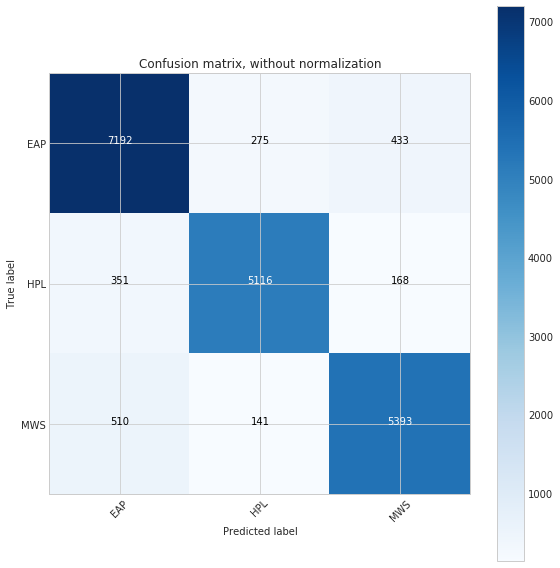

In [129]:
cnf_matrix = confusion_matrix(y_train, np.argmax(p_xgb_all[i_train].values, axis=1))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

In [1]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:40]),
    ax=ax,
    height=0.8)
plt.show()

NameError: name 'plt' is not defined

#### fine tune xgboost

In [87]:
drop_elements = ['id', 'text', 'mnb_oof_tfc_eap', 'mnb_oof_tfc_hpl', 'mnb_oof_tfc_mws']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

In [88]:
params={
    'max_depth': [2], #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': [0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.5], #[0.5,0.6,0.7,0.8],
    'n_estimators': [1000], #[1000,2000,3000]
    'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}

xgb_params = {
    'learning_rate': [0.1],  # [0.01, 0.03, 0.1, 0.3] 0.1
    'n_estimators': [100], # [10, 100, 300, 100] 100
    'max_depth': [5],
    'min_child_weight': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.5], # [0.5, 0.7]
    'missing': [-999],
    'nthread': [-1],
    'silent': [1],
    'objective': ['multi:softprob'],
    'seed': [2017]
}
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(
    xgb_model,
    xgb_params,
    n_jobs=-1,
    scoring='neg_log_loss',
    verbose=2,
    refit=True)
clf.fit(xtrain, ytrain)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=300, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=100, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8, total= 2.1min

[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=300, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.3, max_depth=5, min_child_weight=1, missing=-999, n_estimators=1000, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8, total=13.7min
[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=1000, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=300, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8, total= 8.6min
[CV] colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, missing=-999, n_estimators=1000, nthread=-1, objective=multi:softprob, seed=2017, silent=1, subsample=0.8 
[CV]  colsample_bytree=0.7, learning_rate=

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 83.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3], 'n_estimators': [100, 300, 1000], 'max_depth': [5], 'min_child_weight': [1], 'subsample': [0.8], 'colsample_bytree': [0.5, 0.7], 'missing': [-999], 'nthread': [-1], 'silent': [1], 'objective': ['multi:softprob'], 'seed': [2017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=2)